In [1]:
## Project details: https://www.kaggle.com/competitions/m5-forecasting-accuracy/overview/description

In [2]:

%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Ignore harmless warnings

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse,rmse
import gc
from matplotlib import dates
from statsmodels.tsa.seasonal import STL
import datetime
sns.set_context("talk")
sns.set_style("darkgrid")
import matplotlib as mpl
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

from datasetsforecast.hierarchical import HierarchicalData
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import  BottomUp, TopDown, MiddleOut, MinTrace, ERM
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from tqdm.autonotebook import tqdm

from matplotlib import dates
from datetime import datetime
from datetime import timedelta, date
import matplotlib.dates as mdates


from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import math
from sklearn.linear_model import Lasso
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

from sktime.transformations.series.time_since import TimeSince

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.utils._testing.hierarchical import _make_hierarchical
from sktime.forecasting.compose import make_reduction
from sklearn.pipeline import make_pipeline
from sktime.transformations.series.date import DateTimeFeatures
from sktime.forecasting.arima import ARIMA
from sktime.transformations.hierarchical.aggregate import Aggregator

from statsmodels.stats.outliers_influence import variance_inflation_factor

from lightgbm import LGBMRegressor
# Let's ensure all sklearn transformers output pandas dataframes
from sklearn import set_config
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince

set_config(transform_output="pandas")  # Upgrade to scikit-learn 0.12
# for this feature


from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter

In [6]:
simplefilter("ignore", category=ConvergenceWarning)

## OVERVIEW
#### The M5 dataset, generously made available by Walmart, involves the unit sales of various 
#### products sold in the USA, organized in the form of grouped time series. More specifically, 
#### the dataset involves the unit sales of 3,049 products,
#### classified in 3 product categories (Hobbies, Foods, and Household) and 
#### 7 product departments, in which the above-mentioned categories are disaggregated.  
#### The products are sold across ten stores, located in three States (CA, TX, and WI). 
#### In this respect, the bottom-level of the hierarchy, i.e., product-store unit sales 
#### can be mapped across either product categories or geographical regions

In [7]:
gc.collect()

35

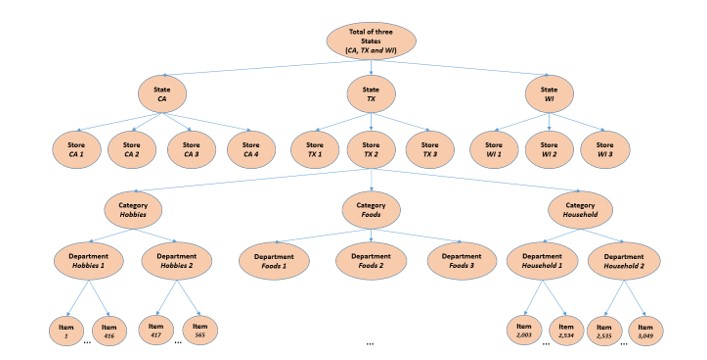

In [8]:
from IPython import display
display.Image("C:\\Users\\ajit2\\Desktop\\Capstone- use this\\Hierarchy.jpg")
#### An overview of how the forecasting Hierarchy is organized.

In [9]:
gc.collect()

0

## Importing files

In [10]:
sell_prices = pd.read_csv("C:\\Users\\ajit2\\Desktop\\Capstone- use this\\sell_prices.csv")
calendar = pd.read_csv("C:\\Users\\ajit2\\Desktop\\Capstone- use this\\calendar.csv",parse_dates=True)
sales=pd.read_csv("C:\\Users\\ajit2\\Desktop\\Capstone- use this\\sales_train_evaluation.csv")

In [11]:
df=sales.drop(['id','dept_id','state_id'],axis=1)
df

item_id   cat_id store_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  \
0      HOBBIES_1_001  HOBBIES     CA_1    0    0    0    0    0    0    0   
1      HOBBIES_1_002  HOBBIES     CA_1    0    0    0    0    0    0    0   
2      HOBBIES_1_003  HOBBIES     CA_1    0    0    0    0    0    0    0   
3      HOBBIES_1_004  HOBBIES     CA_1    0    0    0    0    0    0    0   
4      HOBBIES_1_005  HOBBIES     CA_1    0    0    0    0    0    0    0   
...              ...      ...      ...  ...  ...  ...  ...  ...  ...  ...   
30485    FOODS_3_823    FOODS     WI_3    0    0    2    2    0    3    1   
30486    FOODS_3_824    FOODS     WI_3    0    0    0    0    0    5    0   
30487    FOODS_3_825    FOODS     WI_3    0    6    0    2    2    4    1   
30488    FOODS_3_826    FOODS     WI_3    0    0    0    0    0    0    0   
30489    FOODS_3_827    FOODS     WI_3    0    0    0    0    0    0    0   

       ...  d_1932  d_1933  d_1934  d_1935  d_1936  d_1937  d_1938  d_1939  \
0      ...       2       4       0       0       0       0       3       3   
1      ...       0       1       2       1       1       0       0       0   
2      ...       1       0       2       0       0       0       2       3   
3      ...       1       1       0       4       0       1       3       0   
4      ...       0       0       0       2       1       0       0       2   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
30485  ...       1       0       3       0       1       1       0       0   
30486  ...       0       0       0       0       0       0       1       0   
30487  ...       0       0       1       2       0       1       0       1   
30488  ...       1       1       1       4       6       0       1       1   
30489  ...       1       2       0       5       4       0       2       2   

       d_1940  d_1941  
0           0       1  
1           0       0  
2           0       1  
3           2       6  
4           1       0  
...       ...     ...  
30485       1       1  
30486       1       0  
30487       0       2  
30488       1       0  
30489       5       1  

[30490 rows x 1944 columns]

### Table of contents for this notebook :
#### 1) Plotting
####    a) Aggregate daily unit Sales per Stores
####    b) Daily sales pattern
####    c) Day-of-week sales pattern
####    d) Monthly sales pattern
####    e) Quarterly sales pattern
#### 2) Inventory classification
#### 3) Hierarchichal forecasting
#### 4)Plotting/forcasting of daily sales data for CA_3 (highest sales store)
####    a) Using SARIMAX -holidays as exogenous variable
####    b) Using Holt Winters
####    c) Using FB Prophet
#### 5)Creating Features for Machine learning model
####    a) F1- Time series features
####    b) F2- Expanding Features
####    c) F3- Difference Features
####    d) F4- Lag and Rolling features
####    e) F5- Datetime and cyclical features
####    f) F6- sell price,snap and Holiday Features
#### 6) Dropping missing data
#### 7) Creating target(Y) columns for direct forecasting (28 days)
#### 8) Accuracy of Naive forecast
#### 9) Important Features per Ridge Regression
#### 10) Direct Forecasting (for next 28 days)using Lasso
#### 11) Recursive forecasting using XGboost
#### 12) Plotting predictons, actuals and accuracy at :
####  a)Daily time bucket and  Item level 
####  b) Daily time bucket for stores, state total and overall WMT level aggregation

## 1.Plotting 

### a) Aggregate daily unit Sales per Stores

In [12]:
store_ids = sales['store_id'].values
state_id = []

for id in store_ids:
    state_id.append(id[:2])
state_id = np.array(state_id)
sales['state_id'] = state_id

df_grouped_statewise = sales.groupby('state_id')

In [13]:
#sales['state_id']

In [14]:
#df_grouped_statewise 

In [15]:
date_cols = [c for c in sales.columns if 'd_' in c]

In [16]:
date_range = calendar['date']
d_st = date_range[0]
d_end = date_range[1940]
date_range = pd.date_range(start=d_st, end=d_end)
date_range

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
               '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', length=1941, freq='D')

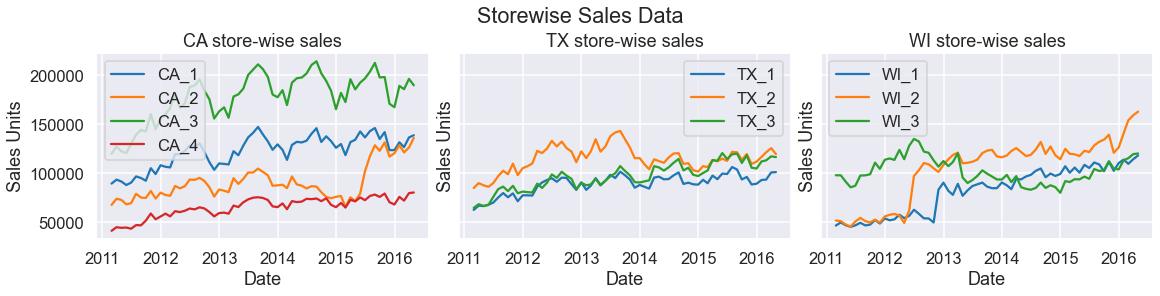

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4), sharey=True, constrained_layout=True)
fig.suptitle('Storewise Sales Data')
i = 0
for state_name, state_group in df_grouped_statewise:
    df_store_wise_grouped = state_group.groupby('store_id')
    axs[i].set_title('%s store-wise sales' % state_name)
    axs[i].set(xlabel='Date', ylabel='Sales Units')
    axs[i].grid(True)
    for store_name, store_group in df_store_wise_grouped:
        aggr_array = []
        for d in date_cols:
            aggr_array.append(store_group[d].values.sum())
        daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
        monthly_time_seies_df = daily_time_series_df.resample('1M').sum()
        axs[i].plot(monthly_time_seies_df.index[1:-1], monthly_time_seies_df['Sales'].values[1:-1], label='%s' % store_name)
        axs[i].legend()
    i += 1

plt.show()

In [18]:
# the graph above shows that CA_3 is the higest selling store (unit wise)
# some of the store have change points (CA_2,TX_2,WI_2)

In [19]:
gc.collect()

15

In [20]:
# making the table of data long for further analysis

In [21]:
df1=df.melt(id_vars=['store_id','item_id','cat_id'],var_name='d',value_name='unit_sales')
df1

store_id        item_id   cat_id       d  unit_sales
0            CA_1  HOBBIES_1_001  HOBBIES     d_1           0
1            CA_1  HOBBIES_1_002  HOBBIES     d_1           0
2            CA_1  HOBBIES_1_003  HOBBIES     d_1           0
3            CA_1  HOBBIES_1_004  HOBBIES     d_1           0
4            CA_1  HOBBIES_1_005  HOBBIES     d_1           0
...           ...            ...      ...     ...         ...
59181085     WI_3    FOODS_3_823    FOODS  d_1941           1
59181086     WI_3    FOODS_3_824    FOODS  d_1941           0
59181087     WI_3    FOODS_3_825    FOODS  d_1941           2
59181088     WI_3    FOODS_3_826    FOODS  d_1941           0
59181089     WI_3    FOODS_3_827    FOODS  d_1941           1

[59181090 rows x 5 columns]

In [22]:
gc.collect()

0

In [23]:
# merging with calendar table to get dates and holidays

In [24]:
df_final= pd.merge(left=df1,right=calendar,how='left',left_on=['d'],right_on=['d'])
df_final

store_id        item_id   cat_id       d  unit_sales        date  \
0            CA_1  HOBBIES_1_001  HOBBIES     d_1           0  2011-01-29   
1            CA_1  HOBBIES_1_002  HOBBIES     d_1           0  2011-01-29   
2            CA_1  HOBBIES_1_003  HOBBIES     d_1           0  2011-01-29   
3            CA_1  HOBBIES_1_004  HOBBIES     d_1           0  2011-01-29   
4            CA_1  HOBBIES_1_005  HOBBIES     d_1           0  2011-01-29   
...           ...            ...      ...     ...         ...         ...   
59181085     WI_3    FOODS_3_823    FOODS  d_1941           1  2016-05-22   
59181086     WI_3    FOODS_3_824    FOODS  d_1941           0  2016-05-22   
59181087     WI_3    FOODS_3_825    FOODS  d_1941           2  2016-05-22   
59181088     WI_3    FOODS_3_826    FOODS  d_1941           0  2016-05-22   
59181089     WI_3    FOODS_3_827    FOODS  d_1941           1  2016-05-22   

          wm_yr_wk   weekday  wday  month  year event_name_1 event_type_1  \
0            11101  Saturday     1      1  2011          NaN          NaN   
1            11101  Saturday     1      1  2011          NaN          NaN   
2            11101  Saturday     1      1  2011          NaN          NaN   
3            11101  Saturday     1      1  2011          NaN          NaN   
4            11101  Saturday     1      1  2011          NaN          NaN   
...            ...       ...   ...    ...   ...          ...          ...   
59181085     11617    Sunday     2      5  2016          NaN          NaN   
59181086     11617    Sunday     2      5  2016          NaN          NaN   
59181087     11617    Sunday     2      5  2016          NaN          NaN   
59181088     11617    Sunday     2      5  2016          NaN          NaN   
59181089     11617    Sunday     2      5  2016          NaN          NaN   

         event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0                 NaN          NaN        0        0        0  
1                 NaN          NaN        0        0        0  
2                 NaN          NaN        0        0        0  
3                 NaN          NaN        0        0        0  
4                 NaN          NaN        0        0        0  
...               ...          ...      ...      ...      ...  
59181085          NaN          NaN        0        0        0  
59181086          NaN          NaN        0        0        0  
59181087          NaN          NaN        0        0        0  
59181088          NaN          NaN        0        0        0  
59181089          NaN          NaN        0        0        0  

[59181090 rows x 18 columns]

In [25]:
gc.collect()

0

In [26]:
df_plot=df_final.groupby(['store_id','date'])[['unit_sales']].sum().reset_index()
df_plot

store_id        date  unit_sales
0         CA_1  2011-01-29        4337
1         CA_1  2011-01-30        4155
2         CA_1  2011-01-31        2816
3         CA_1  2011-02-01        3051
4         CA_1  2011-02-02        2630
...        ...         ...         ...
19405     WI_3  2016-05-18        3268
19406     WI_3  2016-05-19        3398
19407     WI_3  2016-05-20        4126
19408     WI_3  2016-05-21        4519
19409     WI_3  2016-05-22        4757

[19410 rows x 3 columns]

In [27]:
# converting date column to date time and extracting various date related features

In [28]:
df_plot.date=pd.to_datetime(df_plot.date)

In [29]:
df_plot['year']=df_plot.date.dt.year

In [30]:
df_plot['quarter']=df_plot.date.dt.quarter

In [31]:
df_plot['month']=df_plot.date.dt.month

In [32]:
df_plot['week']=df_plot.date.dt.isocalendar().week

In [33]:
df_plot['day']=df_plot.date.dt.day

In [34]:
df_plot['day_of_week']=df_plot.date.dt.day_of_week

In [35]:
#df_plot['weekday']=df_plot.date.dt.weekday

In [36]:
df_plot['dayofyear']=df_plot.date.dt.dayofyear

In [37]:
df_plot["is_weekend"] =np.where(df_plot.date.dt.dayofweek > 4,1,0)
                                                    
                                       

In [38]:
df_plot

store_id       date  unit_sales  year  quarter  month  week  day  \
0         CA_1 2011-01-29        4337  2011        1      1     4   29   
1         CA_1 2011-01-30        4155  2011        1      1     4   30   
2         CA_1 2011-01-31        2816  2011        1      1     5   31   
3         CA_1 2011-02-01        3051  2011        1      2     5    1   
4         CA_1 2011-02-02        2630  2011        1      2     5    2   
...        ...        ...         ...   ...      ...    ...   ...  ...   
19405     WI_3 2016-05-18        3268  2016        2      5    20   18   
19406     WI_3 2016-05-19        3398  2016        2      5    20   19   
19407     WI_3 2016-05-20        4126  2016        2      5    20   20   
19408     WI_3 2016-05-21        4519  2016        2      5    20   21   
19409     WI_3 2016-05-22        4757  2016        2      5    20   22   

       day_of_week  dayofyear  is_weekend  
0                5         29           1  
1                6         30           1  
2                0         31           0  
3                1         32           0  
4                2         33           0  
...            ...        ...         ...  
19405            2        139           0  
19406            3        140           0  
19407            4        141           0  
19408            5        142           1  
19409            6        143           1  

[19410 rows x 11 columns]

In [39]:
df_plot_STL=df_plot.copy()

###  b) Daily sales pattern

In [40]:
daily_sales=df_plot.query('year>2011 and year<2016').groupby(['store_id','dayofyear'])[['unit_sales']].mean().reset_index()
daily_sales.set_index('dayofyear',inplace=True)
daily_sales

store_id  unit_sales
dayofyear                     
1             CA_1     2815.75
2             CA_1     4134.00
3             CA_1     4377.00
4             CA_1     4542.75
5             CA_1     4518.50
...            ...         ...
362           WI_3     2641.25
363           WI_3     2775.00
364           WI_3     2942.00
365           WI_3     3723.75
366           WI_3     3740.00

[3660 rows x 2 columns]

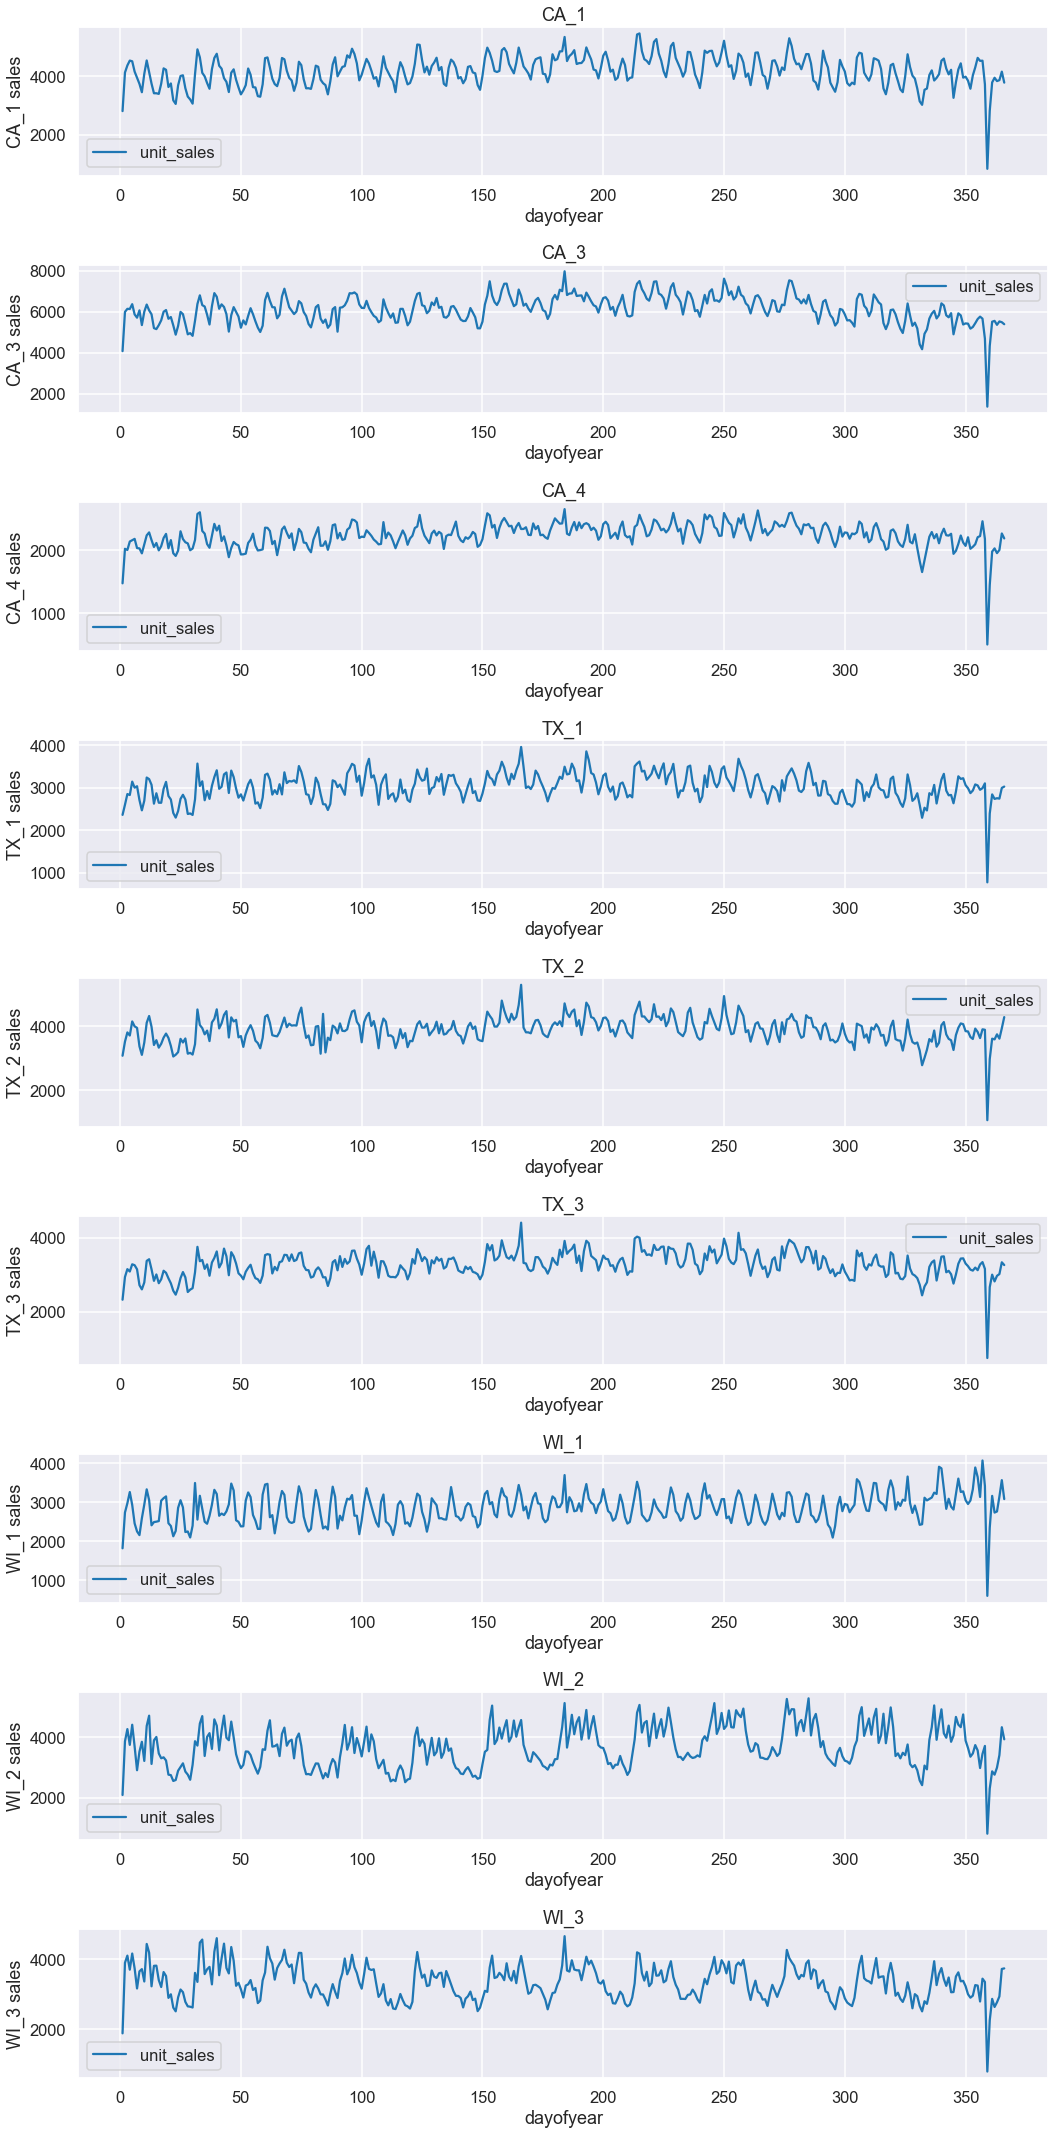

In [41]:
var=['CA_1','CA_3','CA_4','TX_1','TX_2','TX_3','WI_1','WI_2','WI_3']


fig,ax = plt.subplots(nrows=len(var),figsize=[15,30])
                     
for ix, store in enumerate(var): 
    daily_sales.query(f'store_id=="{store}"').plot(ax=ax[ix])
    ax[ix].set(title=f"{store}", ylabel=f"{store} sales")
    
fig.tight_layout()
plt.show()

In [42]:
# plots above show that all the stores have the lowest sales on Christmas day

### c) Day of week sales pattern

In [43]:
day_of_week_sales=df_plot.query('year>2011 and year<2016').groupby(['store_id','day_of_week'])[['unit_sales']].mean().reset_index()
day_of_week_sales.set_index('day_of_week',inplace=True)
day_of_week_sales

store_id   unit_sales
day_of_week                      
0               CA_1  4039.066986
1               CA_1  3561.622010
2               CA_1  3466.665072
3               CA_1  3495.794258
4               CA_1  4187.004808
...              ...          ...
2               WI_3  2916.593301
3               WI_3  2945.980861
4               WI_3  3475.149038
5               WI_3  4084.519231
6               WI_3  3877.124402

[70 rows x 2 columns]

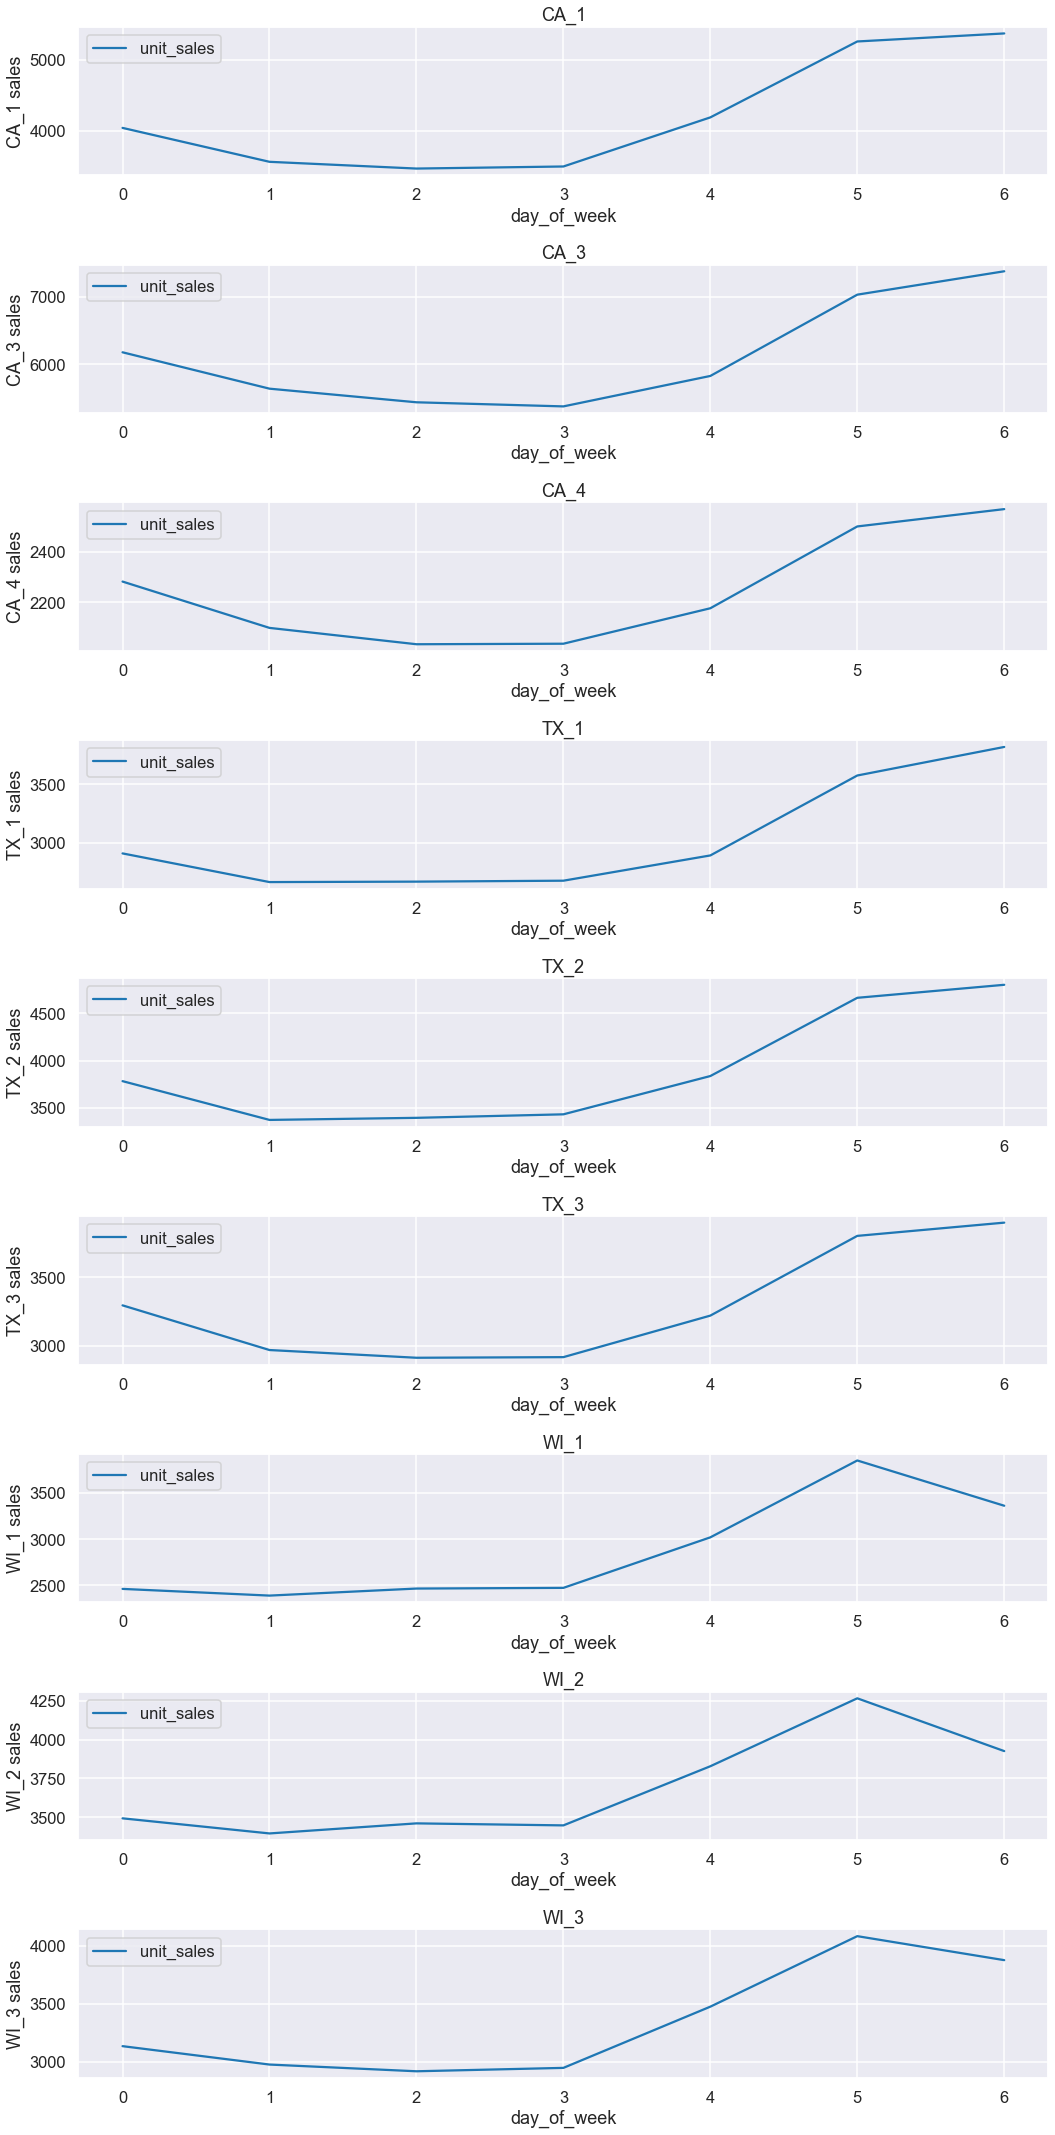

In [44]:
var=['CA_1','CA_3','CA_4','TX_1','TX_2','TX_3','WI_1','WI_2','WI_3']


fig,ax = plt.subplots(nrows=len(var),figsize=[15,30])
                     
for ix, store in enumerate(var): 
    day_of_week_sales.query(f'store_id=="{store}"').plot(ax=ax[ix])
    ax[ix].set(title=f"{store}", ylabel=f"{store} sales")
    
fig.tight_layout()
plt.show()

In [45]:
# plots show that sales are higher during week ends (day 5 and day 6)

### d) Monthly sales pattern

In [46]:
monthly_sales=df_plot.query('year>2011 and year<2016').groupby(['store_id','month'])[['unit_sales']].mean().reset_index()
monthly_sales.set_index('month',inplace=True)
monthly_sales

store_id   unit_sales
month                      
1         CA_1  3788.532258
2         CA_1  3956.336283
3         CA_1  4054.790323
4         CA_1  4199.758333
5         CA_1  4234.088710
...        ...          ...
8         WI_3  3369.620968
9         WI_3  3405.008333
10        WI_3  3303.854839
11        WI_3  3257.983333
12        WI_3  3144.927419

[120 rows x 2 columns]

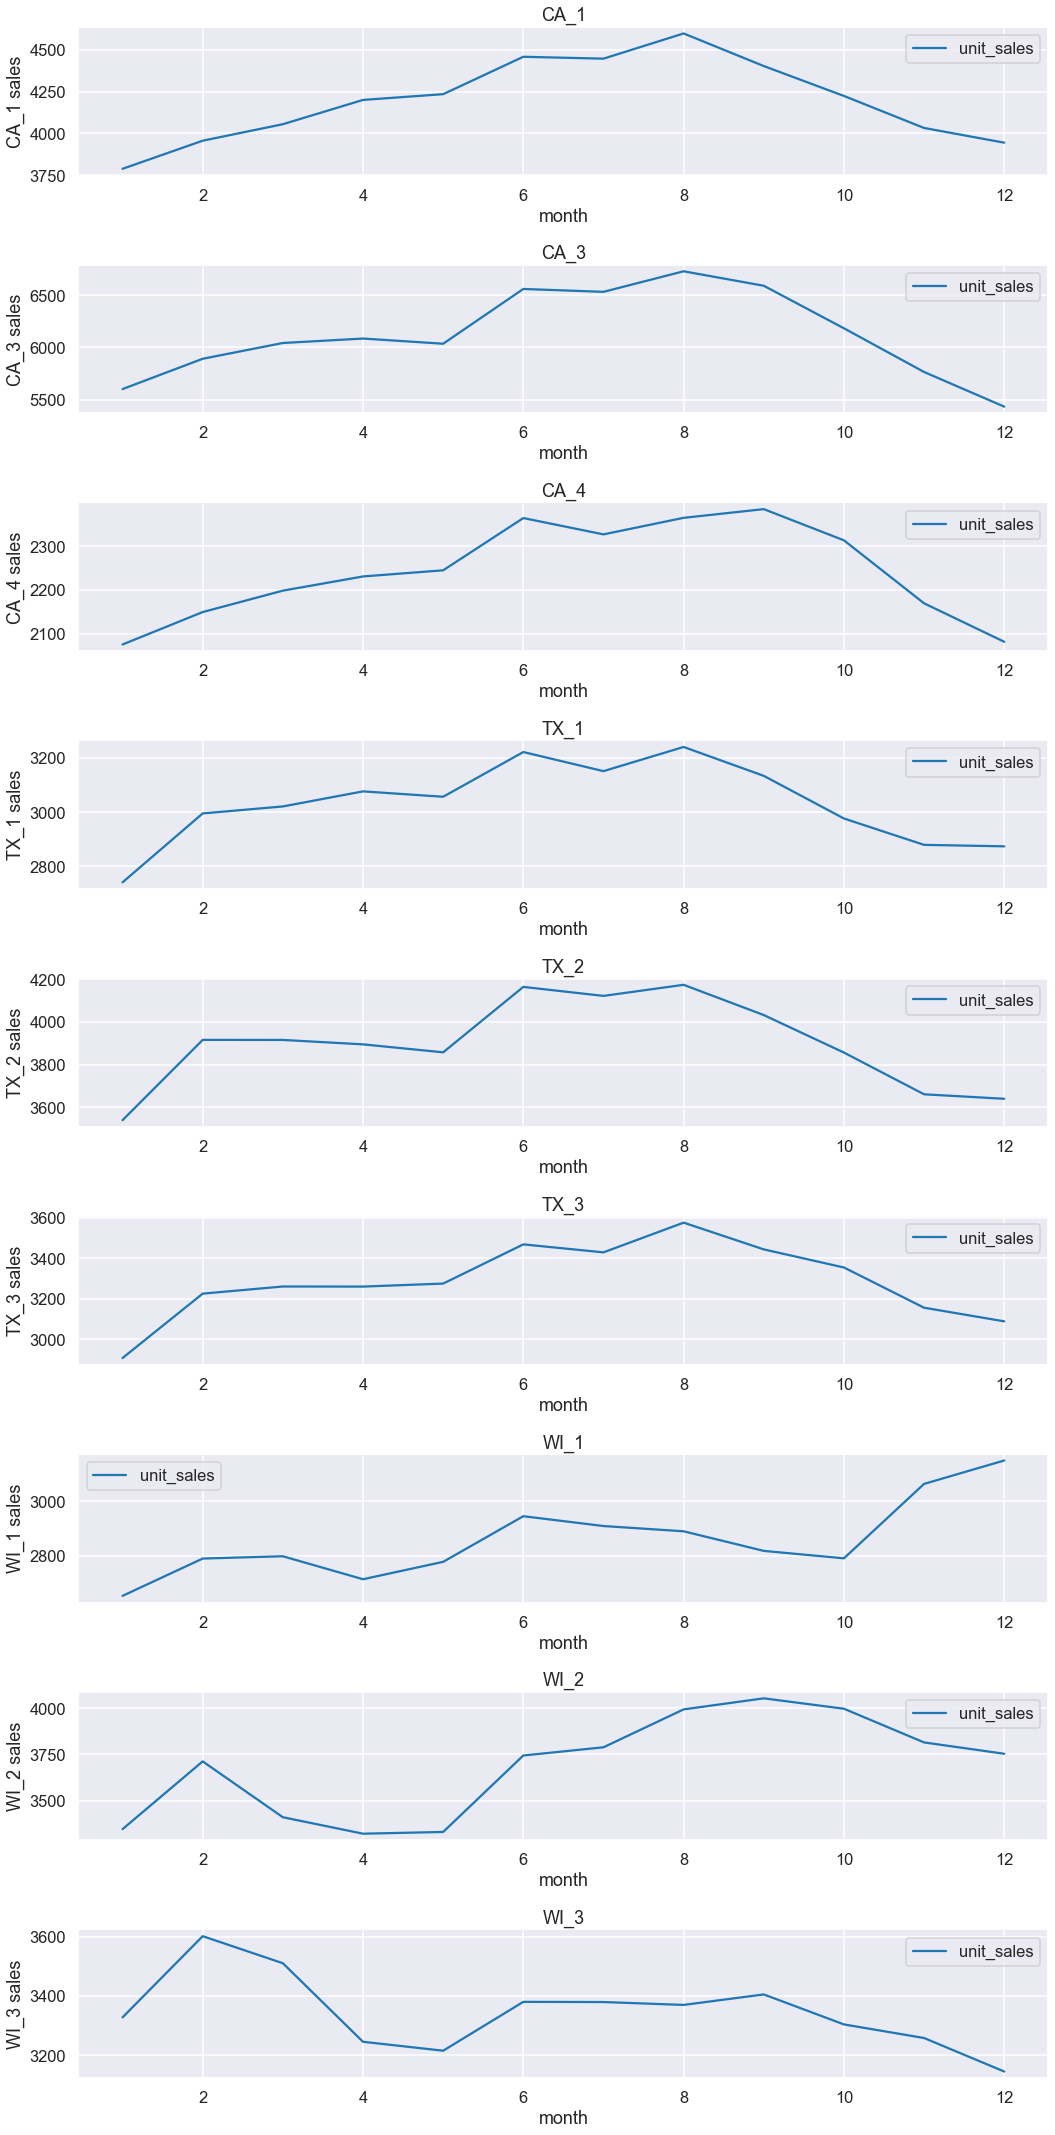

In [47]:
var=['CA_1','CA_3','CA_4','TX_1','TX_2','TX_3','WI_1','WI_2','WI_3']


fig,ax = plt.subplots(nrows=len(var),figsize=[15,30])
                     
for ix, store in enumerate(var): 
    monthly_sales.query(f'store_id=="{store}"').plot(ax=ax[ix])
    ax[ix].set(title=f"{store}", ylabel=f"{store} sales")
    
fig.tight_layout()
plt.show()

In [48]:
# most stores have august (month 8 ) as the highest selling store. some have others. Details below:
#CA_1 - 8
#CA_3 -8
#CA_4-9
#TX_1=8
#TX_2=8
#TX_3=8
#WI_1=12
#WI_2=9
#WI_3=2

### d) Quarterly sales pattern

In [49]:
quarterly_sales=df_plot.query('year>2011 and year<2016').groupby(['store_id','quarter'])[['unit_sales']].mean().reset_index()
quarterly_sales.set_index('quarter',inplace=True)
quarterly_sales

store_id   unit_sales
quarter                      
1           CA_1  3932.515235
2           CA_1  4296.370879
3           CA_1  4482.402174
4           CA_1  4067.187500
1           CA_2  2734.171745
2           CA_2  2917.785714
3           CA_2  3288.834239
4           CA_2  3025.133152
1           CA_3  5842.434903
2           CA_3  6223.101648
3           CA_3  6615.630435
4           CA_3  5792.847826
1           CA_4  2140.454294
2           CA_4  2279.164835
3           CA_4  2358.029891
4           CA_4  2187.942935
1           TX_1  2916.434903
2           TX_1  3116.865385
3           TX_1  3174.690217
4           TX_1  2909.885870
1           TX_2  3786.299169
2           TX_2  3970.359890
3           TX_2  4109.366848
4           TX_2  3719.557065
1           TX_3  3127.559557
2           TX_3  3333.901099
3           TX_3  3483.891304
4           TX_3  3199.625000
1           WI_1  2744.526316
2           WI_1  2811.052198
3           WI_1  2872.293478
4           WI_1  3000.608696
1           WI_2  3483.013850
2           WI_2  3464.214286
3           WI_2  3943.459239
4           WI_2  3855.228261
1           WI_3  3476.096953
2           WI_3  3279.428571
3           WI_3  3384.437500
4           WI_3  3235.345109

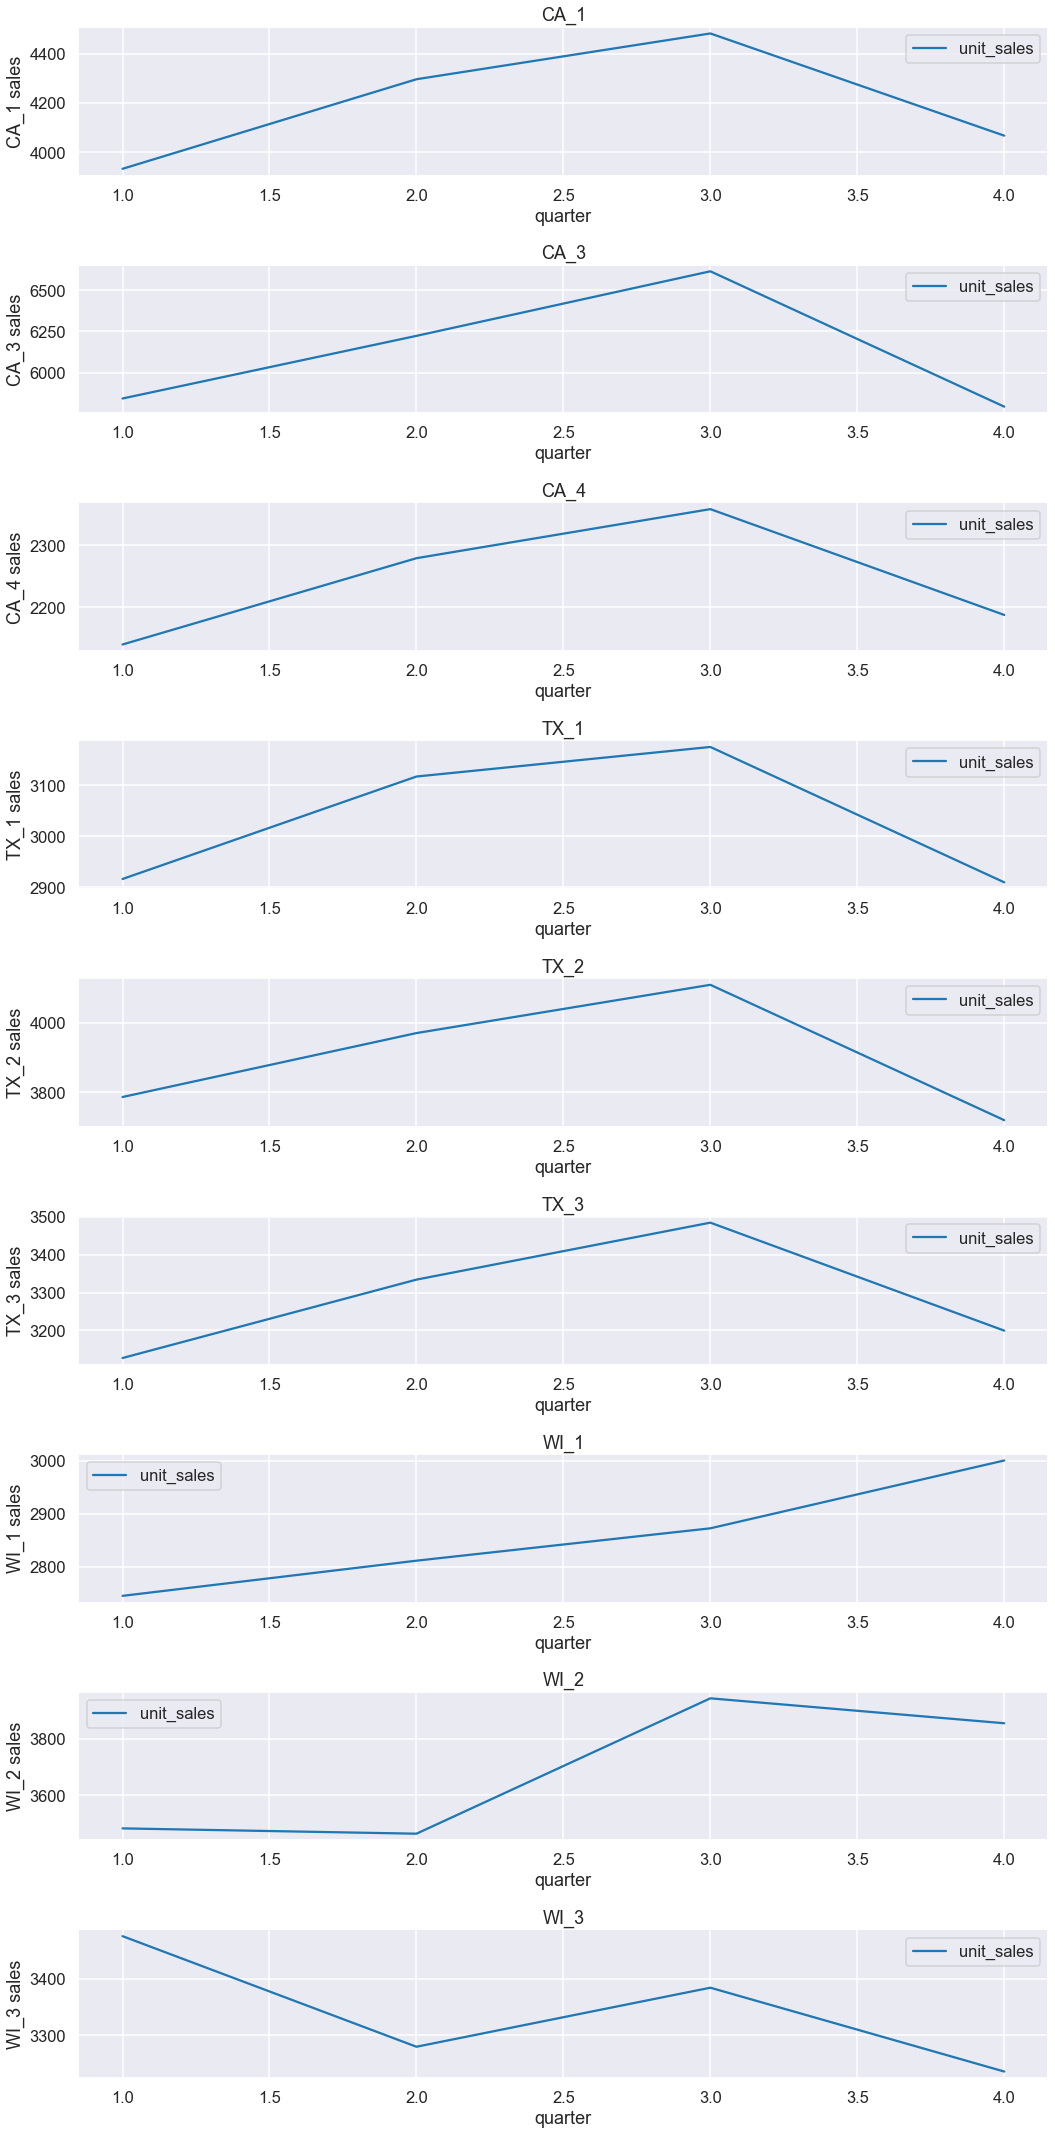

In [50]:
var=['CA_1','CA_3','CA_4','TX_1','TX_2','TX_3','WI_1','WI_2','WI_3']


fig,ax = plt.subplots(nrows=len(var),figsize=[15,30])
                     
for ix, store in enumerate(var): 
    quarterly_sales.query(f'store_id=="{store}"').plot(ax=ax[ix])
    #ax[ix].get_xticks(np.arange(4), ['1', '2', '3','4']) 
    ax[ix].set(title=f"{store}", ylabel=f"{store} sales")
    
fig.tight_layout()
plt.show()

In [51]:
# most stores have Q3 as the highest selling store. some have others. Details below:
#CA_1 -Q3
#CA_3 -Q3
#CA_4-Q3
#TX_1=Q3
#TX_2=Q3
#TX_3=Q3
#WI_1=Q4
#WI_2=Q4
#WI_3=Q1

In [52]:
gc.collect()

25088

## 2. Inventory Classification

In [53]:
# grouping to get weekly sales data

In [54]:
df_final_weekly_sales=df_final[['store_id','item_id','cat_id','wm_yr_wk','unit_sales']]\
.groupby(['store_id','item_id','cat_id','wm_yr_wk']).sum().reset_index()
df_final_weekly_sales

store_id          item_id     cat_id  wm_yr_wk  unit_sales
0           CA_1      FOODS_1_001      FOODS     11101          10
1           CA_1      FOODS_1_001      FOODS     11102           6
2           CA_1      FOODS_1_001      FOODS     11103          10
3           CA_1      FOODS_1_001      FOODS     11104          13
4           CA_1      FOODS_1_001      FOODS     11105          15
...          ...              ...        ...       ...         ...
8476215     WI_3  HOUSEHOLD_2_516  HOUSEHOLD     11613           1
8476216     WI_3  HOUSEHOLD_2_516  HOUSEHOLD     11614           0
8476217     WI_3  HOUSEHOLD_2_516  HOUSEHOLD     11615           0
8476218     WI_3  HOUSEHOLD_2_516  HOUSEHOLD     11616           1
8476219     WI_3  HOUSEHOLD_2_516  HOUSEHOLD     11617           0

[8476220 rows x 5 columns]

In [55]:
gc.collect()

0

In [56]:
# join with calendar table

In [57]:
df_final_with_sales_price= pd.merge(left=df_final_weekly_sales,right=sell_prices,how='left',\
left_on=['store_id','item_id','wm_yr_wk'],right_on=['store_id','item_id','wm_yr_wk'])
df_final_with_sales_price

store_id          item_id     cat_id  wm_yr_wk  unit_sales  sell_price
0           CA_1      FOODS_1_001      FOODS     11101          10        2.00
1           CA_1      FOODS_1_001      FOODS     11102           6        2.00
2           CA_1      FOODS_1_001      FOODS     11103          10        2.00
3           CA_1      FOODS_1_001      FOODS     11104          13        2.00
4           CA_1      FOODS_1_001      FOODS     11105          15        2.00
...          ...              ...        ...       ...         ...         ...
8476215     WI_3  HOUSEHOLD_2_516  HOUSEHOLD     11613           1        5.94
8476216     WI_3  HOUSEHOLD_2_516  HOUSEHOLD     11614           0        5.94
8476217     WI_3  HOUSEHOLD_2_516  HOUSEHOLD     11615           0        5.94
8476218     WI_3  HOUSEHOLD_2_516  HOUSEHOLD     11616           1        5.94
8476219     WI_3  HOUSEHOLD_2_516  HOUSEHOLD     11617           0        5.94

[8476220 rows x 6 columns]

In [58]:
gc.collect()

0

In [59]:
df_final_with_sales_price_WK_YR= pd.merge(left=df_final_with_sales_price,\
right=calendar.drop_duplicates('wm_yr_wk',keep='first')[['wm_yr_wk','year']],
                                          how='left',left_on=['wm_yr_wk'],right_on=['wm_yr_wk'])


df_final_with_sales_price_WK_YR

store_id          item_id     cat_id  wm_yr_wk  unit_sales  \
0           CA_1      FOODS_1_001      FOODS     11101          10   
1           CA_1      FOODS_1_001      FOODS     11102           6   
2           CA_1      FOODS_1_001      FOODS     11103          10   
3           CA_1      FOODS_1_001      FOODS     11104          13   
4           CA_1      FOODS_1_001      FOODS     11105          15   
...          ...              ...        ...       ...         ...   
8476215     WI_3  HOUSEHOLD_2_516  HOUSEHOLD     11613           1   
8476216     WI_3  HOUSEHOLD_2_516  HOUSEHOLD     11614           0   
8476217     WI_3  HOUSEHOLD_2_516  HOUSEHOLD     11615           0   
8476218     WI_3  HOUSEHOLD_2_516  HOUSEHOLD     11616           1   
8476219     WI_3  HOUSEHOLD_2_516  HOUSEHOLD     11617           0   

         sell_price  year  
0              2.00  2011  
1              2.00  2011  
2              2.00  2011  
3              2.00  2011  
4              2.00  2011  
...             ...   ...  
8476215        5.94  2016  
8476216        5.94  2016  
8476217        5.94  2016  
8476218        5.94  2016  
8476219        5.94  2016  

[8476220 rows x 7 columns]

In [60]:
gc.collect()

0

In [61]:
#calendar.shape

In [62]:
# checking for Null values

In [63]:
df_final_with_sales_price_WK_YR.isnull().sum()

store_id            0
item_id             0
cat_id              0
wm_yr_wk            0
unit_sales          0
sell_price    1757059
year                0
dtype: int64

In [64]:
# filling NA values

In [65]:
df_final_with_sales_price_WK_YR['sell_price'] = df_final_with_sales_price_WK_YR['sell_price'].fillna(0)

In [66]:
# creating revenue as sales* prices

In [67]:
df_final_with_sales_price_WK_YR['Sales_Revenue']=df_final_with_sales_price_WK_YR['unit_sales']*df_final_with_sales_price_WK_YR['sell_price']

In [68]:
# checking for Null values again

In [69]:
df_final_with_sales_price_WK_YR.isnull().sum()

store_id         0
item_id          0
cat_id           0
wm_yr_wk         0
unit_sales       0
sell_price       0
year             0
Sales_Revenue    0
dtype: int64

In [70]:
gc.collect()

0

In [71]:
# creating revenue totals column

In [72]:
Item_sales_revenue_sum=df_final_with_sales_price_WK_YR.groupby(['item_id','cat_id']).agg({'Sales_Revenue':'sum'}).sort_values(['Sales_Revenue'],ascending=False)
Item_sales_revenue_sum=Item_sales_revenue_sum.query('Sales_Revenue!=0')


In [73]:
gc.collect()

3

In [74]:
# creating a column for getting the cumulative sum

In [75]:
Item_sales_revenue_sum['grouped_cumulative_sum'] = \
(Item_sales_revenue_sum.Sales_Revenue.cumsum()/Item_sales_revenue_sum.Sales_Revenue.sum())*100
Item_sales_revenue_sum

Sales_Revenue  grouped_cumulative_sum
item_id       cat_id                                        
FOODS_3_586   FOODS       1482295.48                0.773731
FOODS_3_120   FOODS       1444850.10                1.527917
FOODS_3_090   FOODS       1377664.04                2.247032
FOODS_3_202   FOODS       1272487.14                2.911248
FOODS_3_587   FOODS        991308.02                3.428692
...                              ...                     ...
HOBBIES_2_023 HOBBIES         819.65               99.998881
HOBBIES_2_065 HOBBIES         671.00               99.999231
HOBBIES_2_047 HOBBIES         550.96               99.999519
HOBBIES_2_025 HOBBIES         463.50               99.999761
HOBBIES_2_026 HOBBIES         457.93              100.000000

[3049 rows x 2 columns]

In [76]:
gc.collect()

0

In [77]:
Item_sales_revenue_sum.reset_index(inplace=True)

In [78]:
Item_sales_revenue_sum

item_id   cat_id  Sales_Revenue  grouped_cumulative_sum
0       FOODS_3_586    FOODS     1482295.48                0.773731
1       FOODS_3_120    FOODS     1444850.10                1.527917
2       FOODS_3_090    FOODS     1377664.04                2.247032
3       FOODS_3_202    FOODS     1272487.14                2.911248
4       FOODS_3_587    FOODS      991308.02                3.428692
...             ...      ...            ...                     ...
3044  HOBBIES_2_023  HOBBIES         819.65               99.998881
3045  HOBBIES_2_065  HOBBIES         671.00               99.999231
3046  HOBBIES_2_047  HOBBIES         550.96               99.999519
3047  HOBBIES_2_025  HOBBIES         463.50               99.999761
3048  HOBBIES_2_026  HOBBIES         457.93              100.000000

[3049 rows x 4 columns]

In [79]:
gc.collect()

0

#### Classifying item ids as A,B,C based on 
##### A: if they contribute >85 percent of total revenue
##### B: next 15% of revenue (between 80 to 95 percent total revenue
##### C: last 5% (between 95 to 100) revenue of total revenue

In [80]:
Item_sales_revenue_sum["Inventory_class"] = np.where(Item_sales_revenue_sum.grouped_cumulative_sum>95,
                                                    "C",
                                       np.where(Item_sales_revenue_sum.grouped_cumulative_sum>80,"B","A"))

In [81]:
Item_sales_revenue_sum['item_id'].value_counts().sum()

3049

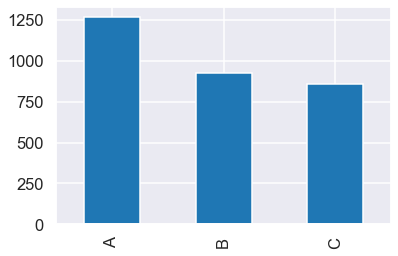

In [82]:
Item_sales_revenue_sum['Inventory_class'].value_counts().plot(kind='bar');

In [83]:
gc.collect()

2892

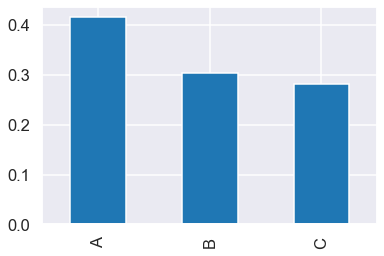

In [84]:
Item_sales_revenue_sum['Inventory_class'].value_counts(normalize=True).plot(kind='bar');

In [85]:
gc.collect()

2816

# Taking samples 10 item-ids each from A,B,C inventory for faster computation

In [86]:
samples = []
for group in Item_sales_revenue_sum.Inventory_class.unique():
    s = Item_sales_revenue_sum.loc[Item_sales_revenue_sum.Inventory_class== group]\
    .sample(n=10).reset_index(drop=True)
    samples.append(s)
    
sample = pd.concat(samples, axis=0)

In [87]:
list12=list(sample['item_id'])
list12

['FOODS_3_672',
 'HOUSEHOLD_1_301',
 'FOODS_3_067',
 'FOODS_1_170',
 'HOUSEHOLD_1_399',
 'HOUSEHOLD_2_368',
 'HOUSEHOLD_1_046',
 'FOODS_2_293',
 'FOODS_2_322',
 'HOUSEHOLD_1_498',
 'FOODS_3_141',
 'HOUSEHOLD_2_125',
 'HOBBIES_1_180',
 'FOODS_3_008',
 'HOUSEHOLD_2_208',
 'FOODS_2_345',
 'HOUSEHOLD_2_373',
 'HOUSEHOLD_1_380',
 'FOODS_3_660',
 'FOODS_1_145',
 'FOODS_3_188',
 'HOBBIES_1_232',
 'HOBBIES_1_181',
 'HOUSEHOLD_2_278',
 'HOBBIES_1_191',
 'HOBBIES_2_072',
 'FOODS_3_268',
 'HOBBIES_1_114',
 'FOODS_3_466',
 'HOUSEHOLD_2_014']

In [88]:
Item_sales_revenue_sum.query('item_id in @list12')

item_id     cat_id  Sales_Revenue  grouped_cumulative_sum  \
49        FOODS_1_170      FOODS      373863.02               15.286341   
134       FOODS_3_672      FOODS      219593.67               27.652252   
146       FOODS_2_293      FOODS      212558.23               29.007649   
318       FOODS_2_322      FOODS      129521.09               43.730044   
322   HOUSEHOLD_1_498  HOUSEHOLD      128127.40               43.998276   
330       FOODS_3_067      FOODS      126668.22               44.529736   
744   HOUSEHOLD_1_399  HOUSEHOLD       70566.02               64.787431   
811   HOUSEHOLD_1_301  HOUSEHOLD       66004.46               67.162511   
864   HOUSEHOLD_2_368  HOUSEHOLD       62847.28               68.945074   
1147  HOUSEHOLD_1_046  HOUSEHOLD       48675.73               77.108971   
1495      FOODS_2_345      FOODS       36385.39               84.776225   
1557  HOUSEHOLD_2_208  HOUSEHOLD       34871.59               85.931515   
1568      FOODS_3_141      FOODS       34625.68               86.130993   
1592      FOODS_3_660      FOODS       33969.16               86.560494   
1860  HOUSEHOLD_2_373  HOUSEHOLD       27643.43               90.854061   
1863    HOBBIES_1_180    HOBBIES       27627.92               90.897333   
1938  HOUSEHOLD_1_380  HOUSEHOLD       25962.17               91.949417   
2107  HOUSEHOLD_2_125  HOUSEHOLD       22217.71               94.073977   
2127      FOODS_3_008      FOODS       21703.25               94.302361   
2189      FOODS_1_145      FOODS       20161.54               94.978822   
2241    HOBBIES_1_114    HOBBIES       18920.43               95.510151   
2269  HOUSEHOLD_2_014  HOUSEHOLD       18368.56               95.782814   
2348    HOBBIES_1_191    HOBBIES       16783.90               96.508799   
2417      FOODS_3_268      FOODS       15441.86               97.088561   
2480    HOBBIES_2_072    HOBBIES       14124.17               97.574922   
2574  HOUSEHOLD_2_278  HOUSEHOLD       12297.81               98.226148   
2582      FOODS_3_188      FOODS       12032.16               98.277034   
2857      FOODS_3_466      FOODS        6148.28               99.611282   
2963    HOBBIES_1_232    HOBBIES        4003.26               99.895871   
3019    HOBBIES_1_181    HOBBIES        1903.81               99.983517   

     Inventory_class  
49                 A  
134                A  
146                A  
318                A  
322                A  
330                A  
744                A  
811                A  
864                A  
1147               A  
1495               B  
1557               B  
1568               B  
1592               B  
1860               B  
1863               B  
1938               B  
2107               B  
2127               B  
2189               B  
2241               C  
2269               C  
2348               C  
2417               C  
2480               C  
2574               C  
2582               C  
2857               C  
2963               C  
3019               C

In [89]:
# preparing Dataframe for ML forecast

In [90]:
df1_sample=df1.query('item_id in @list12')
df1_sample

store_id        item_id   cat_id       d  unit_sales
109          CA_1  HOBBIES_1_114  HOBBIES     d_1           0
175          CA_1  HOBBIES_1_180  HOBBIES     d_1           0
176          CA_1  HOBBIES_1_181  HOBBIES     d_1           0
185          CA_1  HOBBIES_1_191  HOBBIES     d_1           0
224          CA_1  HOBBIES_1_232  HOBBIES     d_1           0
...           ...            ...      ...     ...         ...
59180453     WI_3    FOODS_3_188    FOODS  d_1941           0
59180533     WI_3    FOODS_3_268    FOODS  d_1941           1
59180731     WI_3    FOODS_3_466    FOODS  d_1941           0
59180925     WI_3    FOODS_3_660    FOODS  d_1941           2
59180937     WI_3    FOODS_3_672    FOODS  d_1941           2

[582300 rows x 5 columns]

In [91]:
# merging with calendar dataframe

In [92]:
df_final= pd.merge(left=df1_sample,right=calendar,how='left',left_on=['d'],right_on=['d'])
df_final

store_id        item_id   cat_id       d  unit_sales        date  \
0          CA_1  HOBBIES_1_114  HOBBIES     d_1           0  2011-01-29   
1          CA_1  HOBBIES_1_180  HOBBIES     d_1           0  2011-01-29   
2          CA_1  HOBBIES_1_181  HOBBIES     d_1           0  2011-01-29   
3          CA_1  HOBBIES_1_191  HOBBIES     d_1           0  2011-01-29   
4          CA_1  HOBBIES_1_232  HOBBIES     d_1           0  2011-01-29   
...         ...            ...      ...     ...         ...         ...   
582295     WI_3    FOODS_3_188    FOODS  d_1941           0  2016-05-22   
582296     WI_3    FOODS_3_268    FOODS  d_1941           1  2016-05-22   
582297     WI_3    FOODS_3_466    FOODS  d_1941           0  2016-05-22   
582298     WI_3    FOODS_3_660    FOODS  d_1941           2  2016-05-22   
582299     WI_3    FOODS_3_672    FOODS  d_1941           2  2016-05-22   

        wm_yr_wk   weekday  wday  month  year event_name_1 event_type_1  \
0          11101  Saturday     1      1  2011          NaN          NaN   
1          11101  Saturday     1      1  2011          NaN          NaN   
2          11101  Saturday     1      1  2011          NaN          NaN   
3          11101  Saturday     1      1  2011          NaN          NaN   
4          11101  Saturday     1      1  2011          NaN          NaN   
...          ...       ...   ...    ...   ...          ...          ...   
582295     11617    Sunday     2      5  2016          NaN          NaN   
582296     11617    Sunday     2      5  2016          NaN          NaN   
582297     11617    Sunday     2      5  2016          NaN          NaN   
582298     11617    Sunday     2      5  2016          NaN          NaN   
582299     11617    Sunday     2      5  2016          NaN          NaN   

       event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0               NaN          NaN        0        0        0  
1               NaN          NaN        0        0        0  
2               NaN          NaN        0        0        0  
3               NaN          NaN        0        0        0  
4               NaN          NaN        0        0        0  
...             ...          ...      ...      ...      ...  
582295          NaN          NaN        0        0        0  
582296          NaN          NaN        0        0        0  
582297          NaN          NaN        0        0        0  
582298          NaN          NaN        0        0        0  
582299          NaN          NaN        0        0        0  

[582300 rows x 18 columns]

In [93]:
gc.collect()

3

In [94]:
df_final_with_price= pd.merge(left=df_final,right=sell_prices,how='left',left_on=['store_id','item_id','wm_yr_wk']\
                              ,right_on=['store_id','item_id','wm_yr_wk'])
df_final_with_price

store_id        item_id   cat_id       d  unit_sales        date  \
0          CA_1  HOBBIES_1_114  HOBBIES     d_1           0  2011-01-29   
1          CA_1  HOBBIES_1_180  HOBBIES     d_1           0  2011-01-29   
2          CA_1  HOBBIES_1_181  HOBBIES     d_1           0  2011-01-29   
3          CA_1  HOBBIES_1_191  HOBBIES     d_1           0  2011-01-29   
4          CA_1  HOBBIES_1_232  HOBBIES     d_1           0  2011-01-29   
...         ...            ...      ...     ...         ...         ...   
582295     WI_3    FOODS_3_188    FOODS  d_1941           0  2016-05-22   
582296     WI_3    FOODS_3_268    FOODS  d_1941           1  2016-05-22   
582297     WI_3    FOODS_3_466    FOODS  d_1941           0  2016-05-22   
582298     WI_3    FOODS_3_660    FOODS  d_1941           2  2016-05-22   
582299     WI_3    FOODS_3_672    FOODS  d_1941           2  2016-05-22   

        wm_yr_wk   weekday  wday  month  year event_name_1 event_type_1  \
0          11101  Saturday     1      1  2011          NaN          NaN   
1          11101  Saturday     1      1  2011          NaN          NaN   
2          11101  Saturday     1      1  2011          NaN          NaN   
3          11101  Saturday     1      1  2011          NaN          NaN   
4          11101  Saturday     1      1  2011          NaN          NaN   
...          ...       ...   ...    ...   ...          ...          ...   
582295     11617    Sunday     2      5  2016          NaN          NaN   
582296     11617    Sunday     2      5  2016          NaN          NaN   
582297     11617    Sunday     2      5  2016          NaN          NaN   
582298     11617    Sunday     2      5  2016          NaN          NaN   
582299     11617    Sunday     2      5  2016          NaN          NaN   

       event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  sell_price  
0               NaN          NaN        0        0        0         NaN  
1               NaN          NaN        0        0        0         NaN  
2               NaN          NaN        0        0        0         NaN  
3               NaN          NaN        0        0        0         NaN  
4               NaN          NaN        0        0        0         NaN  
...             ...          ...      ...      ...      ...         ...  
582295          NaN          NaN        0        0        0        1.98  
582296          NaN          NaN        0        0        0        2.28  
582297          NaN          NaN        0        0        0        3.78  
582298          NaN          NaN        0        0        0        1.68  
582299          NaN          NaN        0        0        0        2.64  

[582300 rows x 19 columns]

In [95]:
gc.collect()

0

In [96]:
# putting inventory class against each item id

In [97]:
df_final_with_price_inventory_class=\
pd.merge(left=df_final_with_price,right=Item_sales_revenue_sum[['item_id','Inventory_class']],how='left',left_on=['item_id']\
                              ,right_on=['item_id'])
df_final_with_price_inventory_class.head(5)

store_id        item_id   cat_id    d  unit_sales        date  wm_yr_wk  \
0     CA_1  HOBBIES_1_114  HOBBIES  d_1           0  2011-01-29     11101   
1     CA_1  HOBBIES_1_180  HOBBIES  d_1           0  2011-01-29     11101   
2     CA_1  HOBBIES_1_181  HOBBIES  d_1           0  2011-01-29     11101   
3     CA_1  HOBBIES_1_191  HOBBIES  d_1           0  2011-01-29     11101   
4     CA_1  HOBBIES_1_232  HOBBIES  d_1           0  2011-01-29     11101   

    weekday  wday  month  year event_name_1 event_type_1 event_name_2  \
0  Saturday     1      1  2011          NaN          NaN          NaN   
1  Saturday     1      1  2011          NaN          NaN          NaN   
2  Saturday     1      1  2011          NaN          NaN          NaN   
3  Saturday     1      1  2011          NaN          NaN          NaN   
4  Saturday     1      1  2011          NaN          NaN          NaN   

  event_type_2  snap_CA  snap_TX  snap_WI  sell_price Inventory_class  
0          NaN        0        0        0         NaN               C  
1          NaN        0        0        0         NaN               B  
2          NaN        0        0        0         NaN               C  
3          NaN        0        0        0         NaN               C  
4          NaN        0        0        0         NaN               C

In [98]:
gc.collect()

0

In [99]:
# combining holidays

In [100]:
df_final_with_price_inventory_class['Holidays']=df_final_with_price_inventory_class['event_name_1']
df_final_with_price_inventory_class['Holidays']=df_final_with_price_inventory_class['Holidays'].notnull().astype("int")
df_final_with_price_inventory_class['Holidays']=df_final_with_price_inventory_class['Holidays'].fillna(0)
df_final_with_price_inventory_class.sort_values(by=['item_id','date'],inplace=True)
df_final_with_price_inventory_class

store_id          item_id     cat_id       d  unit_sales        date  \
17         CA_1      FOODS_1_145      FOODS     d_1           0  2011-01-29   
47         CA_2      FOODS_1_145      FOODS     d_1           0  2011-01-29   
77         CA_3      FOODS_1_145      FOODS     d_1           0  2011-01-29   
107        CA_4      FOODS_1_145      FOODS     d_1           0  2011-01-29   
137        TX_1      FOODS_1_145      FOODS     d_1           0  2011-01-29   
...         ...              ...        ...     ...         ...         ...   
582166     TX_2  HOUSEHOLD_2_373  HOUSEHOLD  d_1941           0  2016-05-22   
582196     TX_3  HOUSEHOLD_2_373  HOUSEHOLD  d_1941           0  2016-05-22   
582226     WI_1  HOUSEHOLD_2_373  HOUSEHOLD  d_1941           0  2016-05-22   
582256     WI_2  HOUSEHOLD_2_373  HOUSEHOLD  d_1941           0  2016-05-22   
582286     WI_3  HOUSEHOLD_2_373  HOUSEHOLD  d_1941           0  2016-05-22   

        wm_yr_wk   weekday  wday  month  ...  event_name_1 event_type_1  \
17         11101  Saturday     1      1  ...           NaN          NaN   
47         11101  Saturday     1      1  ...           NaN          NaN   
77         11101  Saturday     1      1  ...           NaN          NaN   
107        11101  Saturday     1      1  ...           NaN          NaN   
137        11101  Saturday     1      1  ...           NaN          NaN   
...          ...       ...   ...    ...  ...           ...          ...   
582166     11617    Sunday     2      5  ...           NaN          NaN   
582196     11617    Sunday     2      5  ...           NaN          NaN   
582226     11617    Sunday     2      5  ...           NaN          NaN   
582256     11617    Sunday     2      5  ...           NaN          NaN   
582286     11617    Sunday     2      5  ...           NaN          NaN   

       event_name_2 event_type_2 snap_CA  snap_TX  snap_WI  sell_price  \
17              NaN          NaN       0        0        0         NaN   
47              NaN          NaN       0        0        0         NaN   
77              NaN          NaN       0        0        0         NaN   
107             NaN          NaN       0        0        0         NaN   
137             NaN          NaN       0        0        0         NaN   
...             ...          ...     ...      ...      ...         ...   
582166          NaN          NaN       0        0        0        4.66   
582196          NaN          NaN       0        0        0        4.66   
582226          NaN          NaN       0        0        0        4.66   
582256          NaN          NaN       0        0        0        4.66   
582286          NaN          NaN       0        0        0        4.66   

        Inventory_class Holidays  
17                    B        0  
47                    B        0  
77                    B        0  
107                   B        0  
137                   B        0  
...                 ...      ...  
582166                B        0  
582196                B        0  
582226                B        0  
582256                B        0  
582286                B        0  

[582300 rows x 21 columns]

In [101]:
gc.collect()

0

In [102]:
# creating State id

In [103]:
store_ids = df_final_with_price_inventory_class['store_id'].values
state_id = []

for id in store_ids:
    #print(f"id is {id} and id[:2] is {id[:2]}")
    state_id.append(id[:2])
state_id = np.array(state_id)
df_final_with_price_inventory_class['state_id'] = state_id

In [104]:
# combining snap in one column

In [105]:
df_final_with_price_inventory_class['snap']=np.where(df_final_with_price_inventory_class.state_id=="CA",df_final_with_price_inventory_class.snap_CA,\
                                                np.where(df_final_with_price_inventory_class.state_id=="WI",\
                                                    df_final_with_price_inventory_class.snap_WI,\
                                                     df_final_with_price_inventory_class.snap_TX))

In [106]:
# taking samples

In [107]:
gc.collect()

0

In [108]:
#df_final_with_price_inventory_class.snap

In [109]:
df_final_with_price_inventory_class

store_id          item_id     cat_id       d  unit_sales        date  \
17         CA_1      FOODS_1_145      FOODS     d_1           0  2011-01-29   
47         CA_2      FOODS_1_145      FOODS     d_1           0  2011-01-29   
77         CA_3      FOODS_1_145      FOODS     d_1           0  2011-01-29   
107        CA_4      FOODS_1_145      FOODS     d_1           0  2011-01-29   
137        TX_1      FOODS_1_145      FOODS     d_1           0  2011-01-29   
...         ...              ...        ...     ...         ...         ...   
582166     TX_2  HOUSEHOLD_2_373  HOUSEHOLD  d_1941           0  2016-05-22   
582196     TX_3  HOUSEHOLD_2_373  HOUSEHOLD  d_1941           0  2016-05-22   
582226     WI_1  HOUSEHOLD_2_373  HOUSEHOLD  d_1941           0  2016-05-22   
582256     WI_2  HOUSEHOLD_2_373  HOUSEHOLD  d_1941           0  2016-05-22   
582286     WI_3  HOUSEHOLD_2_373  HOUSEHOLD  d_1941           0  2016-05-22   

        wm_yr_wk   weekday  wday  month  ...  event_name_2 event_type_2  \
17         11101  Saturday     1      1  ...           NaN          NaN   
47         11101  Saturday     1      1  ...           NaN          NaN   
77         11101  Saturday     1      1  ...           NaN          NaN   
107        11101  Saturday     1      1  ...           NaN          NaN   
137        11101  Saturday     1      1  ...           NaN          NaN   
...          ...       ...   ...    ...  ...           ...          ...   
582166     11617    Sunday     2      5  ...           NaN          NaN   
582196     11617    Sunday     2      5  ...           NaN          NaN   
582226     11617    Sunday     2      5  ...           NaN          NaN   
582256     11617    Sunday     2      5  ...           NaN          NaN   
582286     11617    Sunday     2      5  ...           NaN          NaN   

       snap_CA snap_TX snap_WI  sell_price  Inventory_class  Holidays  \
17           0       0       0         NaN                B         0   
47           0       0       0         NaN                B         0   
77           0       0       0         NaN                B         0   
107          0       0       0         NaN                B         0   
137          0       0       0         NaN                B         0   
...        ...     ...     ...         ...              ...       ...   
582166       0       0       0        4.66                B         0   
582196       0       0       0        4.66                B         0   
582226       0       0       0        4.66                B         0   
582256       0       0       0        4.66                B         0   
582286       0       0       0        4.66                B         0   

        state_id snap  
17            CA    0  
47            CA    0  
77            CA    0  
107           CA    0  
137           TX    0  
...          ...  ...  
582166        TX    0  
582196        TX    0  
582226        WI    0  
582256        WI    0  
582286        WI    0  

[582300 rows x 23 columns]

In [110]:
gc.collect()

0

In [111]:
df_final_with_price_inventory_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 582300 entries, 17 to 582286
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   store_id         582300 non-null  object 
 1   item_id          582300 non-null  object 
 2   cat_id           582300 non-null  object 
 3   d                582300 non-null  object 
 4   unit_sales       582300 non-null  int64  
 5   date             582300 non-null  object 
 6   wm_yr_wk         582300 non-null  int64  
 7   weekday          582300 non-null  object 
 8   wday             582300 non-null  int64  
 9   month            582300 non-null  int64  
 10  year             582300 non-null  int64  
 11  event_name_1     47400 non-null   object 
 12  event_type_1     47400 non-null   object 
 13  event_name_2     1200 non-null    object 
 14  event_type_2     1200 non-null    object 
 15  snap_CA          582300 non-null  int64  
 16  snap_TX          582300 non-null  int

In [112]:
df_final_with_price_inventory_class.date=pd.to_datetime(df_final_with_price_inventory_class.date,infer_datetime_format=True)

In [113]:
df_final_with_price_inventory_class.date

17       2011-01-29
47       2011-01-29
77       2011-01-29
107      2011-01-29
137      2011-01-29
            ...    
582166   2016-05-22
582196   2016-05-22
582226   2016-05-22
582256   2016-05-22
582286   2016-05-22
Name: date, Length: 582300, dtype: datetime64[ns]

In [114]:
Forecast_ML=df_final_with_price_inventory_class[['store_id','item_id','date','unit_sales','snap','Holidays','sell_price', 'Inventory_class' ]]

In [115]:
## Aggregate dataframe without state id

In [116]:
Forecast_ML

store_id          item_id       date  unit_sales  snap  Holidays  \
17         CA_1      FOODS_1_145 2011-01-29           0     0         0   
47         CA_2      FOODS_1_145 2011-01-29           0     0         0   
77         CA_3      FOODS_1_145 2011-01-29           0     0         0   
107        CA_4      FOODS_1_145 2011-01-29           0     0         0   
137        TX_1      FOODS_1_145 2011-01-29           0     0         0   
...         ...              ...        ...         ...   ...       ...   
582166     TX_2  HOUSEHOLD_2_373 2016-05-22           0     0         0   
582196     TX_3  HOUSEHOLD_2_373 2016-05-22           0     0         0   
582226     WI_1  HOUSEHOLD_2_373 2016-05-22           0     0         0   
582256     WI_2  HOUSEHOLD_2_373 2016-05-22           0     0         0   
582286     WI_3  HOUSEHOLD_2_373 2016-05-22           0     0         0   

        sell_price Inventory_class  
17             NaN               B  
47             NaN               B  
77             NaN               B  
107            NaN               B  
137            NaN               B  
...            ...             ...  
582166        4.66               B  
582196        4.66               B  
582226        4.66               B  
582256        4.66               B  
582286        4.66               B  

[582300 rows x 8 columns]

In [117]:
## Aggregate dataframe with state id

In [118]:
Forecast_ML1=df_final_with_price_inventory_class[['state_id','store_id','item_id','date','unit_sales','snap','Holidays','sell_price', 'Inventory_class' ]]
Forecast_ML1

state_id store_id          item_id       date  unit_sales  snap  \
17           CA     CA_1      FOODS_1_145 2011-01-29           0     0   
47           CA     CA_2      FOODS_1_145 2011-01-29           0     0   
77           CA     CA_3      FOODS_1_145 2011-01-29           0     0   
107          CA     CA_4      FOODS_1_145 2011-01-29           0     0   
137          TX     TX_1      FOODS_1_145 2011-01-29           0     0   
...         ...      ...              ...        ...         ...   ...   
582166       TX     TX_2  HOUSEHOLD_2_373 2016-05-22           0     0   
582196       TX     TX_3  HOUSEHOLD_2_373 2016-05-22           0     0   
582226       WI     WI_1  HOUSEHOLD_2_373 2016-05-22           0     0   
582256       WI     WI_2  HOUSEHOLD_2_373 2016-05-22           0     0   
582286       WI     WI_3  HOUSEHOLD_2_373 2016-05-22           0     0   

        Holidays  sell_price Inventory_class  
17             0         NaN               B  
47             0         NaN               B  
77             0         NaN               B  
107            0         NaN               B  
137            0         NaN               B  
...          ...         ...             ...  
582166         0        4.66               B  
582196         0        4.66               B  
582226         0        4.66               B  
582256         0        4.66               B  
582286         0        4.66               B  

[582300 rows x 9 columns]

In [119]:
gc.collect()

0

In [120]:
# sorted DF (just to be sure)

In [121]:
Forecast_ML1.sort_values(by=['state_id','store_id',"item_id","date"],inplace=True)
Forecast_ML1

state_id store_id          item_id       date  unit_sales  snap  \
17           CA     CA_1      FOODS_1_145 2011-01-29           0     0   
317          CA     CA_1      FOODS_1_145 2011-01-30           0     0   
617          CA     CA_1      FOODS_1_145 2011-01-31           0     0   
917          CA     CA_1      FOODS_1_145 2011-02-01           0     1   
1217         CA     CA_1      FOODS_1_145 2011-02-02           0     1   
...         ...      ...              ...        ...         ...   ...   
581086       WI     WI_3  HOUSEHOLD_2_373 2016-05-18           0     0   
581386       WI     WI_3  HOUSEHOLD_2_373 2016-05-19           0     0   
581686       WI     WI_3  HOUSEHOLD_2_373 2016-05-20           0     0   
581986       WI     WI_3  HOUSEHOLD_2_373 2016-05-21           1     0   
582286       WI     WI_3  HOUSEHOLD_2_373 2016-05-22           0     0   

        Holidays  sell_price Inventory_class  
17             0         NaN               B  
317            0         NaN               B  
617            0         NaN               B  
917            0         NaN               B  
1217           0         NaN               B  
...          ...         ...             ...  
581086         0        4.66               B  
581386         0        4.66               B  
581686         0        4.66               B  
581986         0        4.66               B  
582286         0        4.66               B  

[582300 rows x 9 columns]

In [122]:
Forecast_ML1.date=pd.to_datetime(Forecast_ML1.date)

In [123]:
Forecast_ML1["weekend"] =np.where(Forecast_ML1.date.dt.dayofweek > 4,1,0)
                                                    

In [124]:
# setting index

In [125]:
Forecast_ML1.set_index(['state_id','store_id','item_id','date'],inplace=True)

In [126]:
Forecast_ML1.head(10)

unit_sales  snap  Holidays  \
state_id store_id item_id     date                                     
CA       CA_1     FOODS_1_145 2011-01-29           0     0         0   
                              2011-01-30           0     0         0   
                              2011-01-31           0     0         0   
                              2011-02-01           0     1         0   
                              2011-02-02           0     1         0   
                              2011-02-03           0     1         0   
                              2011-02-04           0     1         0   
                              2011-02-05           0     1         0   
                              2011-02-06           0     1         1   
                              2011-02-07           0     1         0   

                                          sell_price Inventory_class  weekend  
state_id store_id item_id     date                                             
CA       CA_1     FOODS_1_145 2011-01-29         NaN               B        1  
                              2011-01-30         NaN               B        1  
                              2011-01-31         NaN               B        0  
                              2011-02-01         NaN               B        0  
                              2011-02-02         NaN               B        0  
                              2011-02-03         NaN               B        0  
                              2011-02-04         NaN               B        0  
                              2011-02-05         NaN               B        1  
                              2011-02-06         NaN               B        1  
                              2011-02-07         NaN               B        0

In [127]:
gc.collect()

333

In [128]:
# DF with multiindex and only sales column

In [129]:
Forecast_ML1[["unit_sales"]].tail(10)

unit_sales
state_id store_id item_id         date                  
WI       WI_3     HOUSEHOLD_2_373 2016-05-13           0
                                  2016-05-14           0
                                  2016-05-15           1
                                  2016-05-16           0
                                  2016-05-17           0
                                  2016-05-18           0
                                  2016-05-19           0
                                  2016-05-20           0
                                  2016-05-21           1
                                  2016-05-22           0

## 3.Hierarchical bottom up forecasting

In [130]:
# creating forecasting horizon

In [131]:
fh = np.arange(1, 29)
fh


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [132]:
# creating a train test split

In [133]:
y_train, y_test = temporal_train_test_split(Forecast_ML1, test_size=28)

In [134]:
forecaster = ARIMA()

In [135]:
forecaster.fit(Forecast_ML1[["unit_sales"]],fh=fh)

ARIMA()

In [136]:
forecaster.forecasters_

forecasters
state_id store_id item_id                    
CA       CA_1     FOODS_1_145         ARIMA()
                  FOODS_1_170         ARIMA()
                  FOODS_2_293         ARIMA()
                  FOODS_2_322         ARIMA()
                  FOODS_2_345         ARIMA()
...                                       ...
WI       WI_3     HOUSEHOLD_2_125     ARIMA()
                  HOUSEHOLD_2_208     ARIMA()
                  HOUSEHOLD_2_278     ARIMA()
                  HOUSEHOLD_2_368     ARIMA()
                  HOUSEHOLD_2_373     ARIMA()

[300 rows x 1 columns]

In [137]:
#checking the model selected for the forecast row

In [138]:
forecaster.forecasters_.iloc[0, 0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1941
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -3605.815
Date:                Sat, 25 Feb 2023   AIC                           7217.630
Time:                        22:10:21   BIC                           7234.343
Sample:                             0   HQIC                          7223.776
                               - 1941                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6440      0.068      9.485      0.000       0.511       0.777
ar.L1          0.4054      0.017     23.568      0.000       0.372       0.439
sigma2         2.4048      0.055     43.773      0.000       2.297       2.512
===================================================================================
Ljung-Box (L1) (Q):                  17.41   Jarque-Bera (JB):              5325.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.95   Skew:                             2.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [139]:
forecaster.predict_interval()

Coverage          
                                                   0.9          
                                                 lower     upper
state_id store_id item_id         date                          
CA       CA_1     FOODS_1_145     2016-05-23 -1.501377  3.600095
                                  2016-05-24 -1.682992  3.821730
                                  2016-05-25 -1.706619  3.861580
                                  2016-05-26 -1.708512  3.870049
                                  2016-05-27 -1.708029  3.872233
...                                                ...       ...
WI       WI_3     HOUSEHOLD_2_373 2016-06-15 -0.526368  0.820062
                                  2016-06-16 -0.526368  0.820062
                                  2016-06-17 -0.526368  0.820062
                                  2016-06-18 -0.526368  0.820062
                                  2016-06-19 -0.526368  0.820062

[8400 rows x 2 columns]

In [140]:
gc.collect()

162

In [141]:
y_train

unit_sales  snap  Holidays  \
state_id store_id item_id         date                                     
CA       CA_1     FOODS_1_145     2011-01-29           0     0         0   
                                  2011-01-30           0     0         0   
                                  2011-01-31           0     0         0   
                                  2011-02-01           0     1         0   
                                  2011-02-02           0     1         0   
...                                                  ...   ...       ...   
WI       WI_3     HOUSEHOLD_2_373 2016-04-20           0     0         0   
                                  2016-04-21           0     0         0   
                                  2016-04-22           0     0         0   
                                  2016-04-23           0     0         0   
                                  2016-04-24           0     0         0   

                                              sell_price Inventory_class  \
state_id store_id item_id         date                                     
CA       CA_1     FOODS_1_145     2011-01-29         NaN               B   
                                  2011-01-30         NaN               B   
                                  2011-01-31         NaN               B   
                                  2011-02-01         NaN               B   
                                  2011-02-02         NaN               B   
...                                                  ...             ...   
WI       WI_3     HOUSEHOLD_2_373 2016-04-20        4.66               B   
                                  2016-04-21        4.66               B   
                                  2016-04-22        4.66               B   
                                  2016-04-23        4.66               B   
                                  2016-04-24        4.66               B   

                                              weekend  
state_id store_id item_id         date                 
CA       CA_1     FOODS_1_145     2011-01-29        1  
                                  2011-01-30        1  
                                  2011-01-31        0  
                                  2011-02-01        0  
                                  2011-02-02        0  
...                                               ...  
WI       WI_3     HOUSEHOLD_2_373 2016-04-20        0  
                                  2016-04-21        0  
                                  2016-04-22        0  
                                  2016-04-23        1  
                                  2016-04-24        1  

[573900 rows x 6 columns]

In [142]:
pipeline_to_forecast_totals = Aggregator()*ARIMA(order=(2,1,4))



In [143]:
pipeline_to_forecast_totals.fit(y_train[['unit_sales']], fh=fh)


C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

TransformedTargetForecaster(steps=[Aggregator(), ARIMA(order=(2, 1, 4))])

In [144]:
# getting the aggregate forecast (bottom up ) for 28 days

In [145]:
fcst1=pipeline_to_forecast_totals.predict()
fcst1

unit_sales
state_id store_id item_id     date                  
CA       CA_1     FOODS_1_145 2016-04-25    1.537937
                              2016-04-26    1.351669
                              2016-04-27    1.618252
                              2016-04-28    1.736673
                              2016-04-29    1.398588
...                                              ...
__total  __total  __total     2016-05-18  321.888794
                              2016-05-19  339.090768
                              2016-05-20  385.399347
                              2016-05-21  426.280606
                              2016-05-22  431.316899

[8792 rows x 1 columns]

In [146]:
#fcst1.reset_index().to_excel("fcst1.xlsx")

In [147]:
# getting the aggregate level

In [148]:
fcst1.loc[(fcst1.index.get_level_values('state_id')=="__total")&
    (fcst1.index.get_level_values('store_id')=="__total" ) & (fcst1.index.get_level_values('item_id')=="__total")         
     ]

unit_sales
state_id store_id item_id date                  
__total  __total  __total 2016-04-25  385.386829
                          2016-04-26  336.580853
                          2016-04-27  311.926435
                          2016-04-28  329.456387
                          2016-04-29  376.277500
                          2016-04-30  417.470040
                          2016-05-01  422.382345
                          2016-05-02  387.689175
                          2016-05-03  339.867714
                          2016-05-04  315.247801
                          2016-05-05  332.667910
                          2016-05-06  379.317615
                          2016-05-07  420.406208
                          2016-05-08  425.360174
                          2016-05-09  390.822787
                          2016-05-10  343.153913
                          2016-05-11  318.568587
                          2016-05-12  335.879370
                          2016-05-13  382.358231
                          2016-05-14  423.343064
                          2016-05-15  428.338359
                          2016-05-16  393.956156
                          2016-05-17  346.439454
                          2016-05-18  321.888794
                          2016-05-19  339.090768
                          2016-05-20  385.399347
                          2016-05-21  426.280606
                          2016-05-22  431.316899

In [149]:
# ASIN dataframe

In [150]:
ASIN_df=fcst1.loc[~
        (fcst1.index.get_level_values('state_id')=="__total") |
          (fcst1.index.get_level_values('store_id')=="__total" ) | 
          (fcst1.index.get_level_values('item_id')=="__total")
         ]
ASIN_df

unit_sales
state_id store_id item_id     date                  
CA       CA_1     FOODS_1_145 2016-04-25    1.537937
                              2016-04-26    1.351669
                              2016-04-27    1.618252
                              2016-04-28    1.736673
                              2016-04-29    1.398588
...                                              ...
__total  __total  __total     2016-05-18  321.888794
                              2016-05-19  339.090768
                              2016-05-20  385.399347
                              2016-05-21  426.280606
                              2016-05-22  431.316899

[8792 rows x 1 columns]

In [151]:
# only ASIN level dataframe

In [152]:
WMT_ASIN_level=ASIN_df.reset_index().query('state_id !="__total" & store_id!="__total" & item_id!="__total"').\
set_index(['state_id','store_id','item_id','date'])        

WMT_ASIN_level   
    
    

unit_sales
state_id store_id item_id         date                  
CA       CA_1     FOODS_1_145     2016-04-25    1.537937
                                  2016-04-26    1.351669
                                  2016-04-27    1.618252
                                  2016-04-28    1.736673
                                  2016-04-29    1.398588
...                                                  ...
WI       WI_3     HOUSEHOLD_2_373 2016-05-18    0.109916
                                  2016-05-19    0.111388
                                  2016-05-20    0.115218
                                  2016-05-21    0.110709
                                  2016-05-22    0.110958

[8400 rows x 1 columns]

In [153]:
print("test rmse asin level: ", round(np.sqrt(mean_squared_error(
   y_test[['unit_sales']],WMT_ASIN_level)),2),"units")

test rmse asin level:  1.89 units


In [154]:
# agregate WMT Level forecast

In [155]:
WMT_total_preds=fcst1.loc[(fcst1.index.get_level_values('state_id')=="__total")&
    (fcst1.index.get_level_values('store_id')=="__total" ) & (fcst1.index.get_level_values('item_id')=="__total")         
     ].reset_index()[["date","unit_sales"]].set_index('date')
WMT_total_preds

unit_sales
date                  
2016-04-25  385.386829
2016-04-26  336.580853
2016-04-27  311.926435
2016-04-28  329.456387
2016-04-29  376.277500
2016-04-30  417.470040
2016-05-01  422.382345
2016-05-02  387.689175
2016-05-03  339.867714
2016-05-04  315.247801
2016-05-05  332.667910
2016-05-06  379.317615
2016-05-07  420.406208
2016-05-08  425.360174
2016-05-09  390.822787
2016-05-10  343.153913
2016-05-11  318.568587
2016-05-12  335.879370
2016-05-13  382.358231
2016-05-14  423.343064
2016-05-15  428.338359
2016-05-16  393.956156
2016-05-17  346.439454
2016-05-18  321.888794
2016-05-19  339.090768
2016-05-20  385.399347
2016-05-21  426.280606
2016-05-22  431.316899

In [156]:
# agregate WMT Level actuals

In [157]:
WMT_total_actuals= y_test.reset_index().groupby('date')[["unit_sales"]].sum()
WMT_total_actuals

unit_sales
date                  
2016-04-25         305
2016-04-26         353
2016-04-27         320
2016-04-28         318
2016-04-29         377
2016-04-30         454
2016-05-01         433
2016-05-02         370
2016-05-03         432
2016-05-04         344
2016-05-05         362
2016-05-06         430
2016-05-07         528
2016-05-08         453
2016-05-09         526
2016-05-10         365
2016-05-11         401
2016-05-12         422
2016-05-13         418
2016-05-14         493
2016-05-15         641
2016-05-16         410
2016-05-17         389
2016-05-18         350
2016-05-19         341
2016-05-20         397
2016-05-21         439
2016-05-22         495

In [158]:
print("test rmse WMT overall level: ", round(np.sqrt(mean_squared_error(
   WMT_total_actuals,WMT_total_preds)),2),"units")

test rmse WMT overall level:  66.89 units


In [159]:
# plots

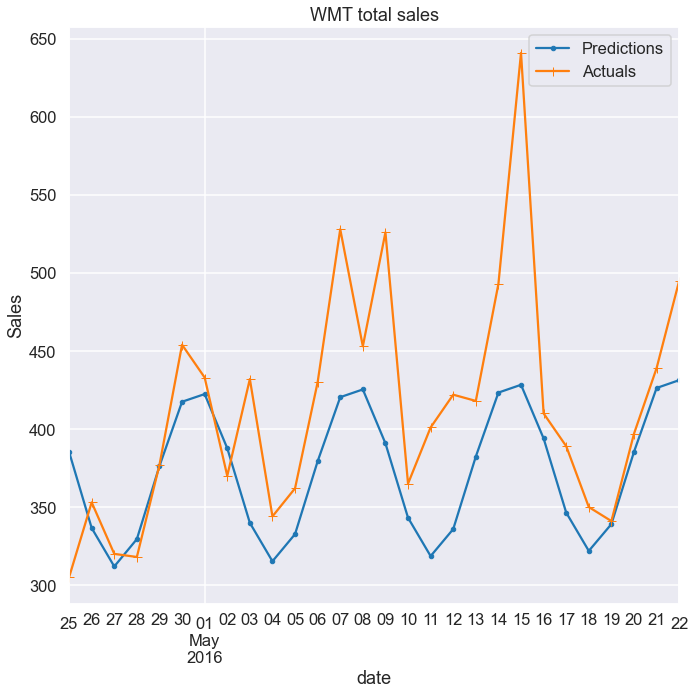

In [160]:
fig,ax = plt.subplots(nrows=1,figsize=[10,10])                   
 
WMT_total_preds.plot(marker=".",ax=ax)
WMT_total_actuals.plot(marker="+",ax=ax)


ax.legend(["Predictions","Actuals"])
ax.set(title="WMT total sales", ylabel="Sales")
    
fig.tight_layout()
plt.show()

In [161]:
# state Level forecast CA

In [162]:
CA_state_total_preds=fcst1.loc[(fcst1.index.get_level_values('state_id')=="CA") 
      &
    (fcst1.index.get_level_values('store_id')=="__total" ) & (fcst1.index.get_level_values('item_id')=="__total")         
     ].reset_index()[["date","unit_sales"]].set_index('date')

CA_state_total_preds

unit_sales
date                  
2016-04-25  154.970210
2016-04-26  132.990162
2016-04-27  120.680713
2016-04-28  127.380472
2016-04-29  148.063430
2016-04-30  167.181841
2016-05-01  170.378546
2016-05-02  155.293385
2016-05-03  133.329881
2016-05-04  121.059814
2016-05-05  127.744481
2016-05-06  148.369279
2016-05-07  167.430277
2016-05-08  170.613534
2016-05-09  155.568976
2016-05-10  133.669518
2016-05-11  121.438709
2016-05-12  128.108316
2016-05-13  148.675116
2016-05-14  167.678873
2016-05-15  170.848733
2016-05-16  155.844670
2016-05-17  134.009073
2016-05-18  121.817399
2016-05-19  128.471976
2016-05-20  148.980941
2016-05-21  167.927628
2016-05-22  171.084142

In [163]:
 CA_state_total_actuals=y_test.reset_index().groupby(['date','state_id'])[["unit_sales"]].\
    sum().reset_index().query('state_id=="CA"')[["date","unit_sales"]].set_index('date')
CA_state_total_actuals

unit_sales
date                  
2016-04-25         123
2016-04-26         149
2016-04-27         129
2016-04-28         139
2016-04-29         147
2016-04-30         205
2016-05-01         178
2016-05-02         162
2016-05-03         167
2016-05-04         150
2016-05-05         138
2016-05-06         165
2016-05-07         207
2016-05-08         200
2016-05-09         231
2016-05-10         140
2016-05-11         162
2016-05-12         161
2016-05-13         153
2016-05-14         186
2016-05-15         263
2016-05-16         163
2016-05-17         145
2016-05-18         136
2016-05-19         138
2016-05-20         154
2016-05-21         155
2016-05-22         226

In [164]:
print("test rmse CA state level: ", round(np.sqrt(mean_squared_error(
   CA_state_total_actuals,CA_state_total_preds)),2),"units")

test rmse CA state level:  32.06 units


In [165]:
# # state Level forecast WI

In [166]:
WI_state_total_preds=fcst1.loc[(fcst1.index.get_level_values('state_id')=="WI") 
      &
    (fcst1.index.get_level_values('store_id')=="__total" ) & (fcst1.index.get_level_values('item_id')=="__total")         
     ].reset_index()[["date","unit_sales"]].set_index('date')

#CA_state_total_actuals



WI_state_total_actuals=y_test.reset_index().groupby(['date','state_id'])[["unit_sales"]].sum().reset_index()\
    .query('state_id=="WI"')[["date","unit_sales"]].set_index('date')
#CA_state_total_preds

print("test rmse WI state level: ", round(np.sqrt(mean_squared_error(
   WI_state_total_actuals,WI_state_total_preds)),2),"units")

test rmse WI state level:  28.14 units


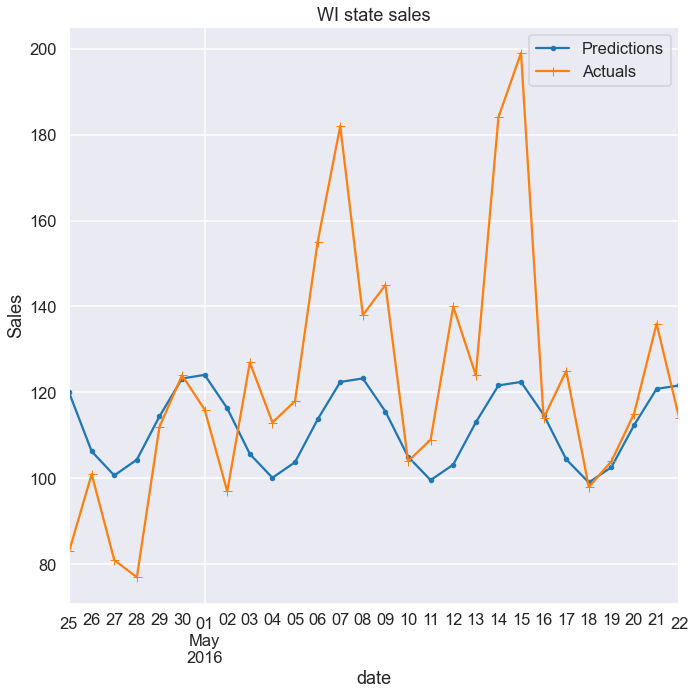

In [167]:

fig,ax = plt.subplots(nrows=1,figsize=[10,10])                   
 
WI_state_total_preds.plot(marker=".",ax=ax)
WI_state_total_actuals.plot(marker="+",ax=ax)


ax.legend(["Predictions","Actuals"])
ax.set(title="WI state sales", ylabel="Sales")
    
fig.tight_layout()
plt.show()

In [168]:
## state Level forecast TX

In [169]:
TX_state_total_preds=fcst1.loc[(fcst1.index.get_level_values('state_id')=="TX") 
      &
    (fcst1.index.get_level_values('store_id')=="__total" ) & (fcst1.index.get_level_values('item_id')=="__total")         
     ].reset_index()[["date","unit_sales"]].set_index('date')

#CA_state_total_actuals



TX_state_total_actuals=y_test.reset_index().groupby(['date','state_id'])[["unit_sales"]].sum().reset_index()\
    .query('state_id=="TX"')[["date","unit_sales"]].set_index('date')
#CA_state_total_preds

print("test rmse WI state level: ", round(np.sqrt(mean_squared_error(
   TX_state_total_actuals,TX_state_total_preds)),2),"units")

test rmse WI state level:  22.46 units


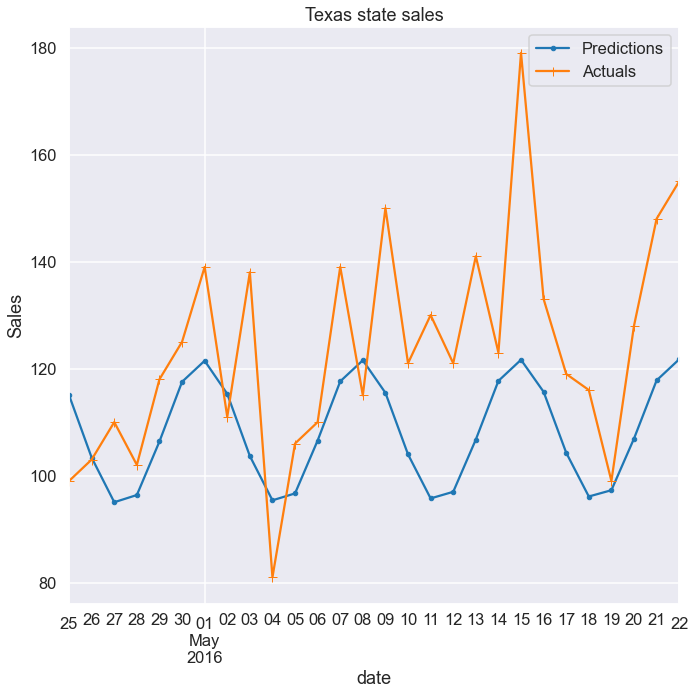

In [170]:

fig,ax = plt.subplots(nrows=1,figsize=[10,10])                   
 
TX_state_total_preds.plot(marker=".",ax=ax)
TX_state_total_actuals.plot(marker="+",ax=ax)


ax.legend(["Predictions","Actuals"])
ax.set(title="Texas state sales", ylabel="Sales")
    
fig.tight_layout()
plt.show()

In [171]:
gc.collect()

34902

In [172]:
y_test

unit_sales  snap  Holidays  \
state_id store_id item_id         date                                     
CA       CA_1     FOODS_1_145     2016-04-25           1     0         0   
                                  2016-04-26           0     0         0   
                                  2016-04-27           0     0         0   
                                  2016-04-28           1     0         0   
                                  2016-04-29           2     0         0   
...                                                  ...   ...       ...   
WI       WI_3     HOUSEHOLD_2_373 2016-05-18           0     0         0   
                                  2016-05-19           0     0         0   
                                  2016-05-20           0     0         0   
                                  2016-05-21           1     0         0   
                                  2016-05-22           0     0         0   

                                              sell_price Inventory_class  \
state_id store_id item_id         date                                     
CA       CA_1     FOODS_1_145     2016-04-25        0.98               B   
                                  2016-04-26        0.98               B   
                                  2016-04-27        0.98               B   
                                  2016-04-28        0.98               B   
                                  2016-04-29        0.98               B   
...                                                  ...             ...   
WI       WI_3     HOUSEHOLD_2_373 2016-05-18        4.66               B   
                                  2016-05-19        4.66               B   
                                  2016-05-20        4.66               B   
                                  2016-05-21        4.66               B   
                                  2016-05-22        4.66               B   

                                              weekend  
state_id store_id item_id         date                 
CA       CA_1     FOODS_1_145     2016-04-25        0  
                                  2016-04-26        0  
                                  2016-04-27        0  
                                  2016-04-28        0  
                                  2016-04-29        0  
...                                               ...  
WI       WI_3     HOUSEHOLD_2_373 2016-05-18        0  
                                  2016-05-19        0  
                                  2016-05-20        0  
                                  2016-05-21        1  
                                  2016-05-22        1  

[8400 rows x 6 columns]

# 4) plotting daily data for CA_3(highest selling store)

### a) Using SARIMAX 

In [173]:
CA_3_total_train=y_train.reset_index().query('store_id=="CA_3"').groupby('date')['unit_sales'].sum().reset_index().set_index('date')
CA_3_total_train.index=pd.to_datetime(CA_3_total_train.index)
CA_3_total_train

unit_sales
date                  
2011-01-29          27
2011-01-30          23
2011-01-31          23
2011-02-01          23
2011-02-02          25
...                ...
2016-04-20          23
2016-04-21          52
2016-04-22          36
2016-04-23          62
2016-04-24          44

[1913 rows x 1 columns]

In [176]:
CA_3_total_test=y_test.reset_index().query('store_id=="CA_3"').groupby('date')['unit_sales'].sum().reset_index().set_index('date')
CA_3_total_test.index=pd.to_datetime(CA_3_total_test.index)
CA_3_total_test

unit_sales
date                  
2016-04-25          32
2016-04-26          55
2016-04-27          36
2016-04-28          29
2016-04-29          44
2016-04-30          61
2016-05-01          58
2016-05-02          63
2016-05-03          51
2016-05-04          39
2016-05-05          49
2016-05-06          52
2016-05-07          63
2016-05-08          70
2016-05-09          68
2016-05-10          42
2016-05-11          62
2016-05-12          67
2016-05-13          49
2016-05-14          47
2016-05-15          74
2016-05-16          49
2016-05-17          42
2016-05-18          43
2016-05-19          49
2016-05-20          49
2016-05-21          31
2016-05-22          69

In [191]:
CA_3_total_weekends_train=y_train.reset_index().query('store_id=="CA_3"').groupby('date')['weekend'].mean().reset_index().set_index('date')
CA_3_total_weekends_train.index=pd.to_datetime(CA_3_total_weekends_train.index)
CA_3_total_weekends_train

weekend
date               
2011-01-29      1.0
2011-01-30      1.0
2011-01-31      0.0
2011-02-01      0.0
2011-02-02      0.0
...             ...
2016-04-20      0.0
2016-04-21      0.0
2016-04-22      0.0
2016-04-23      1.0
2016-04-24      1.0

[1913 rows x 1 columns]

In [192]:
CA_3_total_weekends_test=y_test.reset_index().query('store_id=="CA_3"').groupby('date')['weekend'].mean().reset_index().set_index('date')
CA_3_total_weekends_test.index=pd.to_datetime(CA_3_total_weekends_test.index)
CA_3_total_weekends_test

weekend
date               
2016-04-25      0.0
2016-04-26      0.0
2016-04-27      0.0
2016-04-28      0.0
2016-04-29      0.0
2016-04-30      1.0
2016-05-01      1.0
2016-05-02      0.0
2016-05-03      0.0
2016-05-04      0.0
2016-05-05      0.0
2016-05-06      0.0
2016-05-07      1.0
2016-05-08      1.0
2016-05-09      0.0
2016-05-10      0.0
2016-05-11      0.0
2016-05-12      0.0
2016-05-13      0.0
2016-05-14      1.0
2016-05-15      1.0
2016-05-16      0.0
2016-05-17      0.0
2016-05-18      0.0
2016-05-19      0.0
2016-05-20      0.0
2016-05-21      1.0
2016-05-22      1.0

In [193]:
auto_arima(CA_3_total_train,seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1913
Model:             SARIMAX(4, 1, 1)x(2, 0, 1, 12)   Log Likelihood               -7275.774
Date:                            Sat, 25 Feb 2023   AIC                          14569.548
Time:                                    22:31:03   BIC                          14619.551
Sample:                                         0   HQIC                         14587.950
                                           - 1913                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1716      0.025      6.957      0.000       0.123       0.220
ar.L2          0.0308      0.025      1.248      0.212      -0.018       0.079
ar.L3         -0.0517      0.024     -2.153      0.031      -0.099      -0.005
ar.L4         -0.0572      0.024     -2.404      0.016      -0.104      -0.011
ma.L1         -0.9207      0.012    -76.648      0.000      -0.944      -0.897
ar.S.L12      -0.4013      0.267     -1.502      0.133      -0.925       0.122
ar.S.L24      -0.0861      0.024     -3.623      0.000      -0.133      -0.040
ma.S.L12       0.3526      0.267      1.319      0.187      -0.171       0.877
sigma2       118.1257      3.309     35.698      0.000     111.640     124.611
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                59.90
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [194]:
gc.collect()

404

In [197]:
model_sarimax =SARIMAX(CA_3_total_train,order=(4,1,2),seasonal_order=(2,0,[2],12),exog =CA_3_total_weekends_train)
results = model_sarimax.fit()

C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [198]:
# Obtain predicted values
start=len(CA_3_total_train)
end=len(CA_3_total_train)+len(CA_3_total_test)-1
exog_forecast = CA_3_total_weekends_test
predictions_sarimax =results.predict(start=start, end=end, exog=exog_forecast ).rename('SARIMAX Predictions')



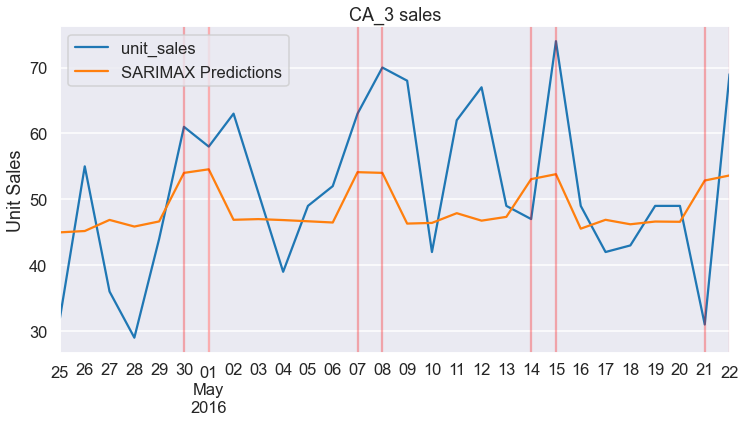

In [199]:
# Plot predictions against known values
title='CA_3 sales'
ylabel='Unit Sales'
xlabel=''

ax = CA_3_total_test.plot(legend=True,figsize=(12,6),title=title)
predictions_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in CA_3_total_weekends_test.query('weekend==1').index: 
    ax.axvline(x=x, color='red', alpha = 0.3);

In [200]:
print("test rmse CA_3 SARIMAX: ", round(np.sqrt(
    mean_squared_error( CA_3_total_test,predictions_sarimax)
),2)
      ,"units")

test rmse CA_3 SARIMAX:  11.59 units


In [201]:
gc.collect()

205

### b) using  Holt-Winters 

In [202]:
model_holt= ExponentialSmoothing(CA_3_total_train,trend='add',seasonal='add',seasonal_periods=12).fit()

C:\Users\ajit2\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [203]:
results_holt = model_holt.predict(start,end).rename('Holt-Winters Predictions')

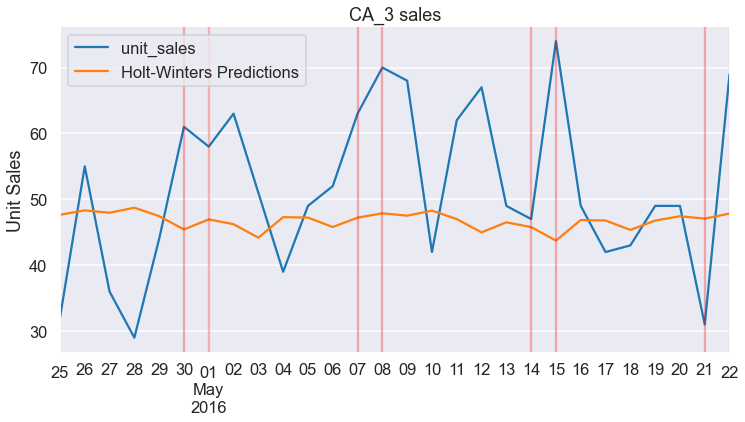

In [208]:
# Plot predictions against known values
title='CA_3 sales'
ylabel='Unit Sales'
xlabel=''

ax = CA_3_total_test.plot(legend=True,figsize=(12,6),title=title)
results_holt.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in CA_3_total_weekends_test.query('weekend==1').index: 
    ax.axvline(x=x, color='red', alpha = 0.3);

In [209]:
print("test rmse holt Winters: ", round(np.sqrt(
    mean_squared_error( CA_3_total_test,results_holt)
),2)
      ,"units")

test rmse holt Winters:  13.65 units


### c) Using FB prophet

In [210]:
# creating a datframe for prophet

In [211]:
CA_3_total_train

unit_sales
date                  
2011-01-29          27
2011-01-30          23
2011-01-31          23
2011-02-01          23
2011-02-02          25
...                ...
2016-04-20          23
2016-04-21          52
2016-04-22          36
2016-04-23          62
2016-04-24          44

[1913 rows x 1 columns]

In [212]:
CA_3_total_train.reset_index(inplace=True)

In [213]:
CA_3_total_train.columns = ['ds','y']

In [214]:
CA_3_total_train['ds'] = pd.to_datetime(CA_3_total_train['ds'],infer_datetime_format=True)

In [215]:
m = Prophet()
m.fit(CA_3_total_train)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (C:\Users\ajit2\anaconda3\lib\site-packages\prophet\stan_model\cmdstan-2.26.1\stan\lib\stan_math\lib\tbb) to PATH
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\ajit2\AppData\Local\Temp\tmp4i9q92tm\snwg0maj.json
DEBUG:cmdstanpy:input tempfile: C:\Users\ajit2\AppData\Local\Temp\tmp4i9q92tm\8tigp_7g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\ajit2\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=62607', 'data', 'file=C:\\Users\\ajit2\\AppData\\Local\\Temp\\tmp4i9q92tm\\snwg0maj.json', 'init=C:\\Users\\ajit2\\AppData\\Local\\Temp\\tmp4i9q92tm\\8tigp_7g.json', 'output', 'file=C:\\Users\\ajit2\\AppData\\Local\\Temp\\tmp4i9q92tm\\prophet_modelqvi78odm\\prophet_model-20230225224213.csv', 'method=optimize', 'al

In [216]:
future = m.make_future_dataframe(periods=28,freq = 'D')

In [217]:
future.tail(28) 

ds
1913 2016-04-25
1914 2016-04-26
1915 2016-04-27
1916 2016-04-28
1917 2016-04-29
1918 2016-04-30
1919 2016-05-01
1920 2016-05-02
1921 2016-05-03
1922 2016-05-04
1923 2016-05-05
1924 2016-05-06
1925 2016-05-07
1926 2016-05-08
1927 2016-05-09
1928 2016-05-10
1929 2016-05-11
1930 2016-05-12
1931 2016-05-13
1932 2016-05-14
1933 2016-05-15
1934 2016-05-16
1935 2016-05-17
1936 2016-05-18
1937 2016-05-19
1938 2016-05-20
1939 2016-05-21
1940 2016-05-22

In [218]:
forecast = m.predict(future)

In [219]:
forecast.tail(28) 

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1913 2016-04-25  51.061833   36.836284   64.879665    51.061833    51.061833   
1914 2016-04-26  51.045917   33.688765   61.093952    51.045917    51.045917   
1915 2016-04-27  51.030002   30.677793   59.223915    51.030002    51.030002   
1916 2016-04-28  51.014086   31.135353   58.518363    51.014086    51.014086   
1917 2016-04-29  50.998171   34.294857   60.724597    50.998171    50.998171   
1918 2016-04-30  50.982255   40.810103   67.303019    50.982255    50.982255   
1919 2016-05-01  50.966340   41.987158   68.461659    50.966340    50.966340   
1920 2016-05-02  50.950425   38.107986   64.871489    50.950425    50.950425   
1921 2016-05-03  50.934509   36.004129   62.324832    50.934509    50.934509   
1922 2016-05-04  50.918594   32.030911   59.330335    50.918594    50.918594   
1923 2016-05-05  50.902678   32.162678   58.805458    50.902678    50.902678   
1924 2016-05-06  50.886763   34.856608   61.780119    50.886763    50.886763   
1925 2016-05-07  50.870847   42.243521   69.050119    50.870847    50.870847   
1926 2016-05-08  50.854932   42.141982   70.267382    50.854932    50.854932   
1927 2016-05-09  50.839017   38.967594   66.079884    50.839017    50.839017   
1928 2016-05-10  50.823101   35.201150   61.686908    50.823101    50.823101   
1929 2016-05-11  50.807186   32.448967   58.151826    50.807186    50.807466   
1930 2016-05-12  50.791270   30.188254   58.433919    50.791158    50.792451   
1931 2016-05-13  50.775355   34.179574   60.961474    50.774924    50.777820   
1932 2016-05-14  50.759439   41.337577   68.234174    50.757252    50.762444   
1933 2016-05-15  50.743524   42.280905   68.889361    50.739706    50.747389   
1934 2016-05-16  50.727609   37.463920   64.327961    50.721957    50.732637   
1935 2016-05-17  50.711693   34.060109   61.732415    50.704852    50.717933   
1936 2016-05-18  50.695778   32.544537   58.593249    50.686943    50.703382   
1937 2016-05-19  50.679862   30.064754   57.762335    50.670328    50.688328   
1938 2016-05-20  50.663947   33.688182   60.858333    50.651351    50.673956   
1939 2016-05-21  50.648031   41.127642   68.053690    50.633518    50.659473   
1940 2016-05-22  50.632116   42.359152   68.941646    50.614610    50.646053   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
1913       -0.511204             -0.511204             -0.511204  1.771182   
1914       -3.550384             -3.550384             -3.550384 -1.448092   
1915       -6.200634             -6.200634             -6.200634 -4.282873   
1916       -6.646121             -6.646121             -6.646121 -4.912781   
1917       -3.554373             -3.554373             -3.554373 -2.000745   
1918        3.451115              3.451115              3.451115  4.834236   
1919        4.813002              4.813002              4.813002  6.039073   
1920        0.684848              0.684848              0.684848  1.771182   
1921       -2.415339             -2.415339             -2.415339 -1.448092   
1922       -5.154376             -5.154376             -5.154376 -4.282873   
1923       -5.713833             -5.713833             -5.713833 -4.912781   
1924       -2.757767             -2.757767             -2.757767 -2.000745   
1925        4.094568              4.094568              4.094568  4.834236   
1926        5.290735              5.290735              5.290735  6.039073   
1927        0.989706              0.989706              0.989706  1.771182   
1928       -2.284739             -2.284739             -2.284739 -1.448092   
1929       -5.193467             -5.193467             -5.193467 -4.282873   
1930       -5.912096             -5.912096             -5.912096 -4.912781   
1931       -3.098913             -3.098913             -3.098913 -2.000745   
1932        3.632236              3.632236              3.632236  4.834236   
1933        4.733788              4.733788            

In [220]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(28)

ds       yhat  yhat_lower  yhat_upper
1913 2016-04-25  50.550628   36.836284   64.879665
1914 2016-04-26  47.495533   33.688765   61.093952
1915 2016-04-27  44.829368   30.677793   59.223915
1916 2016-04-28  44.367965   31.135353   58.518363
1917 2016-04-29  47.443798   34.294857   60.724597
1918 2016-04-30  54.433370   40.810103   67.303019
1919 2016-05-01  55.779342   41.987158   68.461659
1920 2016-05-02  51.635272   38.107986   64.871489
1921 2016-05-03  48.519170   36.004129   62.324832
1922 2016-05-04  45.764218   32.030911   59.330335
1923 2016-05-05  45.188846   32.162678   58.805458
1924 2016-05-06  48.128996   34.856608   61.780119
1925 2016-05-07  54.965416   42.243521   69.050119
1926 2016-05-08  56.145667   42.141982   70.267382
1927 2016-05-09  51.828723   38.967594   66.079884
1928 2016-05-10  48.538362   35.201150   61.686908
1929 2016-05-11  45.613719   32.448967   58.151826
1930 2016-05-12  44.879175   30.188254   58.433919
1931 2016-05-13  47.676442   34.179574   60.961474
1932 2016-05-14  54.391676   41.337577   68.234174
1933 2016-05-15  55.477312   42.280905   68.889361
1934 2016-05-16  51.096506   37.463920   64.327961
1935 2016-05-17  47.776387   34.060109   61.732415
1936 2016-05-18  44.858493   32.544537   58.593249
1937 2016-05-19  44.168575   30.064754   57.762335
1938 2016-05-20  47.048613   33.688182   60.858333
1939 2016-05-21  53.883910   41.127642   68.053690
1940 2016-05-22  55.124923   42.359152   68.941646

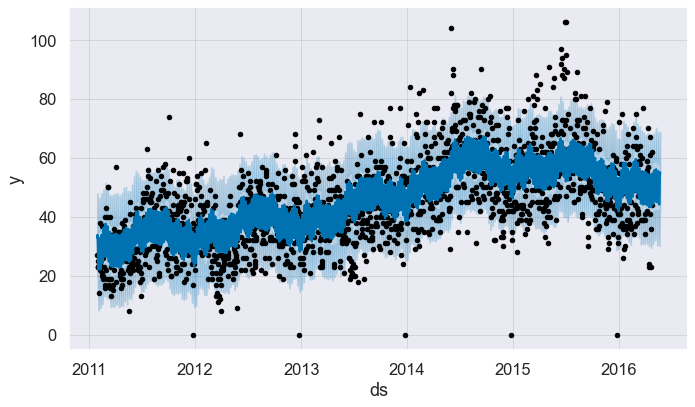

In [221]:
m.plot(forecast);

In [222]:
plotting=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(28)


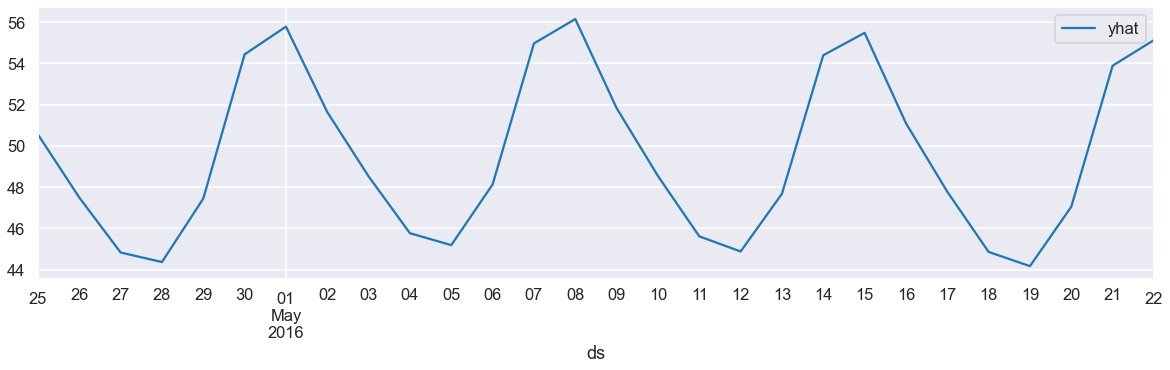

In [223]:
plotting[['ds','yhat']].plot(x='ds',y='yhat',figsize=(20,5));


In [224]:
gc.collect()

30411

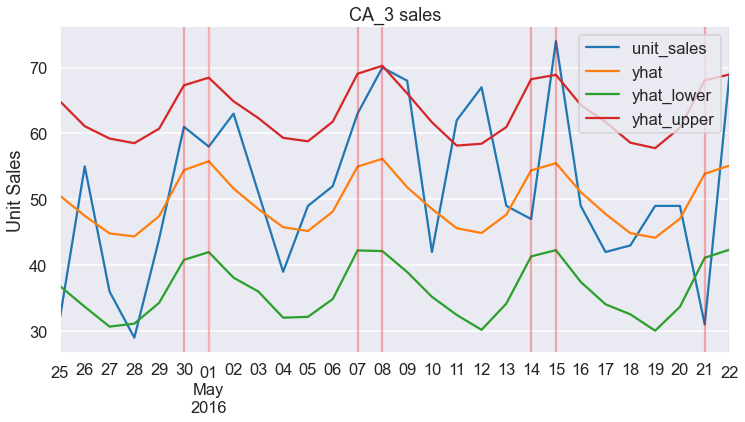

In [228]:
# Plot predictions against known values
title='CA_3 sales'
ylabel='Unit Sales'
xlabel=''

ax = CA_3_total_test.plot(legend=True,figsize=(12,6),title=title)
plotting.plot(x='ds',y=['yhat','yhat_lower','yhat_upper'],legend=True,ax=ax)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in CA_3_total_weekends_test.query('weekend==1').index: 
    ax.axvline(x=x, color='red', alpha = 0.3);

In [229]:
print("test rmse yhat: ", round(np.sqrt(
    mean_squared_error( CA_3_total_test,plotting.yhat)
),2)
      ,"units")

test rmse yhat:  11.16 units


In [230]:
gc.collect()

26641

### 5) Creating Features for Machine Learning

### a) Time Since Feature-F1

In [231]:
#from sktime.transformations.series.time_since import TimeSince


In [232]:
Forecast_ML1.reset_index()

state_id store_id          item_id       date  unit_sales  snap  \
0            CA     CA_1      FOODS_1_145 2011-01-29           0     0   
1            CA     CA_1      FOODS_1_145 2011-01-30           0     0   
2            CA     CA_1      FOODS_1_145 2011-01-31           0     0   
3            CA     CA_1      FOODS_1_145 2011-02-01           0     1   
4            CA     CA_1      FOODS_1_145 2011-02-02           0     1   
...         ...      ...              ...        ...         ...   ...   
582295       WI     WI_3  HOUSEHOLD_2_373 2016-05-18           0     0   
582296       WI     WI_3  HOUSEHOLD_2_373 2016-05-19           0     0   
582297       WI     WI_3  HOUSEHOLD_2_373 2016-05-20           0     0   
582298       WI     WI_3  HOUSEHOLD_2_373 2016-05-21           1     0   
582299       WI     WI_3  HOUSEHOLD_2_373 2016-05-22           0     0   

        Holidays  sell_price Inventory_class  weekend  
0              0         NaN               B        1  
1              0         NaN               B        1  
2              0         NaN               B        0  
3              0         NaN               B        0  
4              0         NaN               B        0  
...          ...         ...             ...      ...  
582295         0        4.66               B        0  
582296         0        4.66               B        0  
582297         0        4.66               B        0  
582298         0        4.66               B        1  
582299         0        4.66               B        1  

[582300 rows x 10 columns]

In [233]:
Forecast_ML12=Forecast_ML1.reset_index().drop(['state_id'],axis=1).set_index(['store_id','item_id','date'])
Forecast_ML12

unit_sales  snap  Holidays  sell_price  \
store_id item_id         date                                                 
CA_1     FOODS_1_145     2011-01-29           0     0         0         NaN   
                         2011-01-30           0     0         0         NaN   
                         2011-01-31           0     0         0         NaN   
                         2011-02-01           0     1         0         NaN   
                         2011-02-02           0     1         0         NaN   
...                                         ...   ...       ...         ...   
WI_3     HOUSEHOLD_2_373 2016-05-18           0     0         0        4.66   
                         2016-05-19           0     0         0        4.66   
                         2016-05-20           0     0         0        4.66   
                         2016-05-21           1     0         0        4.66   
                         2016-05-22           0     0         0        4.66   

                                    Inventory_class  weekend  
store_id item_id         date                                 
CA_1     FOODS_1_145     2011-01-29               B        1  
                         2011-01-30               B        1  
                         2011-01-31               B        0  
                         2011-02-01               B        0  
                         2011-02-02               B        0  
...                                             ...      ...  
WI_3     HOUSEHOLD_2_373 2016-05-18               B        0  
                         2016-05-19               B        0  
                         2016-05-20               B        0  
                         2016-05-21               B        1  
                         2016-05-22               B        1  

[582300 rows x 6 columns]

In [234]:
#Start time for all item_ids
Forecast_ML.reset_index().date.min()

Timestamp('2011-01-29 00:00:00')

In [235]:
transformer = TimeSince(
    start=["2011-01-29"],  # A list of start dates.
    # If `None`, uses earliest time in dataframe.
    to_numeric=True,  # Convert output to integer or keep as time-like.
    # Default is `True`
    freq="D",  # Specify time series frequency if not specified in dataframe.
    # Default is `None` and it is inferred from the dataframe index.
    positive_only=False,  # Set negative values to zero.
    # Default is `False`
    keep_original_columns=False,  # Keep the other columns in the dataframe
    # after passing to `.transform()`.
    # Default is `False`
)

In [236]:
#Forecast_ML1

In [237]:
time_since=transformer.fit_transform(Forecast_ML12[['unit_sales']])

In [238]:
Forecast_ML_F1=pd.concat([Forecast_ML12, time_since], axis=1).reindex(Forecast_ML12.index)
Forecast_ML_F1.head(20)


unit_sales  snap  Holidays  sell_price  \
store_id item_id     date                                                 
CA_1     FOODS_1_145 2011-01-29           0     0         0         NaN   
                     2011-01-30           0     0         0         NaN   
                     2011-01-31           0     0         0         NaN   
                     2011-02-01           0     1         0         NaN   
                     2011-02-02           0     1         0         NaN   
                     2011-02-03           0     1         0         NaN   
                     2011-02-04           0     1         0         NaN   
                     2011-02-05           0     1         0         NaN   
                     2011-02-06           0     1         1         NaN   
                     2011-02-07           0     1         0         NaN   
                     2011-02-08           0     1         0         NaN   
                     2011-02-09           0     1         0         NaN   
                     2011-02-10           0     1         0         NaN   
                     2011-02-11           0     0         0         NaN   
                     2011-02-12           0     0         0         NaN   
                     2011-02-13           0     0         0         NaN   
                     2011-02-14           0     0         1         NaN   
                     2011-02-15           0     0         0         NaN   
                     2011-02-16           0     0         0         NaN   
                     2011-02-17           0     0         0         NaN   

                                Inventory_class  weekend  \
store_id item_id     date                                  
CA_1     FOODS_1_145 2011-01-29               B        1   
                     2011-01-30               B        1   
                     2011-01-31               B        0   
                     2011-02-01               B        0   
                     2011-02-02               B        0   
                     2011-02-03               B        0   
                     2011-02-04               B        0   
                     2011-02-05               B        1   
                     2011-02-06               B        1   
                     2011-02-07               B        0   
                     2011-02-08               B        0   
                     2011-02-09               B        0   
                     2011-02-10               B        0   
                     2011-02-11               B        0   
                     2011-02-12               B        1   
                     2011-02-13               B        1   
                     2011-02-14               B        0   
                     2011-02-15               B        0   
                     2011-02-16               B        0   
                     2011-02-17               B        0   

                                 time_since_2011-01-29 00:00:00  
store_id item_id     date                                        
CA_1     FOODS_1_145 2011-01-29                               0  
                     2011-01-30                               1  
                     2011-01-31                               2  
                     2011-02-01                               3  
                     2011-02-02                               4  
                     2011-02-03                               5  
                     2011-02-04                               6  
                     2011-02-05                               7  
                     2011-02-06                               8  
                     2011-02-07                               9  
                     2011-02-08                              10  
                     2011-02-09                              11  
                     2011-02-10                              12  
                     2011-02-11                              13  
     

In [239]:
gc.collect()

0

### b) Expanding Features- F2

In [240]:
# Exapanding Mean

In [241]:
b2=(Forecast_ML12[['unit_sales']].reset_index().set_index('date').groupby(['store_id',"item_id"])['unit_sales'].expanding().mean()).reset_index().\
rename(columns = {"unit_sales": "unit_sales_expanding_mean"}).set_index(['store_id','item_id','date'])

c2=(b2.reset_index().set_index('date').groupby(['store_id',"item_id"])['unit_sales_expanding_mean'].shift(periods=1, freq="D")).reset_index().\
rename(columns = {"unit_sales_expanding_mean": "unit_sales_expanding_mean_lag_1"}).set_index(['store_id','item_id','date'])

Forecast_ML_F2=pd.concat([Forecast_ML_F1,c2], axis=1).reindex(Forecast_ML12.index)
Forecast_ML_F2

unit_sales  snap  Holidays  sell_price  \
store_id item_id         date                                                 
CA_1     FOODS_1_145     2011-01-29         0.0   0.0       0.0         NaN   
                         2011-01-30         0.0   0.0       0.0         NaN   
                         2011-01-31         0.0   0.0       0.0         NaN   
                         2011-02-01         0.0   1.0       0.0         NaN   
                         2011-02-02         0.0   1.0       0.0         NaN   
...                                         ...   ...       ...         ...   
WI_3     HOUSEHOLD_2_373 2016-05-18         0.0   0.0       0.0        4.66   
                         2016-05-19         0.0   0.0       0.0        4.66   
                         2016-05-20         0.0   0.0       0.0        4.66   
                         2016-05-21         1.0   0.0       0.0        4.66   
                         2016-05-22         0.0   0.0       0.0        4.66   

                                    Inventory_class  weekend  \
store_id item_id         date                                  
CA_1     FOODS_1_145     2011-01-29               B      1.0   
                         2011-01-30               B      1.0   
                         2011-01-31               B      0.0   
                         2011-02-01               B      0.0   
                         2011-02-02               B      0.0   
...                                             ...      ...   
WI_3     HOUSEHOLD_2_373 2016-05-18               B      0.0   
                         2016-05-19               B      0.0   
                         2016-05-20               B      0.0   
                         2016-05-21               B      1.0   
                         2016-05-22               B      1.0   

                                     time_since_2011-01-29 00:00:00  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             0.0   
                         2011-01-30                             1.0   
                         2011-01-31                             2.0   
                         2011-02-01                             3.0   
                         2011-02-02                             4.0   
...                                                             ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                          1936.0   
                         2016-05-19                          1937.0   
                         2016-05-20                          1938.0   
                         2016-05-21                          1939.0   
                         2016-05-22                          1940.0   

                                     unit_sales_expanding_mean_lag_1  
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                              NaN  
                         2011-01-30                         0.000000  
                         2011-01-31                         0.000000  
                         2011-02-01                         0.000000  
                         2011-02-02                         0.000000  
...                                                              ...  
WI_3     HOUSEHOLD_2_373 2016-05-18                         0.146694  
                         2016-05-19                         0.146618  
                         2016-05-20                         0.146543  
                         2016-05-21                         0.146467  
                         2016-05-22                         0.146907  

[582300 rows x 8 columns]

In [242]:
gc.collect()

0

In [243]:
# Exapanding Std

In [244]:
b3=(Forecast_ML1[['unit_sales']].reset_index().set_index('date').groupby(['store_id',"item_id"])['unit_sales'].expanding().std()).reset_index().\
rename(columns = {"unit_sales": "unit_sales_expanding_std"}).set_index(['store_id','item_id','date'])

c3=(b3.reset_index().set_index('date').groupby(['store_id',"item_id"])['unit_sales_expanding_std'].shift(periods=1, freq="D")).reset_index().\
rename(columns = {"unit_sales_expanding_std": "unit_sales_expanding_std_lag_1"}).set_index(['store_id','item_id','date'])

Forecast_ML_F2=pd.concat([Forecast_ML_F2,c3], axis=1).reindex(Forecast_ML12.index)
Forecast_ML_F2

unit_sales  snap  Holidays  sell_price  \
store_id item_id         date                                                 
CA_1     FOODS_1_145     2011-01-29         0.0   0.0       0.0         NaN   
                         2011-01-30         0.0   0.0       0.0         NaN   
                         2011-01-31         0.0   0.0       0.0         NaN   
                         2011-02-01         0.0   1.0       0.0         NaN   
                         2011-02-02         0.0   1.0       0.0         NaN   
...                                         ...   ...       ...         ...   
WI_3     HOUSEHOLD_2_373 2016-05-18         0.0   0.0       0.0        4.66   
                         2016-05-19         0.0   0.0       0.0        4.66   
                         2016-05-20         0.0   0.0       0.0        4.66   
                         2016-05-21         1.0   0.0       0.0        4.66   
                         2016-05-22         0.0   0.0       0.0        4.66   

                                    Inventory_class  weekend  \
store_id item_id         date                                  
CA_1     FOODS_1_145     2011-01-29               B      1.0   
                         2011-01-30               B      1.0   
                         2011-01-31               B      0.0   
                         2011-02-01               B      0.0   
                         2011-02-02               B      0.0   
...                                             ...      ...   
WI_3     HOUSEHOLD_2_373 2016-05-18               B      0.0   
                         2016-05-19               B      0.0   
                         2016-05-20               B      0.0   
                         2016-05-21               B      1.0   
                         2016-05-22               B      1.0   

                                     time_since_2011-01-29 00:00:00  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             0.0   
                         2011-01-30                             1.0   
                         2011-01-31                             2.0   
                         2011-02-01                             3.0   
                         2011-02-02                             4.0   
...                                                             ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                          1936.0   
                         2016-05-19                          1937.0   
                         2016-05-20                          1938.0   
                         2016-05-21                          1939.0   
                         2016-05-22                          1940.0   

                                     unit_sales_expanding_mean_lag_1  \
store_id item_id         date                                          
CA_1     FOODS_1_145     2011-01-29                              NaN   
                         2011-01-30                         0.000000   
                         2011-01-31                         0.000000   
                         2011-02-01                         0.000000   
                         2011-02-02                         0.000000   
...                                                              ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                         0.146694   
                         2016-05-19                         0.146618   
                         2016-05-20                         0.146543   
                         2016-05-21                         0.146467   
                         2016-05-22                         0.146907   

                                     unit_sales_expanding_std_lag_1  
store_id item_id         date                                        
CA_1     FOODS_1_145     2011-01-29                             NaN  
                         2011-01-30                             NaN  
                         2011-01-31

In [245]:
gc.collect()

0

In [246]:
# Exapanding max

In [247]:
b4=(Forecast_ML12[['unit_sales']].reset_index().set_index('date').groupby(['store_id',"item_id"])['unit_sales'].expanding().max()).reset_index().\
rename(columns = {"unit_sales": "unit_sales_expanding_max"}).set_index(['store_id','item_id','date'])

c4=(b4.reset_index().set_index('date').groupby(['store_id',"item_id"])['unit_sales_expanding_max'].shift(periods=1, freq="D")).reset_index().\
rename(columns = {"unit_sales_expanding_max": "unit_sales_expanding_max_lag_1"}).set_index(['store_id','item_id','date'])

Forecast_ML_F2=pd.concat([Forecast_ML_F2,c4], axis=1).reindex(Forecast_ML12.index)
Forecast_ML_F2


unit_sales  snap  Holidays  sell_price  \
store_id item_id         date                                                 
CA_1     FOODS_1_145     2011-01-29         0.0   0.0       0.0         NaN   
                         2011-01-30         0.0   0.0       0.0         NaN   
                         2011-01-31         0.0   0.0       0.0         NaN   
                         2011-02-01         0.0   1.0       0.0         NaN   
                         2011-02-02         0.0   1.0       0.0         NaN   
...                                         ...   ...       ...         ...   
WI_3     HOUSEHOLD_2_373 2016-05-18         0.0   0.0       0.0        4.66   
                         2016-05-19         0.0   0.0       0.0        4.66   
                         2016-05-20         0.0   0.0       0.0        4.66   
                         2016-05-21         1.0   0.0       0.0        4.66   
                         2016-05-22         0.0   0.0       0.0        4.66   

                                    Inventory_class  weekend  \
store_id item_id         date                                  
CA_1     FOODS_1_145     2011-01-29               B      1.0   
                         2011-01-30               B      1.0   
                         2011-01-31               B      0.0   
                         2011-02-01               B      0.0   
                         2011-02-02               B      0.0   
...                                             ...      ...   
WI_3     HOUSEHOLD_2_373 2016-05-18               B      0.0   
                         2016-05-19               B      0.0   
                         2016-05-20               B      0.0   
                         2016-05-21               B      1.0   
                         2016-05-22               B      1.0   

                                     time_since_2011-01-29 00:00:00  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             0.0   
                         2011-01-30                             1.0   
                         2011-01-31                             2.0   
                         2011-02-01                             3.0   
                         2011-02-02                             4.0   
...                                                             ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                          1936.0   
                         2016-05-19                          1937.0   
                         2016-05-20                          1938.0   
                         2016-05-21                          1939.0   
                         2016-05-22                          1940.0   

                                     unit_sales_expanding_mean_lag_1  \
store_id item_id         date                                          
CA_1     FOODS_1_145     2011-01-29                              NaN   
                         2011-01-30                         0.000000   
                         2011-01-31                         0.000000   
                         2011-02-01                         0.000000   
                         2011-02-02                         0.000000   
...                                                              ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                         0.146694   
                         2016-05-19                         0.146618   
                         2016-05-20                         0.146543   
                         2016-05-21                         0.146467   
                         2016-05-22                         0.146907   

                                     unit_sales_expanding_std_lag_1  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             NaN   
                         2011-01-30                             NaN   
                         2011-0

In [248]:
gc.collect()

0

In [249]:
# Exapanding min

In [250]:
b5=(Forecast_ML12[['unit_sales']].reset_index().set_index('date').groupby(['store_id',"item_id"])['unit_sales'].expanding().min()).reset_index().\
rename(columns = {"unit_sales": "unit_sales_expanding_min"}).set_index(['store_id','item_id','date'])

c5=(b5.reset_index().set_index('date').groupby(['store_id',"item_id"])['unit_sales_expanding_min'].shift(periods=1, freq="D")).reset_index().\
rename(columns = {"unit_sales_expanding_min": "unit_sales_expanding_min_lag_1"}).set_index(['store_id','item_id','date'])

Forecast_ML_F2=pd.concat([Forecast_ML_F2,c5], axis=1).reindex(Forecast_ML12.index)
Forecast_ML_F2

unit_sales  snap  Holidays  sell_price  \
store_id item_id         date                                                 
CA_1     FOODS_1_145     2011-01-29         0.0   0.0       0.0         NaN   
                         2011-01-30         0.0   0.0       0.0         NaN   
                         2011-01-31         0.0   0.0       0.0         NaN   
                         2011-02-01         0.0   1.0       0.0         NaN   
                         2011-02-02         0.0   1.0       0.0         NaN   
...                                         ...   ...       ...         ...   
WI_3     HOUSEHOLD_2_373 2016-05-18         0.0   0.0       0.0        4.66   
                         2016-05-19         0.0   0.0       0.0        4.66   
                         2016-05-20         0.0   0.0       0.0        4.66   
                         2016-05-21         1.0   0.0       0.0        4.66   
                         2016-05-22         0.0   0.0       0.0        4.66   

                                    Inventory_class  weekend  \
store_id item_id         date                                  
CA_1     FOODS_1_145     2011-01-29               B      1.0   
                         2011-01-30               B      1.0   
                         2011-01-31               B      0.0   
                         2011-02-01               B      0.0   
                         2011-02-02               B      0.0   
...                                             ...      ...   
WI_3     HOUSEHOLD_2_373 2016-05-18               B      0.0   
                         2016-05-19               B      0.0   
                         2016-05-20               B      0.0   
                         2016-05-21               B      1.0   
                         2016-05-22               B      1.0   

                                     time_since_2011-01-29 00:00:00  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             0.0   
                         2011-01-30                             1.0   
                         2011-01-31                             2.0   
                         2011-02-01                             3.0   
                         2011-02-02                             4.0   
...                                                             ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                          1936.0   
                         2016-05-19                          1937.0   
                         2016-05-20                          1938.0   
                         2016-05-21                          1939.0   
                         2016-05-22                          1940.0   

                                     unit_sales_expanding_mean_lag_1  \
store_id item_id         date                                          
CA_1     FOODS_1_145     2011-01-29                              NaN   
                         2011-01-30                         0.000000   
                         2011-01-31                         0.000000   
                         2011-02-01                         0.000000   
                         2011-02-02                         0.000000   
...                                                              ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                         0.146694   
                         2016-05-19                         0.146618   
                         2016-05-20                         0.146543   
                         2016-05-21                         0.146467   
                         2016-05-22                         0.146907   

                                     unit_sales_expanding_std_lag_1  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             NaN   
                         2011-01-30                             NaN   
                         2011-0

In [251]:
gc.collect()

0

### c) Difference Features - Feature F3

In [252]:
# difference feature of  1 period

In [253]:
# creating difference
b = (
   Forecast_ML12[['unit_sales']].reset_index().set_index('date')
    .groupby(['store_id','item_id'])['unit_sales']
    .diff(periods=1)
).reset_index()
b.rename(columns = {"unit_sales": "sales_diff_1",'date':'date_x'}, inplace = True)

c=pd.concat([Forecast_ML1[['unit_sales']].reset_index(), b], axis=1).drop(columns=['date_x'],axis=1)
c.set_index(['store_id','item_id','date'],inplace=True)

# lagging the difference by 1 period
diff1_lag_1 = (
   c.reset_index().set_index('date')
    .groupby(['store_id','item_id'])['sales_diff_1']
    .shift(periods=1,freq='D')
).reset_index()
diff1_lag_1.rename(columns = {"sales_diff_1": "sales_diff_1_lag_1"}, inplace = True)


diff1_lag_1.set_index(['store_id','item_id','date'],inplace=True)

Forecast_ML_F3=pd.concat([Forecast_ML_F2,diff1_lag_1], axis=1).reindex(Forecast_ML12.index)
Forecast_ML_F3



unit_sales  snap  Holidays  sell_price  \
store_id item_id         date                                                 
CA_1     FOODS_1_145     2011-01-29         0.0   0.0       0.0         NaN   
                         2011-01-30         0.0   0.0       0.0         NaN   
                         2011-01-31         0.0   0.0       0.0         NaN   
                         2011-02-01         0.0   1.0       0.0         NaN   
                         2011-02-02         0.0   1.0       0.0         NaN   
...                                         ...   ...       ...         ...   
WI_3     HOUSEHOLD_2_373 2016-05-18         0.0   0.0       0.0        4.66   
                         2016-05-19         0.0   0.0       0.0        4.66   
                         2016-05-20         0.0   0.0       0.0        4.66   
                         2016-05-21         1.0   0.0       0.0        4.66   
                         2016-05-22         0.0   0.0       0.0        4.66   

                                    Inventory_class  weekend  \
store_id item_id         date                                  
CA_1     FOODS_1_145     2011-01-29               B      1.0   
                         2011-01-30               B      1.0   
                         2011-01-31               B      0.0   
                         2011-02-01               B      0.0   
                         2011-02-02               B      0.0   
...                                             ...      ...   
WI_3     HOUSEHOLD_2_373 2016-05-18               B      0.0   
                         2016-05-19               B      0.0   
                         2016-05-20               B      0.0   
                         2016-05-21               B      1.0   
                         2016-05-22               B      1.0   

                                     time_since_2011-01-29 00:00:00  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             0.0   
                         2011-01-30                             1.0   
                         2011-01-31                             2.0   
                         2011-02-01                             3.0   
                         2011-02-02                             4.0   
...                                                             ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                          1936.0   
                         2016-05-19                          1937.0   
                         2016-05-20                          1938.0   
                         2016-05-21                          1939.0   
                         2016-05-22                          1940.0   

                                     unit_sales_expanding_mean_lag_1  \
store_id item_id         date                                          
CA_1     FOODS_1_145     2011-01-29                              NaN   
                         2011-01-30                         0.000000   
                         2011-01-31                         0.000000   
                         2011-02-01                         0.000000   
                         2011-02-02                         0.000000   
...                                                              ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                         0.146694   
                         2016-05-19                         0.146618   
                         2016-05-20                         0.146543   
                         2016-05-21                         0.146467   
                         2016-05-22                         0.146907   

                                     unit_sales_expanding_std_lag_1  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             NaN   
                         2011-01-30                             NaN   
                         2011-0

In [254]:
gc.collect()

0

In [255]:
# difference feature of  7 periods

In [256]:
# creating difference of 7 period
b = (
   Forecast_ML12[['unit_sales']].reset_index().set_index('date')
    .groupby(['store_id','item_id'])['unit_sales']
    .diff(periods=7)
).reset_index()
b.rename(columns = {"unit_sales": "sales_diff_7",'date':'date_x'}, inplace = True)

c=pd.concat([Forecast_ML1[['unit_sales']].reset_index(), b], axis=1).drop(columns=['date_x'],axis=1)
c.set_index(['store_id','item_id','date'],inplace=True)

# lagging the difference by 1 period
diff7_lag_1 = (
   c.reset_index().set_index('date')
    .groupby(['store_id','item_id'])['sales_diff_7']
    .shift(periods=1,freq='D')
).reset_index()
diff7_lag_1.rename(columns = {"sales_diff_7": "sales_diff_7_lag_1"}, inplace = True)


diff7_lag_1.set_index(['store_id','item_id','date'],inplace=True)
#diff7_lag_1

# concating nating to Forecast_ML
Forecast_ML_F3=pd.concat([Forecast_ML_F3,diff7_lag_1], axis=1).reindex(Forecast_ML12.index)
Forecast_ML_F3

unit_sales  snap  Holidays  sell_price  \
store_id item_id         date                                                 
CA_1     FOODS_1_145     2011-01-29         0.0   0.0       0.0         NaN   
                         2011-01-30         0.0   0.0       0.0         NaN   
                         2011-01-31         0.0   0.0       0.0         NaN   
                         2011-02-01         0.0   1.0       0.0         NaN   
                         2011-02-02         0.0   1.0       0.0         NaN   
...                                         ...   ...       ...         ...   
WI_3     HOUSEHOLD_2_373 2016-05-18         0.0   0.0       0.0        4.66   
                         2016-05-19         0.0   0.0       0.0        4.66   
                         2016-05-20         0.0   0.0       0.0        4.66   
                         2016-05-21         1.0   0.0       0.0        4.66   
                         2016-05-22         0.0   0.0       0.0        4.66   

                                    Inventory_class  weekend  \
store_id item_id         date                                  
CA_1     FOODS_1_145     2011-01-29               B      1.0   
                         2011-01-30               B      1.0   
                         2011-01-31               B      0.0   
                         2011-02-01               B      0.0   
                         2011-02-02               B      0.0   
...                                             ...      ...   
WI_3     HOUSEHOLD_2_373 2016-05-18               B      0.0   
                         2016-05-19               B      0.0   
                         2016-05-20               B      0.0   
                         2016-05-21               B      1.0   
                         2016-05-22               B      1.0   

                                     time_since_2011-01-29 00:00:00  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             0.0   
                         2011-01-30                             1.0   
                         2011-01-31                             2.0   
                         2011-02-01                             3.0   
                         2011-02-02                             4.0   
...                                                             ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                          1936.0   
                         2016-05-19                          1937.0   
                         2016-05-20                          1938.0   
                         2016-05-21                          1939.0   
                         2016-05-22                          1940.0   

                                     unit_sales_expanding_mean_lag_1  \
store_id item_id         date                                          
CA_1     FOODS_1_145     2011-01-29                              NaN   
                         2011-01-30                         0.000000   
                         2011-01-31                         0.000000   
                         2011-02-01                         0.000000   
                         2011-02-02                         0.000000   
...                                                              ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                         0.146694   
                         2016-05-19                         0.146618   
                         2016-05-20                         0.146543   
                         2016-05-21                         0.146467   
                         2016-05-22                         0.146907   

                                     unit_sales_expanding_std_lag_1  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             NaN   
                         2011-01-30                             NaN   
                         2011-0

In [257]:
gc.collect()

0

In [258]:
# difference feature of  14 periods

In [259]:
# creating difference of 14 period
b = (
   Forecast_ML12[['unit_sales']].reset_index().set_index('date')
    .groupby(['store_id','item_id'])['unit_sales']
    .diff(periods=14)
).reset_index()
b.rename(columns = {"unit_sales": "sales_diff_14",'date':'date_x'}, inplace = True)

c=pd.concat([Forecast_ML1[['unit_sales']].reset_index(), b], axis=1).drop(columns=['date_x'],axis=1)
c.set_index(['store_id','item_id','date'],inplace=True)

# lagging the difference by 1 period
diff14_lag_1 = (
   c.reset_index().set_index('date')
    .groupby(['store_id','item_id'])['sales_diff_14']
    .shift(periods=1,freq='D')
).reset_index()
diff14_lag_1.rename(columns = {"sales_diff_14": "sales_diff_14_lag_1"}, inplace = True)


diff14_lag_1.set_index(['store_id','item_id','date'],inplace=True)
#diff14_lag_1

# concating nating to Forecast_ML

# concating nating to Forecast_ML
Forecast_ML_F3=pd.concat([Forecast_ML_F3,diff14_lag_1], axis=1).reindex(Forecast_ML12.index)
Forecast_ML_F3

unit_sales  snap  Holidays  sell_price  \
store_id item_id         date                                                 
CA_1     FOODS_1_145     2011-01-29         0.0   0.0       0.0         NaN   
                         2011-01-30         0.0   0.0       0.0         NaN   
                         2011-01-31         0.0   0.0       0.0         NaN   
                         2011-02-01         0.0   1.0       0.0         NaN   
                         2011-02-02         0.0   1.0       0.0         NaN   
...                                         ...   ...       ...         ...   
WI_3     HOUSEHOLD_2_373 2016-05-18         0.0   0.0       0.0        4.66   
                         2016-05-19         0.0   0.0       0.0        4.66   
                         2016-05-20         0.0   0.0       0.0        4.66   
                         2016-05-21         1.0   0.0       0.0        4.66   
                         2016-05-22         0.0   0.0       0.0        4.66   

                                    Inventory_class  weekend  \
store_id item_id         date                                  
CA_1     FOODS_1_145     2011-01-29               B      1.0   
                         2011-01-30               B      1.0   
                         2011-01-31               B      0.0   
                         2011-02-01               B      0.0   
                         2011-02-02               B      0.0   
...                                             ...      ...   
WI_3     HOUSEHOLD_2_373 2016-05-18               B      0.0   
                         2016-05-19               B      0.0   
                         2016-05-20               B      0.0   
                         2016-05-21               B      1.0   
                         2016-05-22               B      1.0   

                                     time_since_2011-01-29 00:00:00  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             0.0   
                         2011-01-30                             1.0   
                         2011-01-31                             2.0   
                         2011-02-01                             3.0   
                         2011-02-02                             4.0   
...                                                             ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                          1936.0   
                         2016-05-19                          1937.0   
                         2016-05-20                          1938.0   
                         2016-05-21                          1939.0   
                         2016-05-22                          1940.0   

                                     unit_sales_expanding_mean_lag_1  \
store_id item_id         date                                          
CA_1     FOODS_1_145     2011-01-29                              NaN   
                         2011-01-30                         0.000000   
                         2011-01-31                         0.000000   
                         2011-02-01                         0.000000   
                         2011-02-02                         0.000000   
...                                                              ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                         0.146694   
                         2016-05-19                         0.146618   
                         2016-05-20                         0.146543   
                         2016-05-21                         0.146467   
                         2016-05-22                         0.146907   

                                     unit_sales_expanding_std_lag_1  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             NaN   
                         2011-01-30                             NaN   
                         2011-0

In [260]:
gc.collect()

0

In [261]:
# difference feature of  28 periods

In [262]:
# creating difference of 28 periods
b = (
   Forecast_ML12[['unit_sales']].reset_index().set_index('date')
    .groupby(['store_id','item_id'])['unit_sales']
    .diff(periods=28)
).reset_index()
b.rename(columns = {"unit_sales": "sales_diff_28",'date':'date_x'}, inplace = True)

c=pd.concat([Forecast_ML1[['unit_sales']].reset_index(), b], axis=1).drop(columns=['date_x'],axis=1)
c.set_index(['store_id','item_id','date'],inplace=True)

# lagging the difference by 1 period
diff28_lag_1 = (
   c.reset_index().set_index('date')
    .groupby(['store_id','item_id'])['sales_diff_28']
    .shift(periods=1,freq='D')
).reset_index()
diff28_lag_1.rename(columns = {"sales_diff_28": "sales_diff_28_lag_1"}, inplace = True)


diff28_lag_1.set_index(['store_id','item_id','date'],inplace=True)
#diff28_lag_1

# concating nating to Forecast_ML

Forecast_ML_F3=pd.concat([Forecast_ML_F3,diff28_lag_1], axis=1).reindex(Forecast_ML12.index)
Forecast_ML_F3

unit_sales  snap  Holidays  sell_price  \
store_id item_id         date                                                 
CA_1     FOODS_1_145     2011-01-29         0.0   0.0       0.0         NaN   
                         2011-01-30         0.0   0.0       0.0         NaN   
                         2011-01-31         0.0   0.0       0.0         NaN   
                         2011-02-01         0.0   1.0       0.0         NaN   
                         2011-02-02         0.0   1.0       0.0         NaN   
...                                         ...   ...       ...         ...   
WI_3     HOUSEHOLD_2_373 2016-05-18         0.0   0.0       0.0        4.66   
                         2016-05-19         0.0   0.0       0.0        4.66   
                         2016-05-20         0.0   0.0       0.0        4.66   
                         2016-05-21         1.0   0.0       0.0        4.66   
                         2016-05-22         0.0   0.0       0.0        4.66   

                                    Inventory_class  weekend  \
store_id item_id         date                                  
CA_1     FOODS_1_145     2011-01-29               B      1.0   
                         2011-01-30               B      1.0   
                         2011-01-31               B      0.0   
                         2011-02-01               B      0.0   
                         2011-02-02               B      0.0   
...                                             ...      ...   
WI_3     HOUSEHOLD_2_373 2016-05-18               B      0.0   
                         2016-05-19               B      0.0   
                         2016-05-20               B      0.0   
                         2016-05-21               B      1.0   
                         2016-05-22               B      1.0   

                                     time_since_2011-01-29 00:00:00  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             0.0   
                         2011-01-30                             1.0   
                         2011-01-31                             2.0   
                         2011-02-01                             3.0   
                         2011-02-02                             4.0   
...                                                             ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                          1936.0   
                         2016-05-19                          1937.0   
                         2016-05-20                          1938.0   
                         2016-05-21                          1939.0   
                         2016-05-22                          1940.0   

                                     unit_sales_expanding_mean_lag_1  \
store_id item_id         date                                          
CA_1     FOODS_1_145     2011-01-29                              NaN   
                         2011-01-30                         0.000000   
                         2011-01-31                         0.000000   
                         2011-02-01                         0.000000   
                         2011-02-02                         0.000000   
...                                                              ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                         0.146694   
                         2016-05-19                         0.146618   
                         2016-05-20                         0.146543   
                         2016-05-21                         0.146467   
                         2016-05-22                         0.146907   

                                     unit_sales_expanding_std_lag_1  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             NaN   
                         2011-01-30                             NaN   
                         2011-0

In [263]:
gc.collect()

0

### d) Creating Lag and rolling  features - Feature F4

In [264]:
# from sktime.forecasting.base import ForecastingHorizon
# from sktime.forecasting.compose import ForecastingPipeline
# from sktime.transformations.series.summarize import WindowSummarizer

In [265]:
def count_zeros(x):
    """Count how many sales periods have zero."""
    return np.sum((x ==0)[::-1])

def count_gt_zeros(x):
    """Count how many sales periods have greater than zero."""
    return np.sum((x >0)[::-1])

In [266]:
kwargs_lag_rolling = {
    "lag_feature": {
        "lag": [1,7,14,21,28],
        "mean": [[1, 7], [1, 14],[1, 21],[1, 28]],
        "std": [[1, 7], [1, 14],[1, 21],[1, 28]],
        "Max": [[1, 7], [1, 14],[1, 21],[1, 28]],
         "Min": [[1, 7], [1, 14],[1, 21],[1, 28]],
         count_zeros: [[1, 7], [1, 14],[1, 21],[1, 28]],
        count_gt_zeros: [[1, 7], [1, 14],[1, 21],[1, 28]]
    }
}

In [267]:
transformer_lag_rolling = WindowSummarizer(**kwargs_lag_rolling)
lag_and_rolling_feature = transformer_lag_rolling.fit_transform(Forecast_ML12[['unit_sales']])

In [268]:
Forecast_ML_F4=pd.concat([Forecast_ML_F3,lag_and_rolling_feature], axis=1).reindex(Forecast_ML12.index)
Forecast_ML_F4

unit_sales  snap  Holidays  sell_price  \
store_id item_id         date                                                 
CA_1     FOODS_1_145     2011-01-29         0.0   0.0       0.0         NaN   
                         2011-01-30         0.0   0.0       0.0         NaN   
                         2011-01-31         0.0   0.0       0.0         NaN   
                         2011-02-01         0.0   1.0       0.0         NaN   
                         2011-02-02         0.0   1.0       0.0         NaN   
...                                         ...   ...       ...         ...   
WI_3     HOUSEHOLD_2_373 2016-05-18         0.0   0.0       0.0        4.66   
                         2016-05-19         0.0   0.0       0.0        4.66   
                         2016-05-20         0.0   0.0       0.0        4.66   
                         2016-05-21         1.0   0.0       0.0        4.66   
                         2016-05-22         0.0   0.0       0.0        4.66   

                                    Inventory_class  weekend  \
store_id item_id         date                                  
CA_1     FOODS_1_145     2011-01-29               B      1.0   
                         2011-01-30               B      1.0   
                         2011-01-31               B      0.0   
                         2011-02-01               B      0.0   
                         2011-02-02               B      0.0   
...                                             ...      ...   
WI_3     HOUSEHOLD_2_373 2016-05-18               B      0.0   
                         2016-05-19               B      0.0   
                         2016-05-20               B      0.0   
                         2016-05-21               B      1.0   
                         2016-05-22               B      1.0   

                                     time_since_2011-01-29 00:00:00  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             0.0   
                         2011-01-30                             1.0   
                         2011-01-31                             2.0   
                         2011-02-01                             3.0   
                         2011-02-02                             4.0   
...                                                             ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                          1936.0   
                         2016-05-19                          1937.0   
                         2016-05-20                          1938.0   
                         2016-05-21                          1939.0   
                         2016-05-22                          1940.0   

                                     unit_sales_expanding_mean_lag_1  \
store_id item_id         date                                          
CA_1     FOODS_1_145     2011-01-29                              NaN   
                         2011-01-30                         0.000000   
                         2011-01-31                         0.000000   
                         2011-02-01                         0.000000   
                         2011-02-02                         0.000000   
...                                                              ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                         0.146694   
                         2016-05-19                         0.146618   
                         2016-05-20                         0.146543   
                         2016-05-21                         0.146467   
                         2016-05-22                         0.146907   

                                     unit_sales_expanding_std_lag_1  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             NaN   
                         2011-01-30                             NaN   
                         2011-0

In [269]:
gc.collect()

0

### e) Extracting datetime and cyclical Features- Feature F5

In [270]:
datetime_andcyclical_feature_1  = Pipeline([
    
    #create datetime features.
    ('date', DatetimeFeatures(
       variables="date",
       features_to_extract=["day_of_year","week","month",'quarter',"year","day_of_week","day_of_month"
                           ],
       drop_original=False,
    ))
    ]
)

In [271]:
datetime_andcyclical_feature_ext_a=datetime_andcyclical_feature_1.fit_transform(Forecast_ML12[['unit_sales']].reset_index()[['store_id','item_id','date']])
datetime_andcyclical_feature_ext_a.set_index(['store_id','item_id','date'])

date_day_of_year  date_week  date_month  \
store_id item_id         date                                                  
CA_1     FOODS_1_145     2011-01-29                29          4           1   
                         2011-01-30                30          4           1   
                         2011-01-31                31          5           1   
                         2011-02-01                32          5           2   
                         2011-02-02                33          5           2   
...                                               ...        ...         ...   
WI_3     HOUSEHOLD_2_373 2016-05-18               139         20           5   
                         2016-05-19               140         20           5   
                         2016-05-20               141         20           5   
                         2016-05-21               142         20           5   
                         2016-05-22               143         20           5   

                                     date_quarter  date_year  \
store_id item_id         date                                  
CA_1     FOODS_1_145     2011-01-29             1       2011   
                         2011-01-30             1       2011   
                         2011-01-31             1       2011   
                         2011-02-01             1       2011   
                         2011-02-02             1       2011   
...                                           ...        ...   
WI_3     HOUSEHOLD_2_373 2016-05-18             2       2016   
                         2016-05-19             2       2016   
                         2016-05-20             2       2016   
                         2016-05-21             2       2016   
                         2016-05-22             2       2016   

                                     date_day_of_week  date_day_of_month  
store_id item_id         date                                             
CA_1     FOODS_1_145     2011-01-29                 5                 29  
                         2011-01-30                 6                 30  
                         2011-01-31                 0                 31  
                         2011-02-01                 1                  1  
                         2011-02-02                 2                  2  
...                                               ...                ...  
WI_3     HOUSEHOLD_2_373 2016-05-18                 2                 18  
                         2016-05-19                 3                 19  
                         2016-05-20                 4                 20  
                         2016-05-21                 5                 21  
                         2016-05-22                 6                 22  

[582300 rows x 7 columns]

In [272]:
for k in datetime_andcyclical_feature_ext_a\
[['date_day_of_year', 'date_week','date_month', 'date_quarter',  \
  'date_day_of_week','date_day_of_month']].columns:
    datetime_andcyclical_feature_ext_a[f"{k}_hour_sin"] = np.sin(datetime_andcyclical_feature_ext_a[f"{k}"] / datetime_andcyclical_feature_ext_a[f"{k}"].max() * 2 * np.pi)
    datetime_andcyclical_feature_ext_a[f"{k}_hour_cos"] = np.cos(datetime_andcyclical_feature_ext_a[f"{k}"] / datetime_andcyclical_feature_ext_a[f"{k}"].max() * 2 * np.pi)
    

In [273]:
datetime_andcyclical_feature_ext_a.set_index(['store_id','item_id','date'],inplace=True)

In [274]:
gc.collect()

23

In [275]:
Forecast_ML_F5=pd.concat([Forecast_ML_F4,datetime_andcyclical_feature_ext_a], axis=1).reindex(Forecast_ML12.index)
Forecast_ML_F5

unit_sales  snap  Holidays  sell_price  \
store_id item_id         date                                                 
CA_1     FOODS_1_145     2011-01-29         0.0   0.0       0.0         NaN   
                         2011-01-30         0.0   0.0       0.0         NaN   
                         2011-01-31         0.0   0.0       0.0         NaN   
                         2011-02-01         0.0   1.0       0.0         NaN   
                         2011-02-02         0.0   1.0       0.0         NaN   
...                                         ...   ...       ...         ...   
WI_3     HOUSEHOLD_2_373 2016-05-18         0.0   0.0       0.0        4.66   
                         2016-05-19         0.0   0.0       0.0        4.66   
                         2016-05-20         0.0   0.0       0.0        4.66   
                         2016-05-21         1.0   0.0       0.0        4.66   
                         2016-05-22         0.0   0.0       0.0        4.66   

                                    Inventory_class  weekend  \
store_id item_id         date                                  
CA_1     FOODS_1_145     2011-01-29               B      1.0   
                         2011-01-30               B      1.0   
                         2011-01-31               B      0.0   
                         2011-02-01               B      0.0   
                         2011-02-02               B      0.0   
...                                             ...      ...   
WI_3     HOUSEHOLD_2_373 2016-05-18               B      0.0   
                         2016-05-19               B      0.0   
                         2016-05-20               B      0.0   
                         2016-05-21               B      1.0   
                         2016-05-22               B      1.0   

                                     time_since_2011-01-29 00:00:00  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             0.0   
                         2011-01-30                             1.0   
                         2011-01-31                             2.0   
                         2011-02-01                             3.0   
                         2011-02-02                             4.0   
...                                                             ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                          1936.0   
                         2016-05-19                          1937.0   
                         2016-05-20                          1938.0   
                         2016-05-21                          1939.0   
                         2016-05-22                          1940.0   

                                     unit_sales_expanding_mean_lag_1  \
store_id item_id         date                                          
CA_1     FOODS_1_145     2011-01-29                              NaN   
                         2011-01-30                         0.000000   
                         2011-01-31                         0.000000   
                         2011-02-01                         0.000000   
                         2011-02-02                         0.000000   
...                                                              ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                         0.146694   
                         2016-05-19                         0.146618   
                         2016-05-20                         0.146543   
                         2016-05-21                         0.146467   
                         2016-05-22                         0.146907   

                                     unit_sales_expanding_std_lag_1  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             NaN   
                         2011-01-30                             NaN   
                         2011-0

### f) Extracting features from sell price ,snap and holiday, feature - Feature F6

In [276]:
def count_gt0(x):
    """Count how many observations equal 0."""
    return np.sum((x == 0)[::-1])


# kwargs_sales = {
#     "lag_feature": {
#         "lag": [1,7,14,28],
#         count_gt0: [[1, 7],[1, 14],[1, 21],[1, 28]],
#         "std": [[1, 7],[1, 14],[1, 21],[1, 28]],
#         "max":[[1, 7],[1, 14],[1, 21],[1, 28]]
#     }
# }

kwargs_price = {
   "lag_feature": {
        count_gt0: [[1, 7],[1, 14],[1, 21],[1, 28]],
        
        "mean":[[1, 7],[1, 14],[1, 21],[1, 28]]
    }
}
kwargs_snap = {
     "lag_feature": {
        count_gt0: [[1, 7],[1, 14],[1, 21],[1, 28]],
        
        
    }
}

kwargs_holidays = {
    "lag_feature": {
       
        count_gt0: [[1, 7],[1, 14],[1, 21],[1, 28]],
       
    }
}

###  a)F6-Sell prices

In [277]:
sell_prices_dynamics= WindowSummarizer( n_jobs=-1, **kwargs_price, target_cols=["sell_price"])

In [278]:
sell_prices_dynamics_tranformed = sell_prices_dynamics.fit_transform(Forecast_ML12[['sell_price']])
sell_prices_dynamics_tranformed

sell_price_count_gt0_1_7  \
store_id item_id         date                                   
CA_1     FOODS_1_145     2011-01-29                       NaN   
                         2011-01-30                       NaN   
                         2011-01-31                       NaN   
                         2011-02-01                       NaN   
                         2011-02-02                       NaN   
...                                                       ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                       0.0   
                         2016-05-19                       0.0   
                         2016-05-20                       0.0   
                         2016-05-21                       0.0   
                         2016-05-22                       0.0   

                                     sell_price_count_gt0_1_14  \
store_id item_id         date                                    
CA_1     FOODS_1_145     2011-01-29                        NaN   
                         2011-01-30                        NaN   
                         2011-01-31                        NaN   
                         2011-02-01                        NaN   
                         2011-02-02                        NaN   
...                                                        ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                        0.0   
                         2016-05-19                        0.0   
                         2016-05-20                        0.0   
                         2016-05-21                        0.0   
                         2016-05-22                        0.0   

                                     sell_price_count_gt0_1_21  \
store_id item_id         date                                    
CA_1     FOODS_1_145     2011-01-29                        NaN   
                         2011-01-30                        NaN   
                         2011-01-31                        NaN   
                         2011-02-01                        NaN   
                         2011-02-02                        NaN   
...                                                        ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                        0.0   
                         2016-05-19                        0.0   
                         2016-05-20                        0.0   
                         2016-05-21                        0.0   
                         2016-05-22                        0.0   

                                     sell_price_count_gt0_1_28  \
store_id item_id         date                                    
CA_1     FOODS_1_145     2011-01-29                        NaN   
                         2011-01-30                        NaN   
                         2011-01-31                        NaN   
                         2011-02-01                        NaN   
                         2011-02-02                        NaN   
...                                                        ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                        0.0   
                         2016-05-19                        0.0   
                         2016-05-20                        0.0   
                         2016-05-21                        0.0   
                         2016-05-22                        0.0   

                                     sell_price_mean_1_7  \
store_id item_id         date                              
CA_1     FOODS_1_145     2011-01-29                  NaN   
                         2011-01-30                  NaN   
                         2011-01-31                  NaN   
                         2011-02-01                  NaN   
                         2011-02-02                  NaN   
...                                                  ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                 4.66   
                         2016-05-19                 4.66   
              

In [279]:
gc.collect()

0

### b)F6-Snap

In [280]:
snap_dynamics= WindowSummarizer( n_jobs=-1, **kwargs_snap, target_cols=["snap"])

In [281]:
snap_dynamics_tranformed = snap_dynamics.fit_transform(Forecast_ML12[['snap']])
snap_dynamics_tranformed

snap_count_gt0_1_7  snap_count_gt0_1_14  \
store_id item_id         date                                                  
CA_1     FOODS_1_145     2011-01-29                 NaN                  NaN   
                         2011-01-30                 NaN                  NaN   
                         2011-01-31                 NaN                  NaN   
                         2011-02-01                 NaN                  NaN   
                         2011-02-02                 NaN                  NaN   
...                                                 ...                  ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                 3.0                  6.0   
                         2016-05-19                 4.0                  6.0   
                         2016-05-20                 5.0                  7.0   
                         2016-05-21                 5.0                  8.0   
                         2016-05-22                 6.0                  8.0   

                                     snap_count_gt0_1_21  snap_count_gt0_1_28  
store_id item_id         date                                                  
CA_1     FOODS_1_145     2011-01-29                  NaN                  NaN  
                         2011-01-30                  NaN                  NaN  
                         2011-01-31                  NaN                  NaN  
                         2011-02-01                  NaN                  NaN  
                         2011-02-02                  NaN                  NaN  
...                                                  ...                  ...  
WI_3     HOUSEHOLD_2_373 2016-05-18                 11.0                 18.0  
                         2016-05-19                 11.0                 18.0  
                         2016-05-20                 11.0                 18.0  
                         2016-05-21                 11.0                 18.0  
                         2016-05-22                 11.0                 18.0  

[582300 rows x 4 columns]

In [282]:
gc.collect()

0

In [283]:
#snap_dynamics_tranformed.index

### c) F6- Holidays

In [284]:
Holiday_dynamics=WindowSummarizer(
                n_jobs=-1, **kwargs_holidays, target_cols=["Holidays"],
               # truncate="bfill" 
            )

In [285]:
Holiday_dynamics_tranformed = Holiday_dynamics.fit_transform(Forecast_ML12[['Holidays']])
Holiday_dynamics_tranformed

Holidays_count_gt0_1_7  \
store_id item_id         date                                 
CA_1     FOODS_1_145     2011-01-29                     NaN   
                         2011-01-30                     NaN   
                         2011-01-31                     NaN   
                         2011-02-01                     NaN   
                         2011-02-02                     NaN   
...                                                     ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                     7.0   
                         2016-05-19                     7.0   
                         2016-05-20                     7.0   
                         2016-05-21                     7.0   
                         2016-05-22                     7.0   

                                     Holidays_count_gt0_1_14  \
store_id item_id         date                                  
CA_1     FOODS_1_145     2011-01-29                      NaN   
                         2011-01-30                      NaN   
                         2011-01-31                      NaN   
                         2011-02-01                      NaN   
                         2011-02-02                      NaN   
...                                                      ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                     12.0   
                         2016-05-19                     12.0   
                         2016-05-20                     13.0   
                         2016-05-21                     13.0   
                         2016-05-22                     13.0   

                                     Holidays_count_gt0_1_21  \
store_id item_id         date                                  
CA_1     FOODS_1_145     2011-01-29                      NaN   
                         2011-01-30                      NaN   
                         2011-01-31                      NaN   
                         2011-02-01                      NaN   
                         2011-02-02                      NaN   
...                                                      ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                     17.0   
                         2016-05-19                     17.0   
                         2016-05-20                     17.0   
                         2016-05-21                     17.0   
                         2016-05-22                     18.0   

                                     Holidays_count_gt0_1_28  
store_id item_id         date                                 
CA_1     FOODS_1_145     2011-01-29                      NaN  
                         2011-01-30                      NaN  
                         2011-01-31                      NaN  
                         2011-02-01                      NaN  
                         2011-02-02                      NaN  
...                                                      ...  
WI_3     HOUSEHOLD_2_373 2016-05-18                     24.0  
                         2016-05-19                     24.0  
                         2016-05-20                     24.0  
                         2016-05-21                     24.0  
                         2016-05-22                     24.0  

[582300 rows x 4 columns]

In [286]:
gc.collect()

0

### d) F6-Combing price,snap and Holidays with other Features 

In [287]:
Forecast_ML_F6=pd.concat([Forecast_ML_F5,
                          sell_prices_dynamics_tranformed,
                          snap_dynamics_tranformed,
                          Holiday_dynamics_tranformed 
                         ], axis=1).reindex(Forecast_ML12.index)
Forecast_ML_F6

unit_sales  snap  Holidays  sell_price  \
store_id item_id         date                                                 
CA_1     FOODS_1_145     2011-01-29         0.0   0.0       0.0         NaN   
                         2011-01-30         0.0   0.0       0.0         NaN   
                         2011-01-31         0.0   0.0       0.0         NaN   
                         2011-02-01         0.0   1.0       0.0         NaN   
                         2011-02-02         0.0   1.0       0.0         NaN   
...                                         ...   ...       ...         ...   
WI_3     HOUSEHOLD_2_373 2016-05-18         0.0   0.0       0.0        4.66   
                         2016-05-19         0.0   0.0       0.0        4.66   
                         2016-05-20         0.0   0.0       0.0        4.66   
                         2016-05-21         1.0   0.0       0.0        4.66   
                         2016-05-22         0.0   0.0       0.0        4.66   

                                    Inventory_class  weekend  \
store_id item_id         date                                  
CA_1     FOODS_1_145     2011-01-29               B      1.0   
                         2011-01-30               B      1.0   
                         2011-01-31               B      0.0   
                         2011-02-01               B      0.0   
                         2011-02-02               B      0.0   
...                                             ...      ...   
WI_3     HOUSEHOLD_2_373 2016-05-18               B      0.0   
                         2016-05-19               B      0.0   
                         2016-05-20               B      0.0   
                         2016-05-21               B      1.0   
                         2016-05-22               B      1.0   

                                     time_since_2011-01-29 00:00:00  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             0.0   
                         2011-01-30                             1.0   
                         2011-01-31                             2.0   
                         2011-02-01                             3.0   
                         2011-02-02                             4.0   
...                                                             ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                          1936.0   
                         2016-05-19                          1937.0   
                         2016-05-20                          1938.0   
                         2016-05-21                          1939.0   
                         2016-05-22                          1940.0   

                                     unit_sales_expanding_mean_lag_1  \
store_id item_id         date                                          
CA_1     FOODS_1_145     2011-01-29                              NaN   
                         2011-01-30                         0.000000   
                         2011-01-31                         0.000000   
                         2011-02-01                         0.000000   
                         2011-02-02                         0.000000   
...                                                              ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                         0.146694   
                         2016-05-19                         0.146618   
                         2016-05-20                         0.146543   
                         2016-05-21                         0.146467   
                         2016-05-22                         0.146907   

                                     unit_sales_expanding_std_lag_1  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             NaN   
                         2011-01-30                             NaN   
                         2011-0

## 6) Creating the Target columns for direct forecasting (28 days)

In [288]:
for i in range(28):
    Forecast_ML_F6[f'sales_forward_{i+1}_days']=\
    pd.concat([Forecast_ML12[['unit_sales']].reset_index().drop("unit_sales",axis=1),\
    Forecast_ML12[['unit_sales']].reset_index().groupby(['store_id','item_id']).shift(periods=-(i+1))[['unit_sales']]\
                     ], axis=1).set_index(['store_id','item_id','date'])
Forecast_ML_F6

unit_sales  snap  Holidays  sell_price  \
store_id item_id         date                                                 
CA_1     FOODS_1_145     2011-01-29         0.0   0.0       0.0         NaN   
                         2011-01-30         0.0   0.0       0.0         NaN   
                         2011-01-31         0.0   0.0       0.0         NaN   
                         2011-02-01         0.0   1.0       0.0         NaN   
                         2011-02-02         0.0   1.0       0.0         NaN   
...                                         ...   ...       ...         ...   
WI_3     HOUSEHOLD_2_373 2016-05-18         0.0   0.0       0.0        4.66   
                         2016-05-19         0.0   0.0       0.0        4.66   
                         2016-05-20         0.0   0.0       0.0        4.66   
                         2016-05-21         1.0   0.0       0.0        4.66   
                         2016-05-22         0.0   0.0       0.0        4.66   

                                    Inventory_class  weekend  \
store_id item_id         date                                  
CA_1     FOODS_1_145     2011-01-29               B      1.0   
                         2011-01-30               B      1.0   
                         2011-01-31               B      0.0   
                         2011-02-01               B      0.0   
                         2011-02-02               B      0.0   
...                                             ...      ...   
WI_3     HOUSEHOLD_2_373 2016-05-18               B      0.0   
                         2016-05-19               B      0.0   
                         2016-05-20               B      0.0   
                         2016-05-21               B      1.0   
                         2016-05-22               B      1.0   

                                     time_since_2011-01-29 00:00:00  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             0.0   
                         2011-01-30                             1.0   
                         2011-01-31                             2.0   
                         2011-02-01                             3.0   
                         2011-02-02                             4.0   
...                                                             ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                          1936.0   
                         2016-05-19                          1937.0   
                         2016-05-20                          1938.0   
                         2016-05-21                          1939.0   
                         2016-05-22                          1940.0   

                                     unit_sales_expanding_mean_lag_1  \
store_id item_id         date                                          
CA_1     FOODS_1_145     2011-01-29                              NaN   
                         2011-01-30                         0.000000   
                         2011-01-31                         0.000000   
                         2011-02-01                         0.000000   
                         2011-02-02                         0.000000   
...                                                              ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                         0.146694   
                         2016-05-19                         0.146618   
                         2016-05-20                         0.146543   
                         2016-05-21                         0.146467   
                         2016-05-22                         0.146907   

                                     unit_sales_expanding_std_lag_1  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2011-01-29                             NaN   
                         2011-01-30                             NaN   
                         2011-0

In [289]:
# to display columns with new lag variables
Sales_forward= Forecast_ML_F6[[v for v in  Forecast_ML_F6.columns if "forward" in v]]
Sales_forward

sales_forward_1_days  \
store_id item_id         date                               
CA_1     FOODS_1_145     2011-01-29                   0.0   
                         2011-01-30                   0.0   
                         2011-01-31                   0.0   
                         2011-02-01                   0.0   
                         2011-02-02                   0.0   
...                                                   ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                   0.0   
                         2016-05-19                   0.0   
                         2016-05-20                   1.0   
                         2016-05-21                   0.0   
                         2016-05-22                   NaN   

                                     sales_forward_2_days  \
store_id item_id         date                               
CA_1     FOODS_1_145     2011-01-29                   0.0   
                         2011-01-30                   0.0   
                         2011-01-31                   0.0   
                         2011-02-01                   0.0   
                         2011-02-02                   0.0   
...                                                   ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                   0.0   
                         2016-05-19                   1.0   
                         2016-05-20                   0.0   
                         2016-05-21                   NaN   
                         2016-05-22                   NaN   

                                     sales_forward_3_days  \
store_id item_id         date                               
CA_1     FOODS_1_145     2011-01-29                   0.0   
                         2011-01-30                   0.0   
                         2011-01-31                   0.0   
                         2011-02-01                   0.0   
                         2011-02-02                   0.0   
...                                                   ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                   1.0   
                         2016-05-19                   0.0   
                         2016-05-20                   NaN   
                         2016-05-21                   NaN   
                         2016-05-22                   NaN   

                                     sales_forward_4_days  \
store_id item_id         date                               
CA_1     FOODS_1_145     2011-01-29                   0.0   
                         2011-01-30                   0.0   
                         2011-01-31                   0.0   
                         2011-02-01                   0.0   
                         2011-02-02                   0.0   
...                                                   ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                   0.0   
                         2016-05-19                   NaN   
                         2016-05-20                   NaN   
                         2016-05-21                   NaN   
                         2016-05-22                   NaN   

                                     sales_forward_5_days  \
store_id item_id         date                               
CA_1     FOODS_1_145     2011-01-29                   0.0   
                         2011-01-30                   0.0   
                         2011-01-31                   0.0   
                         2011-02-01                   0.0   
                         2011-02-02                   0.0   
...                                                   ...   
WI_3     HOUSEHOLD_2_373 2016-05-18                   NaN   
                         2016-05-19                   NaN   
                         2016-05-20                   NaN   
                         2016-05-21                   NaN   
                         2016-05-22                   NaN   

                                     sales_forward_6_days  \
store_

In [290]:
gc.collect()

0

We can see the newly created features at the end of the dataframe.

## 7)Dropping missing data

When creating lag and window features, we introduced missing data. 

In [291]:
# Determine fraction of missing data.

missing=pd.DataFrame(Forecast_ML_F6.isnull().sum() / len(Forecast_ML_F6),columns=['percentage of zero'])
missing.sort_values(by=['percentage of zero'],ascending=False)

percentage of zero
sell_price_count_gt0_1_28            0.232239
sell_price_mean_1_28                 0.232239
sell_price_mean_1_21                 0.228633
sell_price_count_gt0_1_21            0.228633
sell_price_count_gt0_1_14            0.225027
...                                       ...
date_quarter_hour_sin                0.000000
date_quarter_hour_cos                0.000000
date_day_of_week_hour_sin            0.000000
date_day_of_week_hour_cos            0.000000
date_week_hour_sin                   0.000000

[107 rows x 1 columns]

In [292]:
#Forecast_ML_F6.reset_index().to_excel("MLforecast.xlsx")

In [293]:
gc.collect()

0

In [294]:
gc.collect()

0

In [295]:
# dropping NA values

In [296]:
Forecast_ML_for_X_y=Forecast_ML_F6.drop(['unit_sales','Inventory_class'],axis=1).dropna()

In [297]:
#https://stackoverflow.com/questions/32032836/select-everything-but-a-list-of-columns-from-pandas-dataframe

In [298]:
#Forecast_ML_F6[Forecast_ML_F6.columns[~Forecast_ML_F6.columns.isin([v for v in  Forecast_ML_F6.columns if "forward" in v])]]

In [299]:
Forecast_ML_for_X_y.index.get_level_values('date').min(), Forecast_ML_for_X_y.index.get_level_values('date').max()

(Timestamp('2011-02-27 00:00:00'), Timestamp('2016-04-24 00:00:00'))

In [300]:
X=Forecast_ML_for_X_y[Forecast_ML_for_X_y.columns\
                    [~Forecast_ML_for_X_y.columns.isin([v for v in  Forecast_ML_for_X_y.columns if "forward" in v])]]
X

snap  Holidays  sell_price  weekend  \
store_id item_id         date                                              
CA_1     FOODS_1_145     2013-07-27   0.0       0.0        0.98      1.0   
                         2013-07-28   0.0       0.0        0.98      1.0   
                         2013-07-29   0.0       0.0        0.98      0.0   
                         2013-07-30   0.0       0.0        0.98      0.0   
                         2013-07-31   0.0       0.0        0.98      0.0   
...                                   ...       ...         ...      ...   
WI_3     HOUSEHOLD_2_373 2016-04-20   0.0       0.0        4.66      0.0   
                         2016-04-21   0.0       0.0        4.66      0.0   
                         2016-04-22   0.0       0.0        4.66      0.0   
                         2016-04-23   0.0       0.0        4.66      1.0   
                         2016-04-24   0.0       0.0        4.66      1.0   

                                     time_since_2011-01-29 00:00:00  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2013-07-27                           910.0   
                         2013-07-28                           911.0   
                         2013-07-29                           912.0   
                         2013-07-30                           913.0   
                         2013-07-31                           914.0   
...                                                             ...   
WI_3     HOUSEHOLD_2_373 2016-04-20                          1908.0   
                         2016-04-21                          1909.0   
                         2016-04-22                          1910.0   
                         2016-04-23                          1911.0   
                         2016-04-24                          1912.0   

                                     unit_sales_expanding_mean_lag_1  \
store_id item_id         date                                          
CA_1     FOODS_1_145     2013-07-27                         0.084615   
                         2013-07-28                         0.086718   
                         2013-07-29                         0.086623   
                         2013-07-30                         0.089814   
                         2013-07-31                         0.091904   
...                                                              ...   
WI_3     HOUSEHOLD_2_373 2016-04-20                         0.146226   
                         2016-04-21                         0.146150   
                         2016-04-22                         0.146073   
                         2016-04-23                         0.145997   
                         2016-04-24                         0.145921   

                                     unit_sales_expanding_std_lag_1  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2013-07-27                        0.653740   
                         2013-07-28                        0.656455   
                         2013-07-29                        0.656101   
                         2013-07-30                        0.662792   
                         2013-07-31                        0.665435   
...                                                             ...   
WI_3     HOUSEHOLD_2_373 2016-04-20                        0.409767   
                         2016-04-21                        0.409674   
                         2016-04-22                        0.409580   
                         2016-04-23                        0.409486   
                         2016-04-24                        0.409393   

                                     unit_sales_expanding_max_lag_1  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2013-07-27                            12.0   
                         2013-07-28               

In [301]:
X.index.get_level_values('date').min(), X.index.get_level_values('date').max()

(Timestamp('2011-02-27 00:00:00'), Timestamp('2016-04-24 00:00:00'))

In [302]:
y=Forecast_ML_for_X_y[[v for v in  Forecast_ML_for_X_y.columns if "forward" in v]]
y

sales_forward_1_days  \
store_id item_id         date                               
CA_1     FOODS_1_145     2013-07-27                   0.0   
                         2013-07-28                   3.0   
                         2013-07-29                   2.0   
                         2013-07-30                   1.0   
                         2013-07-31                   9.0   
...                                                   ...   
WI_3     HOUSEHOLD_2_373 2016-04-20                   0.0   
                         2016-04-21                   0.0   
                         2016-04-22                   0.0   
                         2016-04-23                   0.0   
                         2016-04-24                   0.0   

                                     sales_forward_2_days  \
store_id item_id         date                               
CA_1     FOODS_1_145     2013-07-27                   3.0   
                         2013-07-28                   2.0   
                         2013-07-29                   1.0   
                         2013-07-30                   9.0   
                         2013-07-31                   0.0   
...                                                   ...   
WI_3     HOUSEHOLD_2_373 2016-04-20                   0.0   
                         2016-04-21                   0.0   
                         2016-04-22                   0.0   
                         2016-04-23                   0.0   
                         2016-04-24                   0.0   

                                     sales_forward_3_days  \
store_id item_id         date                               
CA_1     FOODS_1_145     2013-07-27                   2.0   
                         2013-07-28                   1.0   
                         2013-07-29                   9.0   
                         2013-07-30                   0.0   
                         2013-07-31                   1.0   
...                                                   ...   
WI_3     HOUSEHOLD_2_373 2016-04-20                   0.0   
                         2016-04-21                   0.0   
                         2016-04-22                   0.0   
                         2016-04-23                   0.0   
                         2016-04-24                   0.0   

                                     sales_forward_4_days  \
store_id item_id         date                               
CA_1     FOODS_1_145     2013-07-27                   1.0   
                         2013-07-28                   9.0   
                         2013-07-29                   0.0   
                         2013-07-30                   1.0   
                         2013-07-31                   2.0   
...                                                   ...   
WI_3     HOUSEHOLD_2_373 2016-04-20                   0.0   
                         2016-04-21                   0.0   
                         2016-04-22                   0.0   
                         2016-04-23                   0.0   
                         2016-04-24                   0.0   

                                     sales_forward_5_days  \
store_id item_id         date                               
CA_1     FOODS_1_145     2013-07-27                   9.0   
                         2013-07-28                   0.0   
                         2013-07-29                   1.0   
                         2013-07-30                   2.0   
                         2013-07-31                   0.0   
...                                                   ...   
WI_3     HOUSEHOLD_2_373 2016-04-20                   0.0   
                         2016-04-21                   0.0   
                         2016-04-22                   0.0   
                         2016-04-23                   0.0   
                         2016-04-24                   0.0   

                                     sales_forward_6_days  \
store_

In [303]:
y.index.get_level_values('date').min(), y.index.get_level_values('date').max()

(Timestamp('2011-02-27 00:00:00'), Timestamp('2016-04-24 00:00:00'))

In [304]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X,test_size=28)

In [305]:
X_train.shape, X_test.shape

((273817, 77), (6629, 77))

In [306]:
X_train.index.get_level_values('date').min(), X_train.index.get_level_values('date').max()

(Timestamp('2011-02-27 00:00:00'), Timestamp('2016-04-24 00:00:00'))

In [307]:
X_test.index.get_level_values('date').min(), X_test.index.get_level_values('date').max()

(Timestamp('2013-10-29 00:00:00'), Timestamp('2016-04-24 00:00:00'))

In [308]:
y_train.shape, y_test.shape

((273817, 28), (6629, 28))

In [309]:
y_test.index.get_level_values('date').min(), y_test.index.get_level_values('date').max()

(Timestamp('2013-10-29 00:00:00'), Timestamp('2016-04-24 00:00:00'))

In [310]:
gc.collect()

0

## 8) Naive Forecast
We will predict the sales at time t with its value at time t-1.

We will use this model as a benchmark.

In [311]:
Naive_forecast_DF=Forecast_ML_F6[['sales_forward_1_days','unit_sales_lag_1']].dropna()

In [312]:
X_train_naive=Naive_forecast_DF[['unit_sales_lag_1']].query('date <= "2016-04-24"')
X_test_naive=Naive_forecast_DF[['unit_sales_lag_1']].query('date> "2016-04-24"')

In [313]:
y_train_naive=Naive_forecast_DF[['sales_forward_1_days']].query('date <= "2016-04-24"')
y_test_naive=Naive_forecast_DF[['sales_forward_1_days']].query('date> "2016-04-24"')

In [314]:
# Performance of naive forecast

print("train rmse: ", round(np.sqrt(mean_squared_error(
   y_train_naive,X_train_naive)),2),"units")

print("test rmse: ", round(np.sqrt(mean_squared_error(
    y_test_naive, X_test_naive)),2),"units")

print("train avg sales",round(X_train_naive.mean(),2) ,"units")

print("test avg sales ",round(X_test_naive.mean(),2) ,"units")

train rmse:  2.02 units
test rmse:  2.35 units
train avg sales unit_sales_lag_1    0.99
dtype: float64 units
test avg sales  unit_sales_lag_1    1.37
dtype: float64 units


In [315]:
#WMAPE: https://en.wikipedia.org/wiki/WMAPE

In [316]:
# def wmape(y_true, y_pred):
#     return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [317]:
# y_pred_naive = X_train["unit_sales"]
# y_true = y_train

In [318]:
# wmape(y_true_naive, y_pred_naive)

In [319]:
X_train.columns

Index(['snap', 'Holidays', 'sell_price', 'weekend',
       'time_since_2011-01-29 00:00:00', 'unit_sales_expanding_mean_lag_1',
       'unit_sales_expanding_std_lag_1', 'unit_sales_expanding_max_lag_1',
       'unit_sales_expanding_min_lag_1', 'sales_diff_1_lag_1',
       'sales_diff_7_lag_1', 'sales_diff_14_lag_1', 'sales_diff_28_lag_1',
       'unit_sales_lag_1', 'unit_sales_lag_14', 'unit_sales_lag_21',
       'unit_sales_lag_7', 'unit_sales_lag_28', 'unit_sales_mean_1_28',
       'unit_sales_mean_1_21', 'unit_sales_mean_1_14', 'unit_sales_mean_1_7',
       'unit_sales_std_1_14', 'unit_sales_std_1_28', 'unit_sales_std_1_7',
       'unit_sales_std_1_21', 'unit_sales_Max_1_28', 'unit_sales_Max_1_21',
       'unit_sales_Max_1_7', 'unit_sales_Max_1_14', 'unit_sales_Min_1_21',
       'unit_sales_Min_1_7', 'unit_sales_Min_1_14', 'unit_sales_Min_1_28',
       'unit_sales_count_zeros_1_7', 'unit_sales_count_zeros_1_28',
       'unit_sales_count_zeros_1_14', 'unit_sales_count_zeros_1_21',
  

In [320]:
gc.collect()

0

In [321]:
y_train_naive

sales_forward_1_days
store_id item_id         date                            
CA_1     FOODS_1_145     2011-01-30                   0.0
                         2011-01-31                   0.0
                         2011-02-01                   0.0
                         2011-02-02                   0.0
                         2011-02-03                   0.0
...                                                   ...
WI_3     HOUSEHOLD_2_373 2016-04-20                   0.0
                         2016-04-21                   0.0
                         2016-04-22                   0.0
                         2016-04-23                   0.0
                         2016-04-24                   0.0

[573600 rows x 1 columns]

In [322]:
X_train_naive

unit_sales_lag_1
store_id item_id         date                        
CA_1     FOODS_1_145     2011-01-30               0.0
                         2011-01-31               0.0
                         2011-02-01               0.0
                         2011-02-02               0.0
                         2011-02-03               0.0
...                                               ...
WI_3     HOUSEHOLD_2_373 2016-04-20               0.0
                         2016-04-21               0.0
                         2016-04-22               0.0
                         2016-04-23               0.0
                         2016-04-24               0.0

[573600 rows x 1 columns]

In [323]:
gc.collect()

0

## 9) Important Feature selection using Ridge

In [552]:
df_feature_selection=Forecast_ML_F6.iloc[:,:80].drop(['unit_sales','Inventory_class'],axis=1).dropna()

In [553]:
#linear_model =Lasso(alpha=0.01, random_state=0)

In [563]:
#df_feature_selection.iloc[:,:-1].columns

In [564]:
#df_feature_selection.iloc[:,-1:]

In [556]:
scaler1=MinMaxScaler()

In [557]:
X_train_scaled1=scaler1.fit_transform(df_feature_selection.iloc[:,:-1])

In [565]:
#X_train_scaled1

In [589]:
#linear_model.fit(X_train_scaled1, df_feature_selection.iloc[:,-1:])

In [584]:
#linear_model.coef_.T

In [588]:
# # Let's now plot the feature's importance
# # according to the linear model.

# # Create series with feature importance.
# tmp =pd.DataFrame(data=np.abs(linear_model.coef_.T),index = df_feature_selection.iloc[:,:-1].columns,columns=['Features']) 
# fig, ax = plt.subplots(figsize=[24, 20])
# tmp.sort_values(by=['Features']).tail(8).plot.bar(figsize=(15, 6),ax=ax)
# ax.set_title("Feature importance")
# ax.set_xlabel("Feature Name")
# ax.set_ylabel("Importance");


In [585]:
clf = Ridge(alpha=100)

In [586]:
clf.fit(X_train_scaled1, df_feature_selection.iloc[:,-1:])

Ridge(alpha=100)

In [580]:
#clf.coef_.T

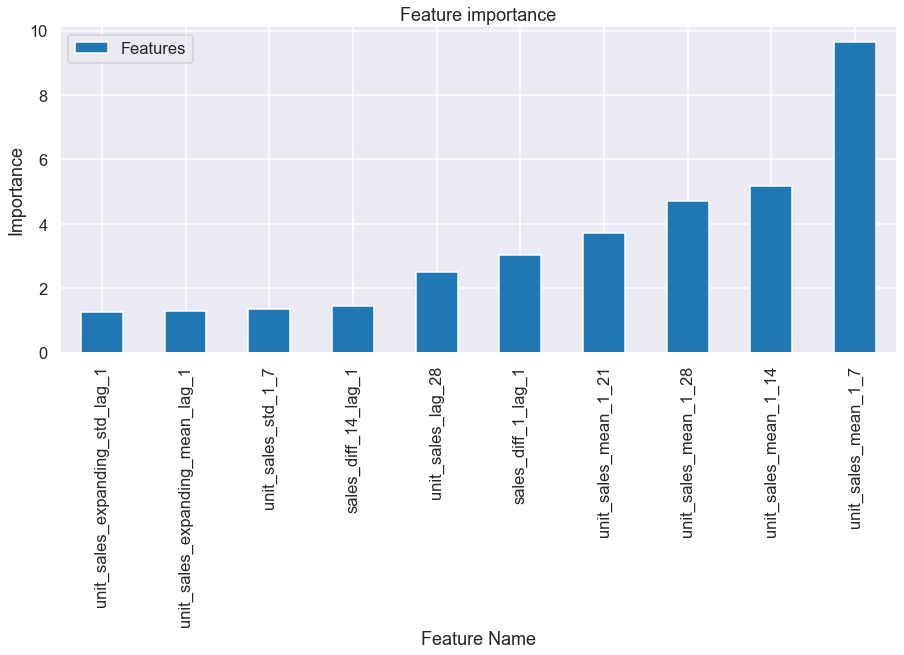

In [587]:
# Let's now plot the feature's importance
# according to the linear model.

# Create series with feature importance.
tmp =pd.DataFrame(data=np.abs(clf.coef_.T),index = df_feature_selection.iloc[:,:-1].columns,columns=['Features']) 
fig, ax = plt.subplots(figsize=[24, 20])
tmp.sort_values(by=['Features']).tail(10).plot.bar(figsize=(15, 6),ax=ax)
ax.set_title("Feature importance")
ax.set_xlabel("Feature Name")
ax.set_ylabel("Importance");

In [330]:
gc.collect()

10079

In [562]:
#gc.collect()

## 10) ML Time series forecasting using Lasso  - Direct forecast of the next 28 days

In [332]:
# The first hour of forecast.

data_start = pd.Timestamp("2016-04-24")

In [333]:
# The last hour of forecast (24hs before the last
# timestamp in the test set).

data_end = data_start+pd.DateOffset(days=28)

data_end

Timestamp('2016-05-22 00:00:00')

In [334]:
#start_point = forecast_point - pd.DateOffset(days=1)

In [335]:
# Each one of the forecasting start points.

forecasting_points = pd.date_range(start=data_start, end=data_end, freq="D")

print(len(forecasting_points))

forecasting_points

29


DatetimeIndex(['2016-04-24', '2016-04-25', '2016-04-26', '2016-04-27',
               '2016-04-28', '2016-04-29', '2016-04-30', '2016-05-01',
               '2016-05-02', '2016-05-03', '2016-05-04', '2016-05-05',
               '2016-05-06', '2016-05-07', '2016-05-08', '2016-05-09',
               '2016-05-10', '2016-05-11', '2016-05-12', '2016-05-13',
               '2016-05-14', '2016-05-15', '2016-05-16', '2016-05-17',
               '2016-05-18', '2016-05-19', '2016-05-20', '2016-05-21',
               '2016-05-22'],
              dtype='datetime64[ns]', freq='D')

In [336]:
for forecast_point in forecasting_points:
    forecast_end = forecast_point + pd.DateOffset(days=1)
    index = pd.date_range(start=forecast_point, end=forecast_end,freq="D")
    print(index)

DatetimeIndex(['2016-04-24', '2016-04-25'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-04-25', '2016-04-26'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-04-26', '2016-04-27'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-04-27', '2016-04-28'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-04-28', '2016-04-29'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-04-29', '2016-04-30'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-04-30', '2016-05-01'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-05-01', '2016-05-02'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-05-02', '2016-05-03'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-05-03', '2016-05-04'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-05-04', '2016-05-05'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-05-05', '2016-05-06'], dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2016-05-06', '2016-05-07'], dtype='datetime64[ns

In [337]:
gc.collect()

0

## Direct forecasting

In [338]:
gc.collect()

0

In [339]:
gc.collect()

0

In [340]:
lasso = MultiOutputRegressor(Lasso(random_state=0, max_iter=50000))

In [341]:
def roundToHalf(array):
   return np.around(array * 2.0) / 2.0

In [342]:
X_train

snap  Holidays  sell_price  weekend  \
store_id item_id         date                                              
CA_1     FOODS_1_145     2013-07-27   0.0       0.0        0.98      1.0   
                         2013-07-28   0.0       0.0        0.98      1.0   
                         2013-07-29   0.0       0.0        0.98      0.0   
                         2013-07-30   0.0       0.0        0.98      0.0   
                         2013-07-31   0.0       0.0        0.98      0.0   
...                                   ...       ...         ...      ...   
WI_3     HOUSEHOLD_2_373 2013-10-24   0.0       0.0        4.67      0.0   
                         2013-10-25   0.0       0.0        4.67      0.0   
                         2013-10-26   0.0       0.0        4.67      1.0   
                         2013-10-27   0.0       0.0        4.67      1.0   
                         2013-10-28   0.0       0.0        4.67      0.0   

                                     time_since_2011-01-29 00:00:00  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2013-07-27                           910.0   
                         2013-07-28                           911.0   
                         2013-07-29                           912.0   
                         2013-07-30                           913.0   
                         2013-07-31                           914.0   
...                                                             ...   
WI_3     HOUSEHOLD_2_373 2013-10-24                           999.0   
                         2013-10-25                          1000.0   
                         2013-10-26                          1001.0   
                         2013-10-27                          1002.0   
                         2013-10-28                          1003.0   

                                     unit_sales_expanding_mean_lag_1  \
store_id item_id         date                                          
CA_1     FOODS_1_145     2013-07-27                         0.084615   
                         2013-07-28                         0.086718   
                         2013-07-29                         0.086623   
                         2013-07-30                         0.089814   
                         2013-07-31                         0.091904   
...                                                              ...   
WI_3     HOUSEHOLD_2_373 2013-10-24                         0.186186   
                         2013-10-25                         0.186000   
                         2013-10-26                         0.185814   
                         2013-10-27                         0.185629   
                         2013-10-28                         0.187438   

                                     unit_sales_expanding_std_lag_1  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2013-07-27                        0.653740   
                         2013-07-28                        0.656455   
                         2013-07-29                        0.656101   
                         2013-07-30                        0.662792   
                         2013-07-31                        0.665435   
...                                                             ...   
WI_3     HOUSEHOLD_2_373 2013-10-24                        0.462382   
                         2013-10-25                        0.462188   
                         2013-10-26                        0.461994   
                         2013-10-27                        0.461801   
                         2013-10-28                        0.465112   

                                     unit_sales_expanding_max_lag_1  \
store_id item_id         date                                         
CA_1     FOODS_1_145     2013-07-27                            12.0   
                         2013-07-28               

In [343]:
scaler=MinMaxScaler()

In [344]:
X_train_scaled=scaler.fit_transform(X_train)

In [345]:
lasso.fit(X_train_scaled, y_train)

MultiOutputRegressor(estimator=Lasso(max_iter=50000, random_state=0))

In [346]:
# Make predictions

preds_28 = np.abs(lasso.predict(X_test))

In [347]:
preds_28 = pd.DataFrame(preds_28, columns=y_test.columns)

preds_28 

sales_forward_1_days  sales_forward_2_days  sales_forward_3_days  \
0                 1.233674              1.233536              1.233313   
1                 1.233674              1.233536              1.233313   
2                 1.233674              1.233536              1.233313   
3                 1.233674              1.233536              1.233313   
4                 1.233674              1.233536              1.233313   
...                    ...                   ...                   ...   
6624              1.233674              1.233536              1.233313   
6625              1.233674              1.233536              1.233313   
6626              1.233674              1.233536              1.233313   
6627              1.233674              1.233536              1.233313   
6628              1.233674              1.233536              1.233313   

      sales_forward_4_days  sales_forward_5_days  sales_forward_6_days  \
0                 1.233452               1.23347              1.233806   
1                 1.233452               1.23347              1.233806   
2                 1.233452               1.23347              1.233806   
3                 1.233452               1.23347              1.233806   
4                 1.233452               1.23347              1.233806   
...                    ...                   ...                   ...   
6624              1.233452               1.23347              1.233806   
6625              1.233452               1.23347              1.233806   
6626              1.233452               1.23347              1.233806   
6627              1.233452               1.23347              1.233806   
6628              1.233452               1.23347              1.233806   

      sales_forward_7_days  sales_forward_8_days  sales_forward_9_days  \
0                 1.233473              1.233262              1.233083   
1                 1.233473              1.233262              1.233083   
2                 1.233473              1.233262              1.233083   
3                 1.233473              1.233262              1.233083   
4                 1.233473              1.233262              1.233083   
...                    ...                   ...                   ...   
6624              1.233473              1.233262              1.233083   
6625              1.233473              1.233262              1.233083   
6626              1.233473              1.233262              1.233083   
6627              1.233473              1.233262              1.233083   
6628              1.233473              1.233262              1.233083   

      sales_forward_10_days  ...  sales_forward_19_days  \
0                  1.232933  ...               1.232875   
1                  1.232933  ...               1.232875   
2                  1.232933  ...               1.232875   
3                  1.232933  ...               1.232875   
4                  1.232933  ...               1.232875   
...                     ...  ...                    ...   
6624               1.232933  ...               1.232875   
6625               1.232933  ...               1.232875   
6626               1.232933  ...               1.232875   
6627               1.232933  ...               1.232875   
6628               1.232933  ...               1.232875   

      sales_forward_20_days  sales_forward_21_days  sales_forward_22_days  \
0                  1.233119               1.233287               1.232933   
1                  1.233119               1.233287               1.232933   
2                  1.233119               1.233287               1.232933   
3                  1.233119               1.233287               1.232933   
4                  1.233119               1.233287               1.232933   
...                     ...                    ...                    ...   
6624               1.233119               1.233287               1.232933   
6625          

In [348]:
horizon = 28

In [349]:
# The RMSE in the train set.

for h in range(horizon):
    mse = mean_squared_error(y_test[f"sales_forward_{h+1}_days"],preds_28[f"sales_forward_{h+1}_days"],squared=False)
    print(f"for horizon {h+1} got mse: {mse} ")

for horizon 1 got mse: 2.2280792486852503 
for horizon 2 got mse: 2.219856239079411 
for horizon 3 got mse: 2.205569486241716 
for horizon 4 got mse: 2.175316564368125 
for horizon 5 got mse: 2.1757615945974007 
for horizon 6 got mse: 2.170811330261475 
for horizon 7 got mse: 2.180268378600464 
for horizon 8 got mse: 2.2082187173448777 
for horizon 9 got mse: 2.2100888640733007 
for horizon 10 got mse: 2.216433229892838 
for horizon 11 got mse: 2.2169279767683125 
for horizon 12 got mse: 2.2325147006291783 
for horizon 13 got mse: 2.234770870332924 
for horizon 14 got mse: 2.2381369791691594 
for horizon 15 got mse: 2.2433343161201895 
for horizon 16 got mse: 2.2635161665555485 
for horizon 17 got mse: 2.27321135210225 
for horizon 18 got mse: 2.271812563926761 
for horizon 19 got mse: 2.2946332475047355 
for horizon 20 got mse: 2.2981688326735377 
for horizon 21 got mse: 2.3091330194248307 
for horizon 22 got mse: 2.3187526017750177 
for horizon 23 got mse: 2.308803339009561 
for hori

In [350]:
#y_test

In [351]:
gc.collect()

24

In [352]:
gc.collect()

0

In [353]:
gc.collect()

0

## Recursive forecasting using XGboost

In [590]:
# from lightgbm import LGBMRegressor
# # Let's ensure all sklearn transformers output pandas dataframes
# from sklearn import set_config
# from sklearn.base import clone
# from sklearn.pipeline import make_pipeline, make_union
# from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
# from sktime.transformations.series.summarize import WindowSummarizer
# from sktime.transformations.series.time_since import TimeSince

# set_config(transform_output="pandas")  # Upgrade to scikit-learn 0.12
# # for this feature

In [591]:
# Create a copy of the data
df = Forecast_ML_F6[['unit_sales','sales_forward_1_days']].dropna()
df.head()

unit_sales  sales_forward_1_days
store_id item_id     date                                        
CA_1     FOODS_1_145 2011-01-29         0.0                   0.0
                     2011-01-30         0.0                   0.0
                     2011-01-31         0.0                   0.0
                     2011-02-01         0.0                   0.0
                     2011-02-02         0.0                   0.0

In [592]:
df.index.max(),df.index.min()

(('WI_3', 'HOUSEHOLD_2_373', Timestamp('2016-05-21 00:00:00')),
 ('CA_1', 'FOODS_1_145', Timestamp('2011-01-29 00:00:00')))

In [593]:
target = ["sales_forward_1day"] 

In [594]:
kwargs_lag_rolling = {
    "lag_feature": {
        "lag": [1,7,14,21,28],
        "mean": [[1, 7], [1, 14],[1, 21],[1, 28]],
        "std": [[1, 7], [1, 14],[1, 21],[1, 28]],
        "Max": [[1, 7], [1, 14],[1, 21],[1, 28]],
         "Min": [[1, 7], [1, 14],[1, 21],[1, 28]],
         count_zeros: [[1, 7], [1, 14],[1, 21],[1, 28]],
        count_gt_zeros: [[1, 7], [1, 14],[1, 21],[1, 28]],
       
    }
}

In [595]:
lag_window_feats = WindowSummarizer(**kwargs_lag_rolling)


In [596]:
gc.collect()

115273

In [597]:
# Create features derived independent of one another
pipeline = make_union(#time_feats, 
                      lag_window_feats)
pipeline = make_pipeline(pipeline, MinMaxScaler())

In [598]:
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('windowsummarizer',
                                                 WindowSummarizer(lag_feature={<function count_zeros at 0x000001D433066DC0>: [[1,
                                                                                                                               7],
                                                                                                                              [1,
                                                                                                                               14],
                                                                                                                              [1,
                                                                                                                               21],
                                                                                                                              [1,
                                                                                                                               28]],
                                                                               <function count_gt_zeros at 0x000001D4DFCB6790>: [[1,
                                                                                                                                  7],
                                                                                                                                 [1,
                                                                                                                                  14],
                                                                                                                                 [1,
                                                                                                                                  21],
                                                                                                                                 [1,
                                                                                                                                  28]],
                                                                               'Max': [[1,
                                                                                        7],
                                                                                       [1,
                                                                                        14],
                                                                                       [1,
                                                                                        21],
                                                                                       [1,
                                                                                        28]],
                                                                               'Min': [[1,
                                                                                        7],
                                                                                       [1,
                                                                                        14],
                                                                                       [1,
                                                                                        21],
                                                                                       [1,
                                                                                        28]],
                                                                               'lag': [1,
                                                                                       7,
                                                                                       14,
                                   

In [599]:
df

unit_sales  sales_forward_1_days
store_id item_id         date                                        
CA_1     FOODS_1_145     2011-01-29         0.0                   0.0
                         2011-01-30         0.0                   0.0
                         2011-01-31         0.0                   0.0
                         2011-02-01         0.0                   0.0
                         2011-02-02         0.0                   0.0
...                                         ...                   ...
WI_3     HOUSEHOLD_2_373 2016-05-17         0.0                   0.0
                         2016-05-18         0.0                   0.0
                         2016-05-19         0.0                   0.0
                         2016-05-20         0.0                   1.0
                         2016-05-21         1.0                   0.0

[582000 rows x 2 columns]

In [600]:
#pipeline.fit_transform(df)

In [601]:
gc.collect()

0

In [602]:
# We can use `clone` to return an unfitted version
# of the pipeline.
pipeline = clone(pipeline)

In [603]:
df.index.max(),df.index.min()

(('WI_3', 'HOUSEHOLD_2_373', Timestamp('2016-05-21 00:00:00')),
 ('CA_1', 'FOODS_1_145', Timestamp('2011-01-29 00:00:00')))

In [604]:
df[df.index.get_level_values('date')=='2016-04-24']

unit_sales  sales_forward_1_days
store_id item_id         date                                        
CA_1     FOODS_1_145     2016-04-24         0.0                   1.0
         FOODS_1_170     2016-04-24         2.0                   1.0
         FOODS_2_293     2016-04-24         0.0                   2.0
         FOODS_2_322     2016-04-24         1.0                   0.0
         FOODS_2_345     2016-04-24         0.0                   1.0
...                                         ...                   ...
WI_3     HOUSEHOLD_2_125 2016-04-24         0.0                   0.0
         HOUSEHOLD_2_208 2016-04-24         0.0                   0.0
         HOUSEHOLD_2_278 2016-04-24         0.0                   0.0
         HOUSEHOLD_2_368 2016-04-24         0.0                   0.0
         HOUSEHOLD_2_373 2016-04-24         0.0                   0.0

[300 rows x 2 columns]

In [605]:
gc.collect()

0

In [606]:
# --- CONFIG --- #
# Define time of first forecast, this determines our train / test split
forecast_start_time = pd.Period("2016-04-24", freq="D")

# Define number of steps to forecast.
num_of_forecast_steps = 28

# Define the model.
# model_LGBM = LGBMRegressor(
#                       boosting = "gbdt",
#                       linear_tree=True, 
#                       linear_lambda=0, 
#                       n_estimators=100,
#                      )

model_XGBM = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=5000,
                           early_stopping_rounds=50,
                           objective='reg:tweedie',
                           max_depth=5,
                           learning_rate=0.01)

# Create a list of periods that we'll forecast over.
forecast_horizon = pd.period_range(
    forecast_start_time, periods=num_of_forecast_steps, freq="D"
)

# How much data in the past is needed to create our features
look_back_window_size = 28  # We need the latest 28 time periods
                            # in our predict dataframe to build our
                            # window features.

In [607]:
#X_train

In [608]:
gc.collect()

0

In [609]:
gc.collect()

0

In [610]:
# --- CREATE TRAINING & TESTING DATAFRAME  --- #
# Ensure we only have training data up to the start
# of the forecast.
df_train = df[['unit_sales']].loc[df.index.get_level_values('date') < "2016-04-24"].copy()
df_test = df[['unit_sales']].loc[df.index.get_level_values('date') >= "2016-04-24"].copy()

# --- FEATURE ENGINEERING--- #
# Create X_train and y_train
y_train = df[['sales_forward_1_days']].loc[df.index.get_level_values('date') < "2016-04-24"].copy()
X_train = pipeline.fit_transform(df_train)

#column_indices = [0]
#new_names = ['time_since_2011-01-29']
#old_names = X_train.columns[column_indices]
#X_train.rename(columns=dict(zip(old_names, new_names)), inplace=True)

# --- MODEL TRAINING---#
# Train one-step ahead forecast model
#model_LGBM.fit(X_train, y_train)



In [611]:
y_test = df[['sales_forward_1_days']].loc[df.index.get_level_values('date') >= "2016-04-24"].copy()
X_test = pipeline.fit_transform(df_test)

In [612]:
model_XGBM.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


[0]	validation_0-tweedie-nloglik@1.5:4.19369	validation_1-tweedie-nloglik@1.5:5.29125
[100]	validation_0-tweedie-nloglik@1.5:3.16427	validation_1-tweedie-nloglik@1.5:4.31962
[200]	validation_0-tweedie-nloglik@1.5:2.95986	validation_1-tweedie-nloglik@1.5:4.08523
[271]	validation_0-tweedie-nloglik@1.5:2.92971	validation_1-tweedie-nloglik@1.5:4.09010


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=0,
             num_parallel_tree=1, objective='reg:tweedie', predictor='auto', ...)

In [613]:
#look_back_start_time = forecast_start_time - look_back_window_size
#look_back_start_time

In [614]:
gc.collect()

152

In [615]:
from datetime import datetime, timedelta

In [616]:
#look_back_start_time

In [617]:
#days_to_subtract=28
End_of_horizon='2016-05-22'
End_of_horizon=datetime.strptime(End_of_horizon, "%Y-%m-%d")
num_of_forecast_steps = 28
Forecast_start_time= End_of_horizon-timedelta(days=num_of_forecast_steps)
Forecast_start_time
look_back_window_size = 28
look_back_start_time=Forecast_start_time-timedelta(days=look_back_window_size)
print(f"look_back_start_time{look_back_start_time}",
      f"Forecast_start_time{Forecast_start_time}",
      f"End_of_horizon{End_of_horizon}"
      )
#df_train[df_train.index.get_level_values('date')>look_back_start_time]

look_back_start_time2016-03-27 00:00:00 Forecast_start_time2016-04-24 00:00:00 End_of_horizon2016-05-22 00:00:00


In [618]:
#forecast_start_time

In [619]:
forecast_horizon = pd.period_range(
    Forecast_start_time, periods=num_of_forecast_steps, freq="D"
)
forecast_horizon

PeriodIndex(['2016-04-24', '2016-04-25', '2016-04-26', '2016-04-27',
             '2016-04-28', '2016-04-29', '2016-04-30', '2016-05-01',
             '2016-05-02', '2016-05-03', '2016-05-04', '2016-05-05',
             '2016-05-06', '2016-05-07', '2016-05-08', '2016-05-09',
             '2016-05-10', '2016-05-11', '2016-05-12', '2016-05-13',
             '2016-05-14', '2016-05-15', '2016-05-16', '2016-05-17',
             '2016-05-18', '2016-05-19', '2016-05-20', '2016-05-21'],
            dtype='period[D]')

In [620]:
gc.collect()

0

In [621]:
df_predict =df_train[(df_train.index.get_level_values('date')>=look_back_start_time) &
                    
                    (df_train.index.get_level_values('date')<Forecast_start_time)
                    ]
df_predict

unit_sales
store_id item_id         date                  
CA_1     FOODS_1_145     2016-03-27         1.0
                         2016-03-28         0.0
                         2016-03-29         1.0
                         2016-03-30         2.0
                         2016-03-31         1.0
...                                         ...
WI_3     HOUSEHOLD_2_373 2016-04-19         0.0
                         2016-04-20         0.0
                         2016-04-21         0.0
                         2016-04-22         0.0
                         2016-04-23         0.0

[8400 rows x 1 columns]

In [622]:
df_predict.index.min(),df_predict.index.max()

(('CA_1', 'FOODS_1_145', Timestamp('2016-03-27 00:00:00')),
 ('WI_3', 'HOUSEHOLD_2_373', Timestamp('2016-04-23 00:00:00')))

In [623]:
gc.collect()

0

In [624]:
#df_test.index

In [625]:
df_predict_updated=pd.concat([df_predict,pd.DataFrame(index=df_test.index)],axis=0).reset_index()\
.sort_values(by=['date','item_id','store_id']).set_index(['store_id','item_id','date'])


In [626]:
df_predict_updated

unit_sales
store_id item_id         date                  
CA_1     FOODS_1_145     2016-03-27         1.0
CA_2     FOODS_1_145     2016-03-27         1.0
CA_3     FOODS_1_145     2016-03-27         3.0
CA_4     FOODS_1_145     2016-03-27         0.0
TX_1     FOODS_1_145     2016-03-27         4.0
...                                         ...
TX_2     HOUSEHOLD_2_373 2016-05-21         NaN
TX_3     HOUSEHOLD_2_373 2016-05-21         NaN
WI_1     HOUSEHOLD_2_373 2016-05-21         NaN
WI_2     HOUSEHOLD_2_373 2016-05-21         NaN
WI_3     HOUSEHOLD_2_373 2016-05-21         NaN

[16800 rows x 1 columns]

In [627]:
gc.collect()

0

In [628]:
gc.collect()

0

In [629]:
gc.collect()

0

In [630]:
gc.collect()

0

In [631]:
df_predict_updated.reset_index().sort_values(by=['store_id','item_id','date']).set_index(['store_id','item_id','date'])

unit_sales
store_id item_id         date                  
CA_1     FOODS_1_145     2016-03-27         1.0
                         2016-03-28         0.0
                         2016-03-29         1.0
                         2016-03-30         2.0
                         2016-03-31         1.0
...                                         ...
WI_3     HOUSEHOLD_2_373 2016-05-17         NaN
                         2016-05-18         NaN
                         2016-05-19         NaN
                         2016-05-20         NaN
                         2016-05-21         NaN

[16800 rows x 1 columns]

In [632]:
gc.collect()

0

In [633]:
X_test = pipeline.transform(df_predict_updated)
X_test

unit_sales_lag_1  unit_sales_lag_14  \
store_id item_id         date                                              
CA_1     FOODS_1_145     2016-03-27               NaN                NaN   
CA_2     FOODS_1_145     2016-03-27               NaN                NaN   
CA_3     FOODS_1_145     2016-03-27               NaN                NaN   
CA_4     FOODS_1_145     2016-03-27               NaN                NaN   
TX_1     FOODS_1_145     2016-03-27               NaN                NaN   
...                                               ...                ...   
TX_2     HOUSEHOLD_2_373 2016-05-21               0.0           0.000000   
TX_3     HOUSEHOLD_2_373 2016-05-21               0.0           0.043478   
WI_1     HOUSEHOLD_2_373 2016-05-21               0.0           0.000000   
WI_2     HOUSEHOLD_2_373 2016-05-21               0.0           0.000000   
WI_3     HOUSEHOLD_2_373 2016-05-21               0.0           0.000000   

                                     unit_sales_lag_21  unit_sales_lag_7  \
store_id item_id         date                                              
CA_1     FOODS_1_145     2016-03-27                NaN               NaN   
CA_2     FOODS_1_145     2016-03-27                NaN               NaN   
CA_3     FOODS_1_145     2016-03-27                NaN               NaN   
CA_4     FOODS_1_145     2016-03-27                NaN               NaN   
TX_1     FOODS_1_145     2016-03-27                NaN               NaN   
...                                                ...               ...   
TX_2     HOUSEHOLD_2_373 2016-05-21                0.0          0.000000   
TX_3     HOUSEHOLD_2_373 2016-05-21                0.0          0.041667   
WI_1     HOUSEHOLD_2_373 2016-05-21                0.0          0.000000   
WI_2     HOUSEHOLD_2_373 2016-05-21                0.0          0.000000   
WI_3     HOUSEHOLD_2_373 2016-05-21                0.0          0.000000   

                                     unit_sales_lag_28  unit_sales_mean_1_28  \
store_id item_id         date                                                  
CA_1     FOODS_1_145     2016-03-27                NaN                   NaN   
CA_2     FOODS_1_145     2016-03-27                NaN                   NaN   
CA_3     FOODS_1_145     2016-03-27                NaN                   NaN   
CA_4     FOODS_1_145     2016-03-27                NaN                   NaN   
TX_1     FOODS_1_145     2016-03-27                NaN                   NaN   
...                                                ...                   ...   
TX_2     HOUSEHOLD_2_373 2016-05-21                NaN                   NaN   
TX_3     HOUSEHOLD_2_373 2016-05-21                NaN                   NaN   
WI_1     HOUSEHOLD_2_373 2016-05-21                NaN                   NaN   
WI_2     HOUSEHOLD_2_373 2016-05-21                NaN                   NaN   
WI_3     HOUSEHOLD_2_373 2016-05-21                NaN                   NaN   

                                     unit_sales_mean_1_21  \
store_id item_id         date                               
CA_1     FOODS_1_145     2016-03-27                   NaN   
CA_2     FOODS_1_145     2016-03-27                   NaN   
CA_3     FOODS_1_145     2016-03-27                   NaN   
CA_4     FOODS_1_145     2016-03-27                   NaN   
TX_1     FOODS_1_145     2016-03-27                   NaN   
...                                                   ...   
TX_2     HOUSEHOLD_2_373 2016-05-21              0.003484   
TX_3     HOUSEHOLD_2_373 2016-05-21              0.024390   
WI_1     HOUSEHOLD_2_373 2016-05-21              0.020906   
WI_2     HOUSEHOLD_2_373 2016-05-21              0.013937   
WI_3     HOUSEHOLD_2_373 2016-05-21              0.017422   

                                     unit_sales_mean_1_14  \
store_id item_id         date                               
CA_1     FOODS_1_145     2016-03-27                   NaN   
CA_2     FOODS_1_145     2016-03-27      

In [634]:
gc.collect()

2760

In [635]:
# generating forecasts recursively

In [636]:
preds=[]
for forecast_time in forecast_horizon:
    # Compute features during the forecast horizon
    X_test = pipeline.transform(df_predict_updated)
    #find the features for the particular dat
    X_test = X_test[X_test.index.get_level_values('date')==forecast_time.strftime("%Y-%m-%d")]
    
    # Predict one step ahead.
    #y_pred = roundToHalf(model_LGBM.predict(X_test))
    y_pred = roundToHalf(model_XGBM.predict(X_test))
    #update the nan values in the df_predict dataframe
    temp=df_predict_updated.loc[df_predict_updated.index.get_level_values('date')==forecast_time.strftime("%Y-%m-%d"),:].reset_index()
    temp['unit_sales']=pd.DataFrame(y_pred)
    df_predict_updated.loc[df_predict_updated.index.get_level_values('date')==forecast_time.strftime("%Y-%m-%d"),:]=\
    temp.set_index(['store_id','item_id','date'])
    #appending to prediction dataframe
    preds.append(y_pred)
a=pd.DataFrame(preds).T
a

0    1    2    3    4    5    6    7    8    9   ...   18   19   20  \
0    2.5  3.0  3.5  3.5  4.0  4.0  4.5  5.0  5.5  6.0  ...  7.0  7.0  7.0   
1    1.5  1.5  1.5  1.5  2.0  2.5  3.0  3.0  3.5  4.0  ...  6.5  7.0  7.0   
2    4.0  4.0  4.5  4.5  5.5  6.0  6.5  6.5  6.5  6.5  ...  7.0  6.5  6.5   
3    2.0  2.0  2.5  3.0  3.0  3.5  3.5  4.0  4.5  4.5  ...  7.0  7.0  7.0   
4    3.0  3.0  3.5  3.5  3.5  4.0  4.5  5.0  5.5  6.0  ...  7.0  7.0  7.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
295  1.5  1.0  1.0  1.5  1.5  1.5  2.0  2.5  3.0  3.0  ...  6.5  6.5  6.5   
296  0.5  1.0  1.0  1.0  1.0  1.0  1.5  1.5  1.5  1.5  ...  5.0  5.5  6.0   
297  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
298  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
299  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

      21   22   23   24   25   26   27  
0    7.0  7.0  6.5  6.5  6.5  6.5  6.5  
1    7.0  7.0  7.0  7.0  7.0  7.0  7.0  
2    6.5  6.5  6.5  6.5  6.5  6.5  6.5  
3    7.0  7.0  7.0  7.0  7.0  6.5  6.5  
4    7.0  7.0  6.5  6.5  6.5  6.5  6.5  
..   ...  ...  ...  ...  ...  ...  ...  
295  7.0  7.0  7.0  7.0  7.0  7.0  7.0  
296  6.0  6.5  6.5  6.5  7.0  7.0  7.0  
297  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
298  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
299  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[300 rows x 28 columns]

In [637]:
gc.collect()

91954

## 11) Plotting accuracy

### a) Item level

#### Creating a prediction Dataframe

In [638]:
c=X_test.reset_index()[['store_id','item_id']]

In [639]:
forecast_horizon

PeriodIndex(['2016-04-24', '2016-04-25', '2016-04-26', '2016-04-27',
             '2016-04-28', '2016-04-29', '2016-04-30', '2016-05-01',
             '2016-05-02', '2016-05-03', '2016-05-04', '2016-05-05',
             '2016-05-06', '2016-05-07', '2016-05-08', '2016-05-09',
             '2016-05-10', '2016-05-11', '2016-05-12', '2016-05-13',
             '2016-05-14', '2016-05-15', '2016-05-16', '2016-05-17',
             '2016-05-18', '2016-05-19', '2016-05-20', '2016-05-21'],
            dtype='period[D]')

In [640]:
test_preds_item_level=pd.concat([c,a],axis=1)#.reindex(X_test.index)
test_preds_item_level.set_index(['store_id','item_id'])

0    1    2    3    4    5    6    7    8    9   \
store_id item_id                                                             
CA_1     FOODS_1_145      2.5  3.0  3.5  3.5  4.0  4.0  4.5  5.0  5.5  6.0   
CA_2     FOODS_1_145      1.5  1.5  1.5  1.5  2.0  2.5  3.0  3.0  3.5  4.0   
CA_3     FOODS_1_145      4.0  4.0  4.5  4.5  5.5  6.0  6.5  6.5  6.5  6.5   
CA_4     FOODS_1_145      2.0  2.0  2.5  3.0  3.0  3.5  3.5  4.0  4.5  4.5   
TX_1     FOODS_1_145      3.0  3.0  3.5  3.5  3.5  4.0  4.5  5.0  5.5  6.0   
...                       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
TX_2     HOUSEHOLD_2_373  1.5  1.0  1.0  1.5  1.5  1.5  2.0  2.5  3.0  3.0   
TX_3     HOUSEHOLD_2_373  0.5  1.0  1.0  1.0  1.0  1.0  1.5  1.5  1.5  1.5   
WI_1     HOUSEHOLD_2_373  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
WI_2     HOUSEHOLD_2_373  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
WI_3     HOUSEHOLD_2_373  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                          ...   18   19   20   21   22   23   24   25   26  \
store_id item_id          ...                                                
CA_1     FOODS_1_145      ...  7.0  7.0  7.0  7.0  7.0  6.5  6.5  6.5  6.5   
CA_2     FOODS_1_145      ...  6.5  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0   
CA_3     FOODS_1_145      ...  7.0  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5   
CA_4     FOODS_1_145      ...  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  6.5   
TX_1     FOODS_1_145      ...  7.0  7.0  7.0  7.0  7.0  6.5  6.5  6.5  6.5   
...                       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
TX_2     HOUSEHOLD_2_373  ...  6.5  6.5  6.5  7.0  7.0  7.0  7.0  7.0  7.0   
TX_3     HOUSEHOLD_2_373  ...  5.0  5.5  6.0  6.0  6.5  6.5  6.5  7.0  7.0   
WI_1     HOUSEHOLD_2_373  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
WI_2     HOUSEHOLD_2_373  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
WI_3     HOUSEHOLD_2_373  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                           27  
store_id item_id               
CA_1     FOODS_1_145      6.5  
CA_2     FOODS_1_145      7.0  
CA_3     FOODS_1_145      6.5  
CA_4     FOODS_1_145      6.5  
TX_1     FOODS_1_145      6.5  
...                       ...  
TX_2     HOUSEHOLD_2_373  7.0  
TX_3     HOUSEHOLD_2_373  7.0  
WI_1     HOUSEHOLD_2_373  0.0  
WI_2     HOUSEHOLD_2_373  0.0  
WI_3     HOUSEHOLD_2_373  0.0  

[300 rows x 28 columns]

In [641]:
gc.collect()

0

In [642]:
test_preds_item_level.columns[:2].tolist()

['store_id', 'item_id']

In [643]:
# creating a list of forecast dates

In [644]:
start= datetime(2016,4,24)
end = datetime(2016,5,21)

list_dates = [(start+ timedelta(days=d)).strftime("%Y-%m-%d")
                    for d in range((end -start).days + 1)]
list_dates

['2016-04-24',
 '2016-04-25',
 '2016-04-26',
 '2016-04-27',
 '2016-04-28',
 '2016-04-29',
 '2016-04-30',
 '2016-05-01',
 '2016-05-02',
 '2016-05-03',
 '2016-05-04',
 '2016-05-05',
 '2016-05-06',
 '2016-05-07',
 '2016-05-08',
 '2016-05-09',
 '2016-05-10',
 '2016-05-11',
 '2016-05-12',
 '2016-05-13',
 '2016-05-14',
 '2016-05-15',
 '2016-05-16',
 '2016-05-17',
 '2016-05-18',
 '2016-05-19',
 '2016-05-20',
 '2016-05-21']

In [645]:
# putting the forecast data as columns

In [646]:
test_preds_item_level.columns =test_preds_item_level.columns[:2].tolist() + list_dates

In [647]:
test_preds_item_level.sort_values(by=['store_id','item_id'],inplace=True)

In [648]:
gc.collect()

0

In [649]:
# item level predictions data frame

In [650]:
test_preds_item_level

store_id          item_id  2016-04-24  2016-04-25  2016-04-26  2016-04-27  \
0       CA_1      FOODS_1_145         2.5         3.0         3.5         3.5   
10      CA_1      FOODS_1_170         3.5         4.5         5.0         6.0   
20      CA_1      FOODS_2_293         5.0         5.0         5.5         6.0   
30      CA_1      FOODS_2_322         0.5         1.0         1.0         1.0   
40      CA_1      FOODS_2_345         0.5         1.0         1.0         1.0   
..       ...              ...         ...         ...         ...         ...   
259     WI_3  HOUSEHOLD_2_125         0.5         0.5         0.5         0.5   
269     WI_3  HOUSEHOLD_2_208         0.5         0.5         1.0         1.0   
279     WI_3  HOUSEHOLD_2_278         0.0         0.0         0.0         0.0   
289     WI_3  HOUSEHOLD_2_368         0.0         0.0         0.0         0.0   
299     WI_3  HOUSEHOLD_2_373         0.0         0.0         0.0         0.0   

     2016-04-28  2016-04-29  2016-04-30  2016-05-01  ...  2016-05-12  \
0           4.0         4.0         4.5         5.0  ...         7.0   
10          6.0         6.5         6.5         6.5  ...         6.5   
20          6.0         6.5         6.5         6.5  ...         6.5   
30          1.0         1.0         1.5         1.5  ...         5.5   
40          1.5         1.5         1.5         1.5  ...         6.0   
..          ...         ...         ...         ...  ...         ...   
259         1.0         1.5         1.0         1.5  ...         4.5   
269         1.5         1.5         1.5         1.5  ...         5.5   
279         0.0         0.0         0.0         0.0  ...         0.0   
289         0.0         0.0         0.0         0.0  ...         0.0   
299         0.0         0.0         0.0         0.0  ...         0.0   

     2016-05-13  2016-05-14  2016-05-15  2016-05-16  2016-05-17  2016-05-18  \
0           7.0         7.0         7.0         7.0         6.5         6.5   
10          6.5         6.5         6.5         6.5         6.5         6.5   
20          6.5         6.5         6.5         6.5         6.5         6.5   
30          6.0         6.0         6.5         6.5         6.5         7.0   
40          6.0         6.5         6.5         6.5         7.0         7.0   
..          ...         ...         ...         ...         ...         ...   
259         5.0         5.5         6.0         6.0         6.5         6.5   
269         6.0         6.0         6.5         6.5         6.5         7.0   
279         0.0         0.0         0.0         0.0         0.0         0.0   
289         0.0         0.0         0.0         0.0         0.0         0.0   
299         0.0         0.0         0.0         0.0         0.0         0.0   

     2016-05-19  2016-05-20  2016-05-21  
0           6.5         6.5         6.5  
10          6.5         6.5         6.5  
20          6.5         6.5         6.5  
30          7.0         7.0         7.0  
40          7.0         7.0         7.0  
..          ...         ...         ...  
259         6.5         7.0         7.0  
269         7.0         7.0         7.0  
279         0.0         0.0         0.0  
289         0.0         0.0         0.0  
299         0.0         0.0         0.0  

[300 rows x 30 columns]

In [651]:
gc.collect()

0

#### Creating daily store level aggregation dataframe of predictions

In [652]:
test_preds_summary=test_preds_item_level.drop('item_id',axis=1).groupby('store_id').sum()
test_preds_summary

2016-04-24  2016-04-25  2016-04-26  2016-04-27  2016-04-28  \
store_id                                                               
CA_1            46.5        51.0        54.5        57.5        62.0   
CA_2            58.5        61.0        66.0        68.5        74.0   
CA_3            67.0        70.0        75.0        78.5        81.5   
CA_4            44.0        47.0        51.0        55.5        60.0   
TX_1            41.5        46.5        51.0        52.0        55.0   
TX_2            56.5        61.0        66.0        71.0        73.5   
TX_3            53.0        58.5        59.0        61.5        66.0   
WI_1            51.0        54.0        59.0        64.5        68.5   
WI_2            57.5        61.5        62.5        66.0        71.0   
WI_3            46.0        50.0        55.5        58.0        62.0   

          2016-04-29  2016-04-30  2016-05-01  2016-05-02  2016-05-03  ...  \
store_id                                                              ...   
CA_1            69.5        74.0        80.5        85.5        91.0  ...   
CA_2            82.0        88.5        94.0        99.5       108.0  ...   
CA_3            90.5        96.0       101.0       108.0       114.5  ...   
CA_4            66.5        71.0        78.5        83.0        86.5  ...   
TX_1            59.5        64.0        70.5        76.0        80.5  ...   
TX_2            78.0        83.5        89.5        95.0       102.0  ...   
TX_3            69.0        74.5        80.0        84.5        86.5  ...   
WI_1            74.0        80.0        87.5        93.0       100.0  ...   
WI_2            77.5        84.0        89.0        94.0       101.0  ...   
WI_3            66.0        69.5        75.0        77.5        82.5  ...   

          2016-05-12  2016-05-13  2016-05-14  2016-05-15  2016-05-16  \
store_id                                                               
CA_1           136.0       140.0       144.0       148.0       150.0   
CA_2           157.0       160.0       163.0       164.0       166.5   
CA_3           163.0       167.5       169.0       172.0       173.5   
CA_4           135.5       140.0       143.0       145.5       147.5   
TX_1           131.0       135.5       139.5       143.0       146.0   
TX_2           151.0       153.0       155.5       158.0       159.0   
TX_3           121.0       124.0       127.0       129.5       130.5   
WI_1           147.5       152.5       154.5       157.0       160.0   
WI_2           137.0       138.5       140.5       141.0       141.5   
WI_3           130.5       135.0       140.0       143.0       144.5   

          2016-05-17  2016-05-18  2016-05-19  2016-05-20  2016-05-21  
store_id                                                              
CA_1           151.0       153.0       153.5       155.0       155.5  
CA_2           168.5       169.0       169.5       169.0       166.5  
CA_3           174.0       174.5       174.5       175.0       174.0  
CA_4           148.0       149.0       150.0       150.5       149.5  
TX_1           146.5       147.5       149.0       149.0       150.0  
TX_2           160.5       162.0       161.5       162.0       161.5  
TX_3           132.0       132.0       132.5       134.5       134.5  
WI_1           160.5       161.0       161.0       161.5       162.0  
WI_2           142.5       141.0       140.0       140.5       140.5  
WI_3           146.0       147.0       148.0       149.5       149.5  

[10 rows x 28 columns]

In [653]:
gc.collect()

0

In [654]:
# Creating state and overall WMT totals

In [655]:
test_preds_summary.loc['CA_Total']=test_preds_summary.loc[test_preds_summary.index.str.contains('CA')].sum()

In [656]:
test_preds_summary.loc['TX_Total']=test_preds_summary.loc[test_preds_summary.index.str.contains('TX')].sum()

In [657]:
test_preds_summary.loc['WI_Total']=test_preds_summary.loc[test_preds_summary.index.str.contains('WI')].sum()

In [658]:
test_preds_summary.loc['WMT_Total']=test_preds_summary.sum(numeric_only=True, axis=0)

In [659]:
test_preds_summary

2016-04-24  2016-04-25  2016-04-26  2016-04-27  2016-04-28  \
store_id                                                                
CA_1             46.5        51.0        54.5        57.5        62.0   
CA_2             58.5        61.0        66.0        68.5        74.0   
CA_3             67.0        70.0        75.0        78.5        81.5   
CA_4             44.0        47.0        51.0        55.5        60.0   
TX_1             41.5        46.5        51.0        52.0        55.0   
TX_2             56.5        61.0        66.0        71.0        73.5   
TX_3             53.0        58.5        59.0        61.5        66.0   
WI_1             51.0        54.0        59.0        64.5        68.5   
WI_2             57.5        61.5        62.5        66.0        71.0   
WI_3             46.0        50.0        55.5        58.0        62.0   
CA_Total        216.0       229.0       246.5       260.0       277.5   
TX_Total        151.0       166.0       176.0       184.5       194.5   
WI_Total        154.5       165.5       177.0       188.5       201.5   
WMT_Total      1043.0      1121.0      1199.0      1266.0      1347.0   

           2016-04-29  2016-04-30  2016-05-01  2016-05-02  2016-05-03  ...  \
store_id                                                               ...   
CA_1             69.5        74.0        80.5        85.5        91.0  ...   
CA_2             82.0        88.5        94.0        99.5       108.0  ...   
CA_3             90.5        96.0       101.0       108.0       114.5  ...   
CA_4             66.5        71.0        78.5        83.0        86.5  ...   
TX_1             59.5        64.0        70.5        76.0        80.5  ...   
TX_2             78.0        83.5        89.5        95.0       102.0  ...   
TX_3             69.0        74.5        80.0        84.5        86.5  ...   
WI_1             74.0        80.0        87.5        93.0       100.0  ...   
WI_2             77.5        84.0        89.0        94.0       101.0  ...   
WI_3             66.0        69.5        75.0        77.5        82.5  ...   
CA_Total        308.5       329.5       354.0       376.0       400.0  ...   
TX_Total        206.5       222.0       240.0       255.5       269.0  ...   
WI_Total        217.5       233.5       251.5       264.5       283.5  ...   
WMT_Total      1465.0      1570.0      1691.0      1792.0      1905.0  ...   

           2016-05-12  2016-05-13  2016-05-14  2016-05-15  2016-05-16  \
store_id                                                                
CA_1            136.0       140.0       144.0       148.0       150.0   
CA_2            157.0       160.0       163.0       164.0       166.5   
CA_3            163.0       167.5       169.0       172.0       173.5   
CA_4            135.5       140.0       143.0       145.5       147.5   
TX_1            131.0       135.5       139.5       143.0       146.0   
TX_2            151.0       153.0       155.5       158.0       159.0   
TX_3            121.0       124.0       127.0       129.5       130.5   
WI_1            147.5       152.5       154.5       157.0       160.0   
WI_2            137.0       138.5       140.5       141.0       141.5   
WI_3            130.5       135.0       140.0       143.0       144.5   
CA_Total        591.5       607.5       619.0       629.5       637.5   
TX_Total        403.0       412.5       422.0       430.5       435.5   
WI_Total        415.0       426.0       435.0       441.0       446.0   
WMT_Total      2819.0      2892.0      2952.0      3002.0      3038.0   

           2016-05-17  2016-05-18  2016-05-19  2016-05-20  2016-05-21  
store_id                                                               
CA_1            151.0       153.0       153.5       155.0       155.5  
CA_2            168.5       169.0       169.5       169.0       166.5  
CA_3            174.0       174.5       174.5       175.0       174.0  
CA_4            148.0       149.0       150.0       150.5       

In [660]:
test_preds_summary_T=test_preds_summary.T
test_preds_summary_T

store_id     CA_1   CA_2   CA_3   CA_4   TX_1   TX_2   TX_3   WI_1   WI_2  \
2016-04-24   46.5   58.5   67.0   44.0   41.5   56.5   53.0   51.0   57.5   
2016-04-25   51.0   61.0   70.0   47.0   46.5   61.0   58.5   54.0   61.5   
2016-04-26   54.5   66.0   75.0   51.0   51.0   66.0   59.0   59.0   62.5   
2016-04-27   57.5   68.5   78.5   55.5   52.0   71.0   61.5   64.5   66.0   
2016-04-28   62.0   74.0   81.5   60.0   55.0   73.5   66.0   68.5   71.0   
2016-04-29   69.5   82.0   90.5   66.5   59.5   78.0   69.0   74.0   77.5   
2016-04-30   74.0   88.5   96.0   71.0   64.0   83.5   74.5   80.0   84.0   
2016-05-01   80.5   94.0  101.0   78.5   70.5   89.5   80.0   87.5   89.0   
2016-05-02   85.5   99.5  108.0   83.0   76.0   95.0   84.5   93.0   94.0   
2016-05-03   91.0  108.0  114.5   86.5   80.5  102.0   86.5  100.0  101.0   
2016-05-04   95.5  113.5  121.0   93.0   86.5  109.0   89.5  104.5  106.0   
2016-05-05  101.0  120.0  127.5  100.5   92.5  116.0   95.5  112.0  111.0   
2016-05-06  107.0  126.0  134.5  106.0   99.0  120.5  101.0  118.5  116.5   
2016-05-07  113.0  132.5  139.0  112.0  103.5  127.0  106.0  123.5  121.0   
2016-05-08  118.5  138.5  145.5  117.0  110.0  130.0  107.0  130.0  123.5   
2016-05-09  123.0  144.0  149.0  123.0  115.5  135.0  112.0  134.5  128.5   
2016-05-10  128.5  148.5  155.0  127.0  120.5  141.0  115.5  140.0  133.0   
2016-05-11  132.0  153.5  159.5  130.5  126.0  145.5  117.0  144.5  135.0   
2016-05-12  136.0  157.0  163.0  135.5  131.0  151.0  121.0  147.5  137.0   
2016-05-13  140.0  160.0  167.5  140.0  135.5  153.0  124.0  152.5  138.5   
2016-05-14  144.0  163.0  169.0  143.0  139.5  155.5  127.0  154.5  140.5   
2016-05-15  148.0  164.0  172.0  145.5  143.0  158.0  129.5  157.0  141.0   
2016-05-16  150.0  166.5  173.5  147.5  146.0  159.0  130.5  160.0  141.5   
2016-05-17  151.0  168.5  174.0  148.0  146.5  160.5  132.0  160.5  142.5   
2016-05-18  153.0  169.0  174.5  149.0  147.5  162.0  132.0  161.0  141.0   
2016-05-19  153.5  169.5  174.5  150.0  149.0  161.5  132.5  161.0  140.0   
2016-05-20  155.0  169.0  175.0  150.5  149.0  162.0  134.5  161.5  140.5   
2016-05-21  155.5  166.5  174.0  149.5  150.0  161.5  134.5  162.0  140.5   

store_id     WI_3  CA_Total  TX_Total  WI_Total  WMT_Total  
2016-04-24   46.0     216.0     151.0     154.5     1043.0  
2016-04-25   50.0     229.0     166.0     165.5     1121.0  
2016-04-26   55.5     246.5     176.0     177.0     1199.0  
2016-04-27   58.0     260.0     184.5     188.5     1266.0  
2016-04-28   62.0     277.5     194.5     201.5     1347.0  
2016-04-29   66.0     308.5     206.5     217.5     1465.0  
2016-04-30   69.5     329.5     222.0     233.5     1570.0  
2016-05-01   75.0     354.0     240.0     251.5     1691.0  
2016-05-02   77.5     376.0     255.5     264.5     1792.0  
2016-05-03   82.5     400.0     269.0     283.5     1905.0  
2016-05-04   88.5     423.0     285.0     299.0     2014.0  
2016-05-05   96.0     449.0     304.0     319.0     2144.0  
2016-05-06  101.5     473.5     320.5     336.5     2261.0  
2016-05-07  106.5     496.5     336.5     351.0     2368.0  
2016-05-08  111.5     519.5     347.0     365.0     2463.0  
2016-05-09  116.0     539.0     362.5     379.0     2561.0  
2016-05-10  120.5     559.0     377.0     393.5     2659.0  
2016-05-11  124.5     575.5     388.5     404.0     2736.0  
2016-05-12  130.5     591.5     403.0     415.0     2819.0  
2016-05-13  135.0     607.5     412.5     426.0     2892.0  
2016-05-14  140.0     619.0     422.0     435.0     2952.0  
2016-05-15  143.0     629.5     430.5     441.0     3002.0  
2016-05-16  144.5     637.5     435.5     446.0     3038.0  
2016-05-17  146.0     641.5     439.0     449.0     3059.0  
2016-05-18  147.0     645.5     441.5     449.0     3072.0  
2016-05-19  148.0     647.5     443.0     449.0     3079.0  
2016-05-20  149.5     649.5     445.5     451.5     3093.0  
2016-05-21  149.5     645.5     446.0     452.0     3087.0

#### Creating Actuals Dataframe

In [661]:
test_actuals_item_level=pd.concat([sales.drop(['id','dept_id','state_id'],axis=1).iloc[:,:3],\
          sales.drop(['id','dept_id','state_id'],axis=1).iloc[:,-28:]],axis=1)
test_actuals_item_level

item_id   cat_id store_id  d_1914  d_1915  d_1916  d_1917  \
0      HOBBIES_1_001  HOBBIES     CA_1       0       0       0       2   
1      HOBBIES_1_002  HOBBIES     CA_1       0       1       0       0   
2      HOBBIES_1_003  HOBBIES     CA_1       0       0       1       1   
3      HOBBIES_1_004  HOBBIES     CA_1       0       0       1       2   
4      HOBBIES_1_005  HOBBIES     CA_1       1       0       2       3   
...              ...      ...      ...     ...     ...     ...     ...   
30485    FOODS_3_823    FOODS     WI_3       0       0       0       2   
30486    FOODS_3_824    FOODS     WI_3       0       1       1       1   
30487    FOODS_3_825    FOODS     WI_3       0       0       1       1   
30488    FOODS_3_826    FOODS     WI_3       1       3       0       1   
30489    FOODS_3_827    FOODS     WI_3       0       0       0       0   

       d_1918  d_1919  d_1920  ...  d_1932  d_1933  d_1934  d_1935  d_1936  \
0           0       3       5  ...       2       4       0       0       0   
1           0       0       0  ...       0       1       2       1       1   
2           0       2       1  ...       1       0       2       0       0   
3           4       1       6  ...       1       1       0       4       0   
4           1       0       3  ...       0       0       0       2       1   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
30485       2       0       0  ...       1       0       3       0       1   
30486       0       0       0  ...       0       0       0       0       0   
30487       0       2       1  ...       0       0       1       2       0   
30488       2       1       0  ...       1       1       1       4       6   
30489       0       1       1  ...       1       2       0       5       4   

       d_1937  d_1938  d_1939  d_1940  d_1941  
0           0       3       3       0       1  
1           0       0       0       0       0  
2           0       2       3       0       1  
3           1       3       0       2       6  
4           0       0       2       1       0  
...       ...     ...     ...     ...     ...  
30485       1       0       0       1       1  
30486       0       1       0       1       0  
30487       1       0       1       0       2  
30488       0       1       1       1       0  
30489       0       2       2       5       1  

[30490 rows x 31 columns]

In [662]:
test_actuals_item_level.columns[:3].tolist()

['item_id', 'cat_id', 'store_id']

In [663]:
test_actuals_item_level.columns = test_actuals_item_level.columns[:3].tolist() + list_dates

In [664]:
gc.collect()

8

In [665]:
test_actuals_item_level

item_id   cat_id store_id  2016-04-24  2016-04-25  2016-04-26  \
0      HOBBIES_1_001  HOBBIES     CA_1           0           0           0   
1      HOBBIES_1_002  HOBBIES     CA_1           0           1           0   
2      HOBBIES_1_003  HOBBIES     CA_1           0           0           1   
3      HOBBIES_1_004  HOBBIES     CA_1           0           0           1   
4      HOBBIES_1_005  HOBBIES     CA_1           1           0           2   
...              ...      ...      ...         ...         ...         ...   
30485    FOODS_3_823    FOODS     WI_3           0           0           0   
30486    FOODS_3_824    FOODS     WI_3           0           1           1   
30487    FOODS_3_825    FOODS     WI_3           0           0           1   
30488    FOODS_3_826    FOODS     WI_3           1           3           0   
30489    FOODS_3_827    FOODS     WI_3           0           0           0   

       2016-04-27  2016-04-28  2016-04-29  2016-04-30  ...  2016-05-12  \
0               2           0           3           5  ...           2   
1               0           0           0           0  ...           0   
2               1           0           2           1  ...           1   
3               2           4           1           6  ...           1   
4               3           1           0           3  ...           0   
...           ...         ...         ...         ...  ...         ...   
30485           2           2           0           0  ...           1   
30486           1           0           0           0  ...           0   
30487           1           0           2           1  ...           0   
30488           1           2           1           0  ...           1   
30489           0           0           1           1  ...           1   

       2016-05-13  2016-05-14  2016-05-15  2016-05-16  2016-05-17  2016-05-18  \
0               4           0           0           0           0           3   
1               1           2           1           1           0           0   
2               0           2           0           0           0           2   
3               1           0           4           0           1           3   
4               0           0           2           1           0           0   
...           ...         ...         ...         ...         ...         ...   
30485           0           3           0           1           1           0   
30486           0           0           0           0           0           1   
30487           0           1           2           0           1           0   
30488           1           1           4           6           0           1   
30489           2           0           5           4           0           2   

       2016-05-19  2016-05-20  2016-05-21  
0               3           0           1  
1               0           0           0  
2               3           0           1  
3               0           2           6  
4               2           1           0  
...           ...         ...         ...  
30485           0           1           1  
30486           0           1           0  
30487           1           0           2  
30488           1           1           0  
30489           2           5           1  

[30490 rows x 31 columns]

In [666]:
#filtering the above dataframe for ASINs Selected

In [667]:
gc.collect()

0

In [668]:
test_actuals_item_level=test_actuals_item_level.query('item_id in @list12').drop('cat_id',axis=1)
test_actuals_item_level

item_id store_id  2016-04-24  2016-04-25  2016-04-26  2016-04-27  \
109    HOBBIES_1_114     CA_1           0           0           0           0   
175    HOBBIES_1_180     CA_1           0           1           0           1   
176    HOBBIES_1_181     CA_1           0           0           0           1   
185    HOBBIES_1_191     CA_1           0           0           1           0   
224    HOBBIES_1_232     CA_1           0           9           0           4   
...              ...      ...         ...         ...         ...         ...   
29853    FOODS_3_188     WI_3           0           0           1           0   
29933    FOODS_3_268     WI_3           0           0           0           0   
30131    FOODS_3_466     WI_3           0           0           0           0   
30325    FOODS_3_660     WI_3           0           0           0           0   
30337    FOODS_3_672     WI_3           3           7           3           5   

       2016-04-28  2016-04-29  2016-04-30  2016-05-01  ...  2016-05-12  \
109             0           0           0           0  ...           0   
175             0           1           0           0  ...           2   
176             0           0           1           0  ...           0   
185             1           0           0           0  ...           0   
224             2           0           0           1  ...           1   
...           ...         ...         ...         ...  ...         ...   
29853           0           0           0           0  ...           0   
29933           0           0           1           0  ...           0   
30131           0           0           0           0  ...           0   
30325           0           0           0           0  ...           0   
30337           2           4           9           7  ...           8   

       2016-05-13  2016-05-14  2016-05-15  2016-05-16  2016-05-17  2016-05-18  \
109             1           0           0           0           0           1   
175             1           0           1           0           0           0   
176             0           1           0           0           0           0   
185             0           0           0           0           0           1   
224             3          19           2           0           0           0   
...           ...         ...         ...         ...         ...         ...   
29853           0           0           0           0           1           0   
29933           0           0           0           0           0           0   
30131           0           0           0           0           0           0   
30325           1           0           5           2           3           0   
30337           1           1           7           2           1           3   

       2016-05-19  2016-05-20  2016-05-21  
109             0           0           0  
175             1           0           0  
176             1           0           0  
185             0           1           0  
224             0           0           0  
...           ...         ...         ...  
29853           0           0           0  
29933           0           0           1  
30131           0           0           0  
30325           0           3           2  
30337           6           1           2  

[300 rows x 30 columns]

In [669]:
gc.collect()

0

### Calculating item level rmse

In [670]:
# The RMSE in the test set.

for i in range(27):
    #print(df[df.index.get_level_values('date')==forecast_time.strftime("%Y-%m-%d")])
    rmse = mean_squared_error(test_actuals_item_level.iloc[:,i+3], test_preds_item_level.iloc[:,i+3], squared=False)
    print(f"for horizon {i+1} got rmse: {rmse} ")

for horizon 1 got rmse: 3.856271947533438 
for horizon 2 got rmse: 3.712703417547201 
for horizon 3 got rmse: 3.5260932110954375 
for horizon 4 got rmse: 3.838293891822251 
for horizon 5 got rmse: 4.13047616302689 
for horizon 6 got rmse: 4.266731770336635 
for horizon 7 got rmse: 3.9863308108250792 
for horizon 8 got rmse: 4.359281286328439 
for horizon 9 got rmse: 4.244506253185797 
for horizon 10 got rmse: 4.225320500664219 
for horizon 11 got rmse: 4.372832796559533 
for horizon 12 got rmse: 4.660740284547081 
for horizon 13 got rmse: 4.627454303754207 
for horizon 14 got rmse: 4.761739878097781 
for horizon 15 got rmse: 4.683926415590521 
for horizon 16 got rmse: 4.909429702114085 
for horizon 17 got rmse: 4.763926951581017 
for horizon 18 got rmse: 5.013398714112679 
for horizon 19 got rmse: 5.042320894191484 
for horizon 20 got rmse: 5.418025470593507 
for horizon 21 got rmse: 5.284095633754812 
for horizon 22 got rmse: 5.356771415694345 
for horizon 23 got rmse: 5.3098179504260

In [671]:
# for daily at state level and over all WMT

In [672]:
test_actuals_item_level.sort_values(by=['store_id','item_id'],inplace=True)
test_actuals_item_level

item_id store_id  2016-04-24  2016-04-25  2016-04-26  \
1754       FOODS_1_145     CA_1           1           0           0   
1778       FOODS_1_170     CA_1           1           7           0   
2119       FOODS_2_293     CA_1           2           1           2   
2148       FOODS_2_322     CA_1           0           0           0   
2171       FOODS_2_345     CA_1           1           0           0   
...                ...      ...         ...         ...         ...   
28662  HOUSEHOLD_2_125     WI_3           0           0           0   
28744  HOUSEHOLD_2_208     WI_3           0           0           1   
28814  HOUSEHOLD_2_278     WI_3           0           0           0   
28904  HOUSEHOLD_2_368     WI_3           0           0           0   
28909  HOUSEHOLD_2_373     WI_3           0           0           0   

       2016-04-27  2016-04-28  2016-04-29  2016-04-30  2016-05-01  ...  \
1754            1           2           5           6           1  ...   
1778            3           6           1           6           5  ...   
2119            1           4           2           2           2  ...   
2148            1           1           1           1           0  ...   
2171            0           0           1           0           3  ...   
...           ...         ...         ...         ...         ...  ...   
28662           0           0           0           0           1  ...   
28744           0           0           0           0           0  ...   
28814           0           0           2           0           0  ...   
28904           0           0           0           0           0  ...   
28909           0           0           0           1           0  ...   

       2016-05-12  2016-05-13  2016-05-14  2016-05-15  2016-05-16  2016-05-17  \
1754            6           5           0           1           2           2   
1778            2           7           6           4           1           0   
2119            2           2           0           0           0           0   
2148            0           2           1           0           0           1   
2171            0           0           0           0           0           0   
...           ...         ...         ...         ...         ...         ...   
28662           0           0           1           0           0           1   
28744           0           0           0           0           0           0   
28814           0           0           0           0           0           0   
28904           0           0           0           0           0           0   
28909           0           0           1           0           0           0   

       2016-05-18  2016-05-19  2016-05-20  2016-05-21  
1754            2           2           4           1  
1778            3           2           9           0  
2119            0           1           5           3  
2148            0           2           0           0  
2171            0           0           0           1  
...           ...         ...         ...         ...  
28662           0           0           0           1  
28744           0           0           0           0  
28814           0           0           1           0  
28904           0           0           0           0  
28909           0           0           1           0  

[300 rows x 30 columns]

In [673]:
gc.collect()

0

In [674]:
gc.collect()

0

In [675]:
# Getting actuals daily store, state and Overall WMT level

In [676]:
gc.collect()

0

### Creating rows for sales total by state and overall for WMT

In [677]:
#test_actuals_item_level

In [678]:
#gc.collect()

In [679]:
test_actuals_summary=test_actuals_item_level.drop('item_id',axis=1).groupby('store_id').sum()
test_actuals_summary

2016-04-24  2016-04-25  2016-04-26  2016-04-27  2016-04-28  \
store_id                                                               
CA_1              26          28          13          34          41   
CA_2              46          28          36          41          43   
CA_3              32          55          36          29          44   
CA_4              19          38          44          35          19   
TX_1              32          23          27          24          22   
TX_2              31          34          44          33          41   
TX_3              36          46          39          45          55   
WI_1              29          26          24          29          28   
WI_2              35          38          35          22          55   
WI_3              19          37          22          26          29   

          2016-04-29  2016-04-30  2016-05-01  2016-05-02  2016-05-03  ...  \
store_id                                                              ...   
CA_1              52          45          30          22          16  ...   
CA_2              55          57          38          57          45  ...   
CA_3              61          58          63          51          39  ...   
CA_4              37          18          31          37          50  ...   
TX_1              34          33          28          33          18  ...   
TX_2              37          45          40          40          24  ...   
TX_3              54          61          43          65          39  ...   
WI_1              44          38          33          30          42  ...   
WI_2              45          36          35          53          34  ...   
WI_3              35          42          29          44          37  ...   

          2016-05-12  2016-05-13  2016-05-14  2016-05-15  2016-05-16  \
store_id                                                               
CA_1              33          57          64          53          27   
CA_2              46          54          89          34          40   
CA_3              49          47          74          49          42   
CA_4              25          28          36          27          36   
TX_1              23          36          48          43          29   
TX_2              58          37          62          32          37   
TX_3              60          50          69          58          53   
WI_1              44          78          67          38          34   
WI_2              54          60          87          38          51   
WI_3              26          46          45          38          40   

          2016-05-17  2016-05-18  2016-05-19  2016-05-20  2016-05-21  
store_id                                                              
CA_1              30          33          43          48          50  
CA_2              32          33          36          53          70  
CA_3              43          49          49          31          69  
CA_4              31          23          26          23          37  
TX_1              20          28          37          31          36  
TX_2              42          24          34          55          51  
TX_3              54          47          57          62          68  
WI_1              26          32          34          45          44  
WI_2              46          41          54          58          35  
WI_3              26          31          27          33          35  

[10 rows x 28 columns]

In [680]:
gc.collect()

0

In [681]:
test_actuals_summary.loc['CA_Total']=test_actuals_summary.loc[test_actuals_summary.index.str.contains('CA')].sum()

In [682]:
test_actuals_summary.loc['TX_Total']=test_actuals_summary.loc[test_actuals_summary.index.str.contains('TX')].sum()

In [683]:
test_actuals_summary.loc['WI_Total']=test_actuals_summary.loc[test_actuals_summary.index.str.contains('WI')].sum()

In [684]:
test_actuals_summary.loc['WMT_Total']=test_actuals_summary.sum(numeric_only=True, axis=0)

In [685]:
test_actuals_summary

2016-04-24  2016-04-25  2016-04-26  2016-04-27  2016-04-28  \
store_id                                                                
CA_1               26          28          13          34          41   
CA_2               46          28          36          41          43   
CA_3               32          55          36          29          44   
CA_4               19          38          44          35          19   
TX_1               32          23          27          24          22   
TX_2               31          34          44          33          41   
TX_3               36          46          39          45          55   
WI_1               29          26          24          29          28   
WI_2               35          38          35          22          55   
WI_3               19          37          22          26          29   
CA_Total          123         149         129         139         147   
TX_Total           99         103         110         102         118   
WI_Total           83         101          81          77         112   
WMT_Total         610         706         640         636         754   

           2016-04-29  2016-04-30  2016-05-01  2016-05-02  2016-05-03  ...  \
store_id                                                               ...   
CA_1               52          45          30          22          16  ...   
CA_2               55          57          38          57          45  ...   
CA_3               61          58          63          51          39  ...   
CA_4               37          18          31          37          50  ...   
TX_1               34          33          28          33          18  ...   
TX_2               37          45          40          40          24  ...   
TX_3               54          61          43          65          39  ...   
WI_1               44          38          33          30          42  ...   
WI_2               45          36          35          53          34  ...   
WI_3               35          42          29          44          37  ...   
CA_Total          205         178         162         167         150  ...   
TX_Total          125         139         111         138          81  ...   
WI_Total          124         116          97         127         113  ...   
WMT_Total         908         866         740         864         688  ...   

           2016-05-12  2016-05-13  2016-05-14  2016-05-15  2016-05-16  \
store_id                                                                
CA_1               33          57          64          53          27   
CA_2               46          54          89          34          40   
CA_3               49          47          74          49          42   
CA_4               25          28          36          27          36   
TX_1               23          36          48          43          29   
TX_2               58          37          62          32          37   
TX_3               60          50          69          58          53   
WI_1               44          78          67          38          34   
WI_2               54          60          87          38          51   
WI_3               26          46          45          38          40   
CA_Total          153         186         263         163         145   
TX_Total          141         123         179         133         119   
WI_Total          124         184         199         114         125   
WMT_Total         836         986        1282         820         778   

           2016-05-17  2016-05-18  2016-05-19  2016-05-20  2016-05-21  
store_id                                                               
CA_1               30          33          43          48          50  
CA_2               32          33          36          53          70  
CA_3               43          49          49          31          69  
CA_4               31          23          26          23       

In [686]:
test_actuals_summary_T=test_actuals_summary.T

In [687]:
test_actuals_summary_T

store_id    CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3  \
2016-04-24    26    46    32    19    32    31    36    29    35    19   
2016-04-25    28    28    55    38    23    34    46    26    38    37   
2016-04-26    13    36    36    44    27    44    39    24    35    22   
2016-04-27    34    41    29    35    24    33    45    29    22    26   
2016-04-28    41    43    44    19    22    41    55    28    55    29   
2016-04-29    52    55    61    37    34    37    54    44    45    35   
2016-04-30    45    57    58    18    33    45    61    38    36    42   
2016-05-01    30    38    63    31    28    40    43    33    35    29   
2016-05-02    22    57    51    37    33    40    65    30    53    44   
2016-05-03    16    45    39    50    18    24    39    42    34    37   
2016-05-04    30    34    49    25    31    32    43    30    49    39   
2016-05-05    37    43    52    33    19    47    44    52    57    46   
2016-05-06    37    68    63    39    31    43    65    84    56    42   
2016-05-07    36    73    70    21    33    47    35    50    54    34   
2016-05-08    47    52    68    64    36    44    70    43    49    53   
2016-05-09    43    24    42    31    34    41    46    31    46    27   
2016-05-10    25    49    62    26    31    31    68    46    29    34   
2016-05-11    35    35    67    24    18    49    54    48    54    38   
2016-05-12    33    46    49    25    23    58    60    44    54    26   
2016-05-13    57    54    47    28    36    37    50    78    60    46   
2016-05-14    64    89    74    36    48    62    69    67    87    45   
2016-05-15    53    34    49    27    43    32    58    38    38    38   
2016-05-16    27    40    42    36    29    37    53    34    51    40   
2016-05-17    30    32    43    31    20    42    54    26    46    26   
2016-05-18    33    33    49    23    28    24    47    32    41    31   
2016-05-19    43    36    49    26    37    34    57    34    54    27   
2016-05-20    48    53    31    23    31    55    62    45    58    33   
2016-05-21    50    70    69    37    36    51    68    44    35    35   

store_id    CA_Total  TX_Total  WI_Total  WMT_Total  
2016-04-24       123        99        83        610  
2016-04-25       149       103       101        706  
2016-04-26       129       110        81        640  
2016-04-27       139       102        77        636  
2016-04-28       147       118       112        754  
2016-04-29       205       125       124        908  
2016-04-30       178       139       116        866  
2016-05-01       162       111        97        740  
2016-05-02       167       138       127        864  
2016-05-03       150        81       113        688  
2016-05-04       138       106       118        724  
2016-05-05       165       110       155        860  
2016-05-06       207       139       182       1056  
2016-05-07       200       115       138        906  
2016-05-08       231       150       145       1052  
2016-05-09       140       121       104        730  
2016-05-10       162       130       109        802  
2016-05-11       161       121       140        844  
2016-05-12       153       141       124        836  
2016-05-13       186       123       184        986  
2016-05-14       263       179       199       1282  
2016-05-15       163       133       114        820  
2016-05-16       145       119       125        778  
2016-05-17       136       116        98        700  
2016-05-18       138        99       104        682  
2016-05-19       154       128       115        794  
2016-05-20       155       148       136        878  
2016-05-21       226       155       114        990

In [688]:
test_preds_summary_T.index.names = ['date_test']

In [689]:
test_preds_summary_T

store_id     CA_1   CA_2   CA_3   CA_4   TX_1   TX_2   TX_3   WI_1   WI_2  \
date_test                                                                   
2016-04-24   46.5   58.5   67.0   44.0   41.5   56.5   53.0   51.0   57.5   
2016-04-25   51.0   61.0   70.0   47.0   46.5   61.0   58.5   54.0   61.5   
2016-04-26   54.5   66.0   75.0   51.0   51.0   66.0   59.0   59.0   62.5   
2016-04-27   57.5   68.5   78.5   55.5   52.0   71.0   61.5   64.5   66.0   
2016-04-28   62.0   74.0   81.5   60.0   55.0   73.5   66.0   68.5   71.0   
2016-04-29   69.5   82.0   90.5   66.5   59.5   78.0   69.0   74.0   77.5   
2016-04-30   74.0   88.5   96.0   71.0   64.0   83.5   74.5   80.0   84.0   
2016-05-01   80.5   94.0  101.0   78.5   70.5   89.5   80.0   87.5   89.0   
2016-05-02   85.5   99.5  108.0   83.0   76.0   95.0   84.5   93.0   94.0   
2016-05-03   91.0  108.0  114.5   86.5   80.5  102.0   86.5  100.0  101.0   
2016-05-04   95.5  113.5  121.0   93.0   86.5  109.0   89.5  104.5  106.0   
2016-05-05  101.0  120.0  127.5  100.5   92.5  116.0   95.5  112.0  111.0   
2016-05-06  107.0  126.0  134.5  106.0   99.0  120.5  101.0  118.5  116.5   
2016-05-07  113.0  132.5  139.0  112.0  103.5  127.0  106.0  123.5  121.0   
2016-05-08  118.5  138.5  145.5  117.0  110.0  130.0  107.0  130.0  123.5   
2016-05-09  123.0  144.0  149.0  123.0  115.5  135.0  112.0  134.5  128.5   
2016-05-10  128.5  148.5  155.0  127.0  120.5  141.0  115.5  140.0  133.0   
2016-05-11  132.0  153.5  159.5  130.5  126.0  145.5  117.0  144.5  135.0   
2016-05-12  136.0  157.0  163.0  135.5  131.0  151.0  121.0  147.5  137.0   
2016-05-13  140.0  160.0  167.5  140.0  135.5  153.0  124.0  152.5  138.5   
2016-05-14  144.0  163.0  169.0  143.0  139.5  155.5  127.0  154.5  140.5   
2016-05-15  148.0  164.0  172.0  145.5  143.0  158.0  129.5  157.0  141.0   
2016-05-16  150.0  166.5  173.5  147.5  146.0  159.0  130.5  160.0  141.5   
2016-05-17  151.0  168.5  174.0  148.0  146.5  160.5  132.0  160.5  142.5   
2016-05-18  153.0  169.0  174.5  149.0  147.5  162.0  132.0  161.0  141.0   
2016-05-19  153.5  169.5  174.5  150.0  149.0  161.5  132.5  161.0  140.0   
2016-05-20  155.0  169.0  175.0  150.5  149.0  162.0  134.5  161.5  140.5   
2016-05-21  155.5  166.5  174.0  149.5  150.0  161.5  134.5  162.0  140.5   

store_id     WI_3  CA_Total  TX_Total  WI_Total  WMT_Total  
date_test                                                   
2016-04-24   46.0     216.0     151.0     154.5     1043.0  
2016-04-25   50.0     229.0     166.0     165.5     1121.0  
2016-04-26   55.5     246.5     176.0     177.0     1199.0  
2016-04-27   58.0     260.0     184.5     188.5     1266.0  
2016-04-28   62.0     277.5     194.5     201.5     1347.0  
2016-04-29   66.0     308.5     206.5     217.5     1465.0  
2016-04-30   69.5     329.5     222.0     233.5     1570.0  
2016-05-01   75.0     354.0     240.0     251.5     1691.0  
2016-05-02   77.5     376.0     255.5     264.5     1792.0  
2016-05-03   82.5     400.0     269.0     283.5     1905.0  
2016-05-04   88.5     423.0     285.0     299.0     2014.0  
2016-05-05   96.0     449.0     304.0     319.0     2144.0  
2016-05-06  101.5     473.5     320.5     336.5     2261.0  
2016-05-07  106.5     496.5     336.5     351.0     2368.0  
2016-05-08  111.5     519.5     347.0     365.0     2463.0  
2016-05-09  116.0     539.0     362.5     379.0     2561.0  
2016-05-10  120.5     559.0     377.0     393.5     2659.0  
2016-05-11  124.5     575.5     388.5     404.0     2736.0  
2016-05-12  130.5     591.5     403.0     415.0     2819.0  
2016-05-13  135.0     607.5     412.5     426.0     2892.0  
2016-05-14  140.0     619.0     422.0     435.0     2952.0  
2016-05-15  143.0     629.5     430.5     441.0     3002.0  
2016-05-16  144.5     637.5     435.5     446.0     3038.0  
2016-05-17  146.0     641.5     439.0     449.0     3059.0  
2016-05-18  147.0     645.5     441.5     449.0     3072.0  
2016-05-19  148.0     647.5     443.0     

In [690]:
test_actuals_summary_T.index.names = ['date_test']

In [691]:
gc.collect()

8

In [692]:
test_actuals_summary_T.index=pd.to_datetime(test_actuals_summary_T.index,infer_datetime_format=True)

In [693]:
test_preds_summary_T.index=pd.to_datetime(test_preds_summary_T.index,infer_datetime_format=True)

### Calculating Store level and total WMT level RMSE

In [694]:
# The RMSE in the test set.

for ix,store in enumerate(test_preds_summary_T.columns):
    #print(df[df.index.get_level_values('date')==forecast_time.strftime("%Y-%m-%d")])
    rmse = mean_squared_error(test_actuals_summary_T.iloc[:,ix], test_preds_summary_T.iloc[:,ix], squared=False)
    print(f"for store {store} got rmse: {rmse} ")

for store CA_1 got rmse: 80.12284095597923 
for store CA_2 got rmse: 88.464530826121 
for store CA_3 got rmse: 89.51017500022793 
for store CA_4 got rmse: 85.25963498129028 
for store TX_1 got rmse: 81.39530962267683 
for store TX_2 got rmse: 87.5123460677733 
for store TX_3 got rmse: 53.82519656921176 
for store WI_1 got rmse: 85.11447123894806 
for store WI_2 got rmse: 70.67487177208035 
for store WI_3 got rmse: 77.96622437220583 
for store CA_Total got rmse: 341.42047024160695 
for store TX_Total got rmse: 221.8926099651425 
for store WI_Total got rmse: 232.48356316707026 
for store WMT_Total got rmse: 1589.830314395668 


In [695]:
gc.collect()

0

In [696]:
sns.set_context("talk")
sns.set_style("darkgrid")

In [697]:
# Add labels to the plot
style = dict(size=20, color='red')

In [698]:
#test_preds_summary_T.to_excel('preds_summary.xlsx')

In [699]:
#test_actuals_summary_T.to_excel('actuals_summary.xlsx')

In [700]:
gc.collect()

0

### Plotting the results

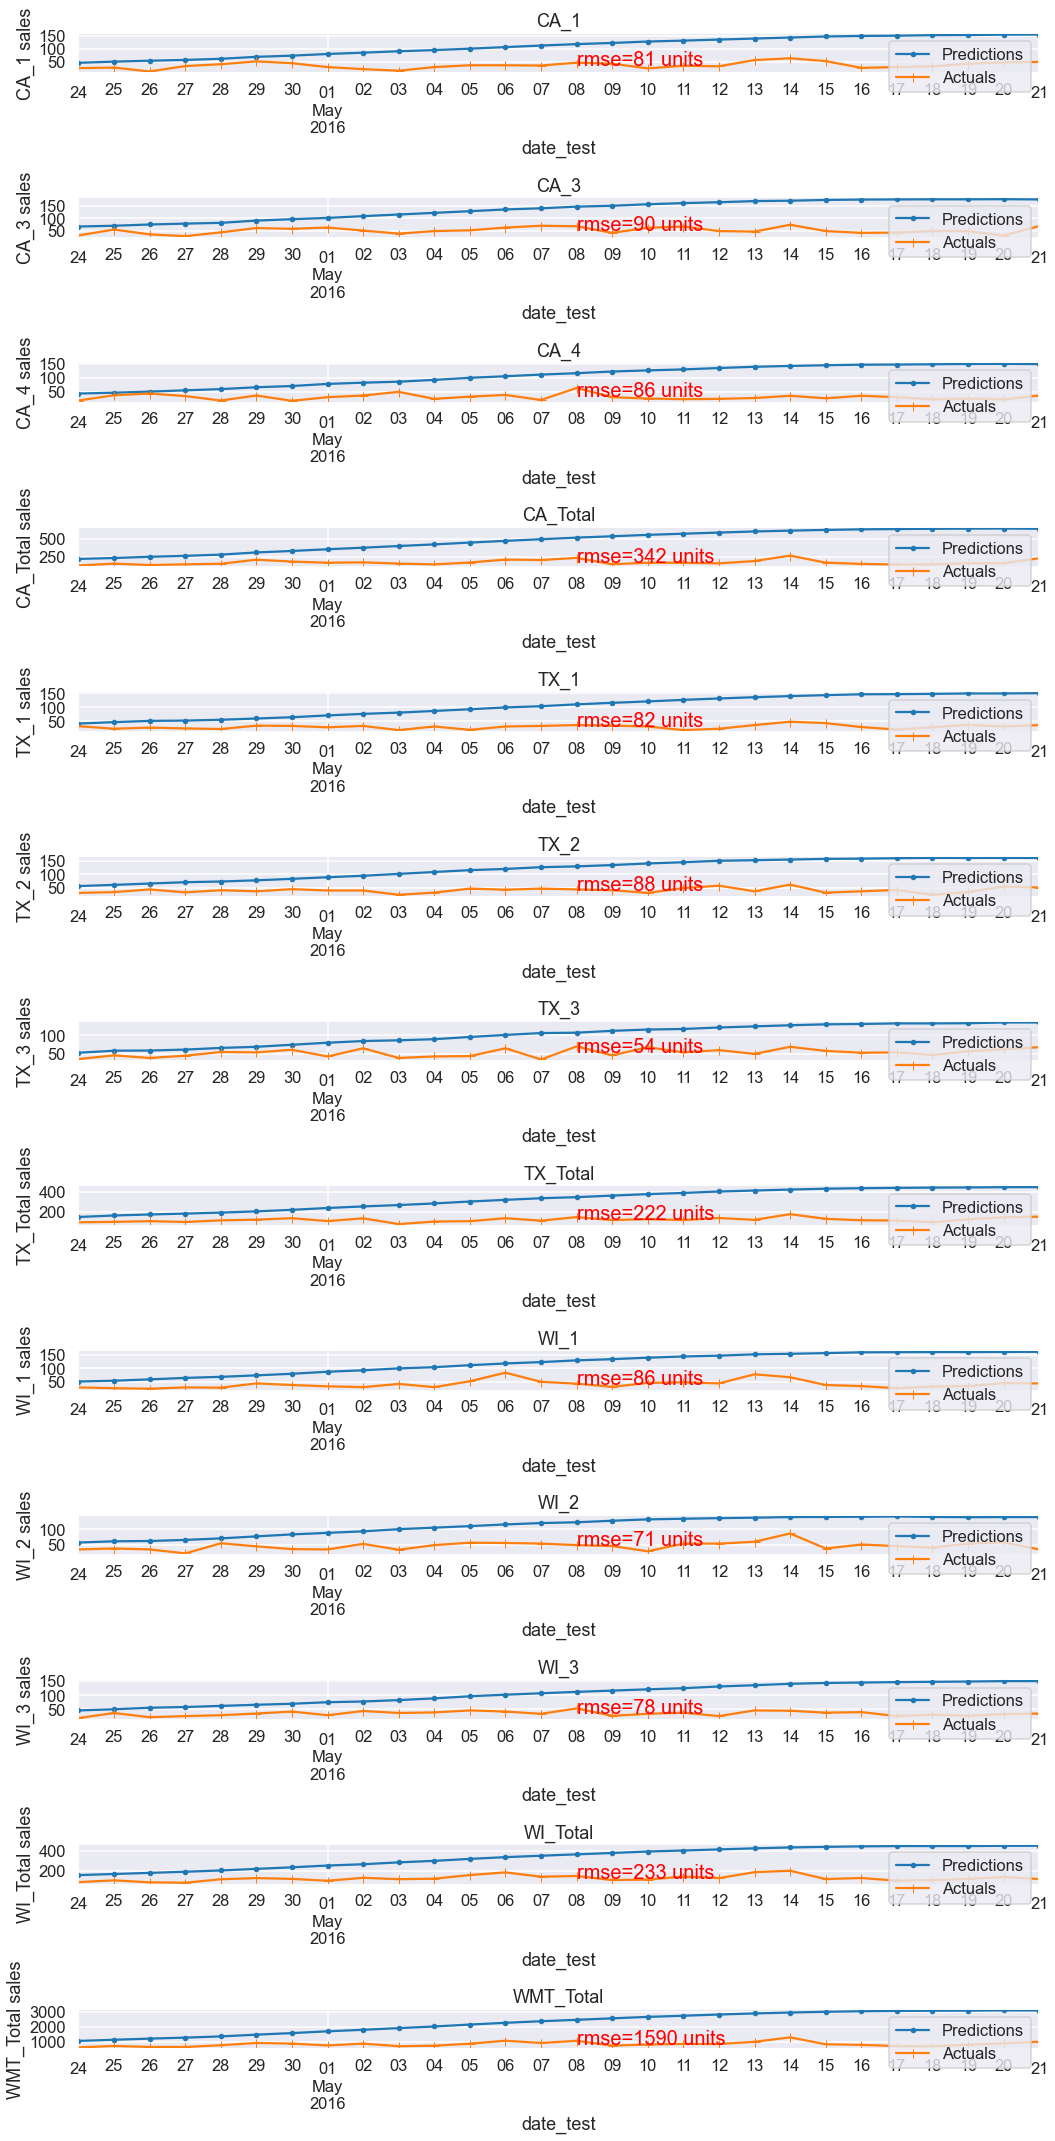

In [701]:
var=['CA_1','CA_3','CA_4','CA_Total','TX_1','TX_2','TX_3','TX_Total','WI_1','WI_2','WI_3','WI_Total','WMT_Total']


fig,ax = plt.subplots(nrows=len(var),figsize=[15,30])
                     
for ix, store in enumerate(var): 
    test_preds_summary_T[[f'{store}']].plot(marker=".",ax=ax[ix])
    test_actuals_summary_T[[f'{store}']].plot(marker="+",ax=ax[ix])
    rmse = math.ceil(mean_squared_error(test_actuals_summary_T[[f'{store}']], test_preds_summary_T[[f'{store}']],\
                                        squared=False))
    ax[ix].text(test_preds_summary_T.reset_index().iloc[14,0],test_actuals_summary_T[[f'{store}']].mean()\
                ,f"rmse={rmse} units",**style)
    #ax[ix].set_ylim(0,2.5*test_actuals_summary_T[f'{store}'].max())
    ax[ix].legend(["Predictions","Actuals"])
    ax[ix].set(title=f"{store}", ylabel=f"{store} sales")
    
fig.tight_layout()
plt.show()

In [702]:
gc.collect()

5040